# 📈  ML/NN_Insurance_Company_Health: Diabetes Prediction for Insurance Clients


## 👤 Author Information

| Field               | Information                         |
|--------------------|--------------------------------------|
| **Name**           | Rodrigo Alvarez                      |
| **Email**          | rodrigo_alva_par@outlook.com         |
| **Linkedin**       | https://www.linkedin.com/in/rodrigo-%C3%A1lvarez-pardo/ |
| **Project Title**  | ML/NN_Insurance_Company              |
| **Date**           | April 03, 2025                       |



## 🧾 Project Description

In this project, our objective is to develop a **machine learning** or **neural network (NN)** tool to predict whether our insurance clients are likely to have diabetes.

The data will be extracted through **web scraping** from the following database: [https://www.cdc.gov/nchs/](https://www.cdc.gov/nchs/) *(Centers for Disease Control and Prevention – National Center for Health Statistics)*.

Specifically, we will use data from **NHANES (National Health and Nutrition Examination Survey)**, which combines interviews and physical examinations to assess the health and nutritional status of adults and children in the United States. The dataset includes a wide range of variables such as demographic data, dietary habits, laboratory results, and health-related behaviors.

The training data will be collected from the years **1999 to 2017**, while the data used for making predictions and evaluating the model's performance will span from **2018 to 2023**.


This dataset contains information about insurance clients, including **laboratory test results** and **lifestyle data**, as well as a **target variable** indicating whether the client was diagnosed with diabetes.

### 📊 Variable Summary

- **Gender**  
  `1 = Male`, `2 = Female`

- **Age (years)**  
  Client’s age.

- **Race**  
  `1 = Mexican American`  
  `2 = Other Hispanic`  
  `3 = White`  
  `4 = Black`  
  `5 = Other race`

- **Country of Birth**  
  `1 = Born in the U.S.`  
  `2 = Other`

- **Income Category**  
  Household purchasing power:  
  `1 = Below poverty level`  
  `2 = Low income`  
  `3 = Middle income`  
  `4 = High income`  
  `5 = Very high income`

- **Height (m)**  
  Client’s height in meters.

- **Weight (kg)**  
  Client’s weight in kilograms.

- **HDL-Cholesterol (nmol/L)**  
  High-density lipoprotein cholesterol, also known as “good cholesterol.” Higher values are generally better.

- **Total Cholesterol (mmol/L)**  
  Measures the total amount of cholesterol in the blood, including LDL and HDL.

- **Glycohemoglobin (%)**  
  Also known as **HbA1c**, this reflects the average blood sugar level over the past 2–3 months. Higher values indicate worse glucose control.

- **Insulin (pmol/L)**  
  Measures the amount of insulin in the blood, used to evaluate how the body processes glucose.

- **High Blood Pressure?**  
  `1 = Yes`, `2 = No`  
  Has a doctor ever diagnosed you with high blood pressure?

- **100 Cigarettes in Life?**  
  `1 = Yes`, `2 = No`  
  Have you smoked more than 100 cigarettes in your entire life?

- **Diabetes Diagnosed (Target)**  
  `0 = No`, `1 = Yes`  
  Has a doctor ever told you that you have diabetes?


# IMPORTS

In [3]:
### Scrapping imports:

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import os 

### Procesing imports

import numpy as np

### ML and EDA imports
import sys
import importlib
import phik
import joblib


import matplotlib.pyplot as plt
import seaborn as sns

# ruta_utils = os.path.abspath("../utils")
sys.path.append("../utils")
import Toolbox_datascience as tds
from Pipeline_utils import FeatureEngineer

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score,precision_score, roc_auc_score, 
                             precision_recall_curve, confusion_matrix,classification_report, roc_curve, average_precision_score)


### NN

from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Recall
from tensorflow.keras.metrics import Precision
from tensorflow.keras.models import load_model





In [5]:
importlib.reload(tds)

<module 'Toolbox_datascience' from 'c:\\Users\\rodri\\Git_Repositories\\ML_Insurance_Company_Health_Diabetes\\ML_Insurance_Company_Health_Diabetes\\src\\result_notebooks\\../utils\\Toolbox_datascience.py'>

# Scrapping 

## 📥 NHANES Data Download (1999–2023)

In this section, we will download data from all available years (**1999 to 2023**) without distinguishing between training and prediction subsets. The goal is to gather a comprehensive collection of variables from the **NHANES (National Health and Nutrition Examination Survey)** database that will later be filtered, cleaned, and merged for analysis and modeling.

Each subsection retrieves data from the following three domains:


### 📊 Sections Included

| Category                  | NHANES Section Code | Description                            |
|---------------------------|---------------------|----------------------------------------|
| **Demographics**          | `DEMO`              | Age, gender, income, race, country of birth |
| **Laboratory Tests**      | `HDL`, `TCHOL`, `GHB`, `INS`, `GLU` | Cholesterol, HbA1c, insulin, glucose levels |
| **Questionnaires**        | `DIQ`, `BPQ`, `SMQ`, `WHQ`          | Diabetes diagnosis, blood pressure, smoking history, weight history |




Each `.xpt` file will be downloaded from the **CDC NHANES repository**, converted to `.csv`, and stored in a structured folder for further processing.


## Demographic data

In [6]:
file_mapping = {
    "2021": ["DEMO_L.xpt"],
    "2017": ["P_DEMO.xpt", "DEMO_J.xpt"],
    "2015": ["DEMO_I.xpt"],
    "2013": ["DEMO_H.xpt"],
    "2011": ["DEMO_G.xpt"],
    "2009": ["DEMO_F.xpt"],
    "2007": ["DEMO_E.xpt"],
    "2005": ["DEMO_D.xpt"],
    "2003": ["DEMO_C.xpt"],
    "2001": ["DEMO_B.xpt"],
    "1999": ["DEMO.xpt"]
}

# Output folder
output_folder = "../data/raw_data/DEMO/"
os.makedirs(output_folder, exist_ok=True)

# Request headers
headers = {"User-Agent": "Mozilla/5.0"}

# Loop through each year and its corresponding file(s)
for year, file_list in file_mapping.items():
    # Ensure file_list is a list
    if isinstance(file_list, str):
        file_list = [file_list]
    
    for filename_xpt in file_list:
        url = f"https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/{year}/DataFiles/{filename_xpt}"

        print(f"Downloading: {url}")
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            xpt_path = os.path.join(output_folder, filename_xpt)
            with open(xpt_path, "wb") as f:
                f.write(response.content)
            print(f"File saved: {xpt_path}")

            # Convert to CSV
            try:
                df = pd.read_sas(xpt_path, format="xport")
                csv_name = filename_xpt.replace(".xpt", f"_{year}.csv")
                csv_path = os.path.join(output_folder, csv_name)
                df.to_csv(csv_path, index=False)
                os.remove(xpt_path)
                print(f"Converted to CSV: {csv_path}")
            except Exception as e:
                print(f"Error converting {filename_xpt}: {e}")
        else:
            print(f"Error {response.status_code} while downloading {url}")


Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.xpt
File saved: ../data/raw_data/DEMO/DEMO_L.xpt
Converted to CSV: ../data/raw_data/DEMO/DEMO_L_2021.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_DEMO.xpt
File saved: ../data/raw_data/DEMO/P_DEMO.xpt
Converted to CSV: ../data/raw_data/DEMO/P_DEMO_2017.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/DEMO_J.xpt
File saved: ../data/raw_data/DEMO/DEMO_J.xpt
Converted to CSV: ../data/raw_data/DEMO/DEMO_J_2017.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2015/DataFiles/DEMO_I.xpt
File saved: ../data/raw_data/DEMO/DEMO_I.xpt
Converted to CSV: ../data/raw_data/DEMO/DEMO_I_2015.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/DEMO_H.xpt
File saved: ../data/raw_data/DEMO/DEMO_H.xpt
Converted to CSV: ../data/raw_data/DEMO/DEMO_H_2013.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2011/DataFiles/DE

## HDL

In [7]:
file_mapping = {
    "2021": ["HDL_L.xpt"],
    "2017": ["P_HDL.xpt", "HDL_J.xpt"],
    "2015": ["HDL_I.xpt"],
    "2013": ["HDL_H.xpt"],
    "2011": ["HDL_G.xpt"],
    "2009": ["HDL_F.xpt"],
    "2007": ["HDL_E.xpt"],
    "2005": ["HDL_D.xpt"],
    "2003": ["L13_C.xpt"],
    "2001": ["L13_B.xpt"],
    "1999": ["LAB13.xpt"]
}

# Output folder
output_folder = "../data/raw_data/HDL/"
os.makedirs(output_folder, exist_ok=True)

# Request headers
headers = {"User-Agent": "Mozilla/5.0"}

# Loop through each year and its corresponding file(s)
for year, file_list in file_mapping.items():
    # Ensure file_list is a list
    if isinstance(file_list, str):
        file_list = [file_list]
    
    for filename_xpt in file_list:
        url = f"https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/{year}/DataFiles/{filename_xpt}"

        print(f"Downloading: {url}")
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            xpt_path = os.path.join(output_folder, filename_xpt)
            with open(xpt_path, "wb") as f:
                f.write(response.content)
            print(f"File saved: {xpt_path}")

            # Convert to CSV
            try:
                df = pd.read_sas(xpt_path, format="xport")
                csv_name = filename_xpt.replace(".xpt", f"_{year}.csv")
                csv_path = os.path.join(output_folder, csv_name)
                df.to_csv(csv_path, index=False)
                os.remove(xpt_path)
                print(f"Converted to CSV: {csv_path}")
            except Exception as e:
                print(f"Error converting {filename_xpt}: {e}")
        else:
            print(f"Error {response.status_code} while downloading {url}")


Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/HDL_L.xpt
File saved: ../data/raw_data/HDL/HDL_L.xpt
Converted to CSV: ../data/raw_data/HDL/HDL_L_2021.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_HDL.xpt
File saved: ../data/raw_data/HDL/P_HDL.xpt
Converted to CSV: ../data/raw_data/HDL/P_HDL_2017.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/HDL_J.xpt
File saved: ../data/raw_data/HDL/HDL_J.xpt
Converted to CSV: ../data/raw_data/HDL/HDL_J_2017.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2015/DataFiles/HDL_I.xpt
File saved: ../data/raw_data/HDL/HDL_I.xpt
Converted to CSV: ../data/raw_data/HDL/HDL_I_2015.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/HDL_H.xpt
File saved: ../data/raw_data/HDL/HDL_H.xpt
Converted to CSV: ../data/raw_data/HDL/HDL_H_2013.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2011/DataFiles/HDL_G.xpt
File saved: ../da

## Total cholesterol

In [8]:

file_mapping = {
    "2021": ["TCHOL_L.xpt"],
    "2017": ["P_TCHOL.xpt", "TCHOL_J.xpt"],
    "2015": ["TCHOL_I.xpt"],
    "2013": ["TCHOL_H.xpt"],
    "2011": ["TCHOL_G.xpt"],
    "2009": ["TCHOL_F.xpt"],
    "2007": ["TCHOL_E.xpt"],
    "2005": ["TCHOL_D.xpt"],
}

# Output folder
output_folder = "../data/raw_data/chol_total/"
os.makedirs(output_folder, exist_ok=True)

# Request headers
headers = {"User-Agent": "Mozilla/5.0"}

# Loop through each year and its corresponding file(s)
for year, file_list in file_mapping.items():
    # Ensure file_list is a list
    if isinstance(file_list, str):
        file_list = [file_list]
    
    for filename_xpt in file_list:
        url = f"https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/{year}/DataFiles/{filename_xpt}"

        print(f"Downloading: {url}")
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            xpt_path = os.path.join(output_folder, filename_xpt)
            with open(xpt_path, "wb") as f:
                f.write(response.content)
            print(f"File saved: {xpt_path}")

            # Convert to CSV
            try:
                df = pd.read_sas(xpt_path, format="xport")
                csv_name = filename_xpt.replace(".xpt", f"_{year}.csv")
                csv_path = os.path.join(output_folder, csv_name)
                df.to_csv(csv_path, index=False)
                os.remove(xpt_path)
                print(f"Converted to CSV: {csv_path}")
            except Exception as e:
                print(f"Error converting {filename_xpt}: {e}")
        else:
            print(f"Error {response.status_code} while downloading {url}")


Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/TCHOL_L.xpt


File saved: ../data/raw_data/chol_total/TCHOL_L.xpt
Converted to CSV: ../data/raw_data/chol_total/TCHOL_L_2021.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_TCHOL.xpt
File saved: ../data/raw_data/chol_total/P_TCHOL.xpt
Converted to CSV: ../data/raw_data/chol_total/P_TCHOL_2017.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/TCHOL_J.xpt
File saved: ../data/raw_data/chol_total/TCHOL_J.xpt
Converted to CSV: ../data/raw_data/chol_total/TCHOL_J_2017.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2015/DataFiles/TCHOL_I.xpt
File saved: ../data/raw_data/chol_total/TCHOL_I.xpt
Converted to CSV: ../data/raw_data/chol_total/TCHOL_I_2015.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/TCHOL_H.xpt
File saved: ../data/raw_data/chol_total/TCHOL_H.xpt
Converted to CSV: ../data/raw_data/chol_total/TCHOL_H_2013.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2011/DataFiles/TCHOL_G.xpt


### Glycohemoglobin (GHB) 

In [9]:
file_mapping = {
    "2021": ["GHB_L.xpt"],
    "2017": ["P_GHB.xpt", "GHB_J.xpt"],
    "2015": ["GHB_I.xpt"],
    "2013": ["GHB_H.xpt"],
    "2011": ["GHB_G.xpt"],
    "2009": ["GHB_F.xpt"],
    "2007": ["GHB_E.xpt"],
    "2005": ["GHB_D.xpt"],
    "2003": ["L10_C.xpt"],
    "2001": ["L10_B.xpt"],
    "1999": ["LAB10.xpt"]
}

# Output folder
output_folder = "../data/raw_data/GHB/"
os.makedirs(output_folder, exist_ok=True)

# Request headers
headers = {"User-Agent": "Mozilla/5.0"}

# Loop through each year and its corresponding file(s)
for year, file_list in file_mapping.items():
    # Ensure file_list is a list
    if isinstance(file_list, str):
        file_list = [file_list]
    
    for filename_xpt in file_list:
        url = f"https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/{year}/DataFiles/{filename_xpt}"

        print(f"Downloading: {url}")
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            xpt_path = os.path.join(output_folder, filename_xpt)
            with open(xpt_path, "wb") as f:
                f.write(response.content)
            print(f"File saved: {xpt_path}")

            # Convert to CSV
            try:
                df = pd.read_sas(xpt_path, format="xport")
                csv_name = filename_xpt.replace(".xpt", f"_{year}.csv")
                csv_path = os.path.join(output_folder, csv_name)
                df.to_csv(csv_path, index=False)
                os.remove(xpt_path)
                print(f"Converted to CSV: {csv_path}")
            except Exception as e:
                print(f"Error converting {filename_xpt}: {e}")
        else:
            print(f"Error {response.status_code} while downloading {url}")


Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/GHB_L.xpt
File saved: ../data/raw_data/GHB/GHB_L.xpt
Converted to CSV: ../data/raw_data/GHB/GHB_L_2021.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_GHB.xpt
File saved: ../data/raw_data/GHB/P_GHB.xpt
Converted to CSV: ../data/raw_data/GHB/P_GHB_2017.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/GHB_J.xpt
File saved: ../data/raw_data/GHB/GHB_J.xpt
Converted to CSV: ../data/raw_data/GHB/GHB_J_2017.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2015/DataFiles/GHB_I.xpt
File saved: ../data/raw_data/GHB/GHB_I.xpt
Converted to CSV: ../data/raw_data/GHB/GHB_I_2015.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/GHB_H.xpt
File saved: ../data/raw_data/GHB/GHB_H.xpt
Converted to CSV: ../data/raw_data/GHB/GHB_H_2013.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2011/DataFiles/GHB_G.xpt
File saved: ../da

### Insulin

In [10]:
file_mapping = {
    "2021": ["INS_L.xpt"],
    "2017": ["P_INS.xpt", "INS_J.xpt"],
    "2015": ["INS_I.xpt"],
    "2013": ["INS_H.xpt"],
    "2011": ["INS_G.xpt"],
    "2009": ["INS_F.xpt"],
    "2007": ["INS_E.xpt"],
    "2005": ["INS_D.xpt"],
    "2003": ["L10AM_C.xpt"],
    "2001": ["L10_2_B.xpt"],
    "1999": ["LAB10AM.xpt"]
}

# Output folder
output_folder = "../data/raw_data/INS/"
os.makedirs(output_folder, exist_ok=True)

# Request headers
headers = {"User-Agent": "Mozilla/5.0"}

# Loop through each year and its corresponding file(s)
for year, file_list in file_mapping.items():
    # Ensure file_list is a list
    if isinstance(file_list, str):
        file_list = [file_list]
    
    for filename_xpt in file_list:
        url = f"https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/{year}/DataFiles/{filename_xpt}"

        print(f"Downloading: {url}")
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            xpt_path = os.path.join(output_folder, filename_xpt)
            with open(xpt_path, "wb") as f:
                f.write(response.content)
            print(f"File saved: {xpt_path}")

            # Convert to CSV
            try:
                df = pd.read_sas(xpt_path, format="xport")
                csv_name = filename_xpt.replace(".xpt", f"_{year}.csv")
                csv_path = os.path.join(output_folder, csv_name)
                df.to_csv(csv_path, index=False)
                os.remove(xpt_path)
                print(f"Converted to CSV: {csv_path}")
            except Exception as e:
                print(f"Error converting {filename_xpt}: {e}")
        else:
            print(f"Error {response.status_code} while downloading {url}")


Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/INS_L.xpt
File saved: ../data/raw_data/INS/INS_L.xpt
Converted to CSV: ../data/raw_data/INS/INS_L_2021.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_INS.xpt
File saved: ../data/raw_data/INS/P_INS.xpt
Converted to CSV: ../data/raw_data/INS/P_INS_2017.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/INS_J.xpt
File saved: ../data/raw_data/INS/INS_J.xpt
Converted to CSV: ../data/raw_data/INS/INS_J_2017.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2015/DataFiles/INS_I.xpt
File saved: ../data/raw_data/INS/INS_I.xpt
Converted to CSV: ../data/raw_data/INS/INS_I_2015.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/INS_H.xpt
File saved: ../data/raw_data/INS/INS_H.xpt
Converted to CSV: ../data/raw_data/INS/INS_H_2013.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2011/DataFiles/INS_G.xpt
Error 404 while d


### Fasting Glucose and more Insulin data

In [11]:
file_mapping = {
    "2017": ["GLU_J.xpt"],
    "2015": ["GLU_I.xpt"],
    "2013": ["GLU_H.xpt"],
    "2011": ["GLU_G.xpt"],
    "2009": ["GLU_F.xpt"],
    "2007": ["GLU_E.xpt"],
    "2005": ["GLU_D.xpt"]
}

# Output folder
output_folder = "../data/raw_data/GLU/"
os.makedirs(output_folder, exist_ok=True)

# Request headers
headers = {"User-Agent": "Mozilla/5.0"}

# Loop through each year and its corresponding file(s)
for year, file_list in file_mapping.items():
    # Ensure file_list is a list
    if isinstance(file_list, str):
        file_list = [file_list]
    
    for filename_xpt in file_list:
        url = f"https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/{year}/DataFiles/{filename_xpt}"

        print(f"Downloading: {url}")
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            xpt_path = os.path.join(output_folder, filename_xpt)
            with open(xpt_path, "wb") as f:
                f.write(response.content)
            print(f"File saved: {xpt_path}")

            # Convert to CSV
            try:
                df = pd.read_sas(xpt_path, format="xport")
                csv_name = filename_xpt.replace(".xpt", f"_{year}.csv")
                csv_path = os.path.join(output_folder, csv_name)
                df.to_csv(csv_path, index=False)
                os.remove(xpt_path)
                print(f"Converted to CSV: {csv_path}")
            except Exception as e:
                print(f"Error converting {filename_xpt}: {e}")
        else:
            print(f"Error {response.status_code} while downloading {url}")


Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/GLU_J.xpt
File saved: ../data/raw_data/GLU/GLU_J.xpt
Converted to CSV: ../data/raw_data/GLU/GLU_J_2017.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2015/DataFiles/GLU_I.xpt
File saved: ../data/raw_data/GLU/GLU_I.xpt
Converted to CSV: ../data/raw_data/GLU/GLU_I_2015.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/GLU_H.xpt
File saved: ../data/raw_data/GLU/GLU_H.xpt
Converted to CSV: ../data/raw_data/GLU/GLU_H_2013.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2011/DataFiles/GLU_G.xpt
File saved: ../data/raw_data/GLU/GLU_G.xpt
Converted to CSV: ../data/raw_data/GLU/GLU_G_2011.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2009/DataFiles/GLU_F.xpt
File saved: ../data/raw_data/GLU/GLU_F.xpt
Converted to CSV: ../data/raw_data/GLU/GLU_F_2009.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2007/DataFiles/GLU_E.xpt
File saved: ../da

### Weight and Heigth data

In [12]:
file_mapping = {
    "2021": ["WHQ_L.xpt"],
    "2017": ["P_WHQ.xpt", "WHQ_J.xpt"],
    "2015": ["WHQ_I.xpt"],
    "2013": ["WHQ_H.xpt"],
    "2011": ["WHQ_G.xpt"],
    "2009": ["WHQ_F.xpt"],
    "2007": ["WHQ_E.xpt"],
    "2005": ["WHQ_D.xpt"],
    "2003": ["WHQ_C.xpt"],
    "2001": ["WHQ_B.xpt"],
    "1999": ["WHQ.xpt"]
}

# Output folder
output_folder = "../data/raw_data/weight/"
os.makedirs(output_folder, exist_ok=True)

# Request headers
headers = {"User-Agent": "Mozilla/5.0"}

# Loop through each year and its corresponding file(s)
for year, file_list in file_mapping.items():
    # Ensure file_list is a list
    if isinstance(file_list, str):
        file_list = [file_list]
    
    for filename_xpt in file_list:
        url = f"https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/{year}/DataFiles/{filename_xpt}"

        print(f"Downloading: {url}")
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            xpt_path = os.path.join(output_folder, filename_xpt)
            with open(xpt_path, "wb") as f:
                f.write(response.content)
            print(f"File saved: {xpt_path}")

            # Convert to CSV
            try:
                df = pd.read_sas(xpt_path, format="xport")
                csv_name = filename_xpt.replace(".xpt", f"_{year}.csv")
                csv_path = os.path.join(output_folder, csv_name)
                df.to_csv(csv_path, index=False)
                os.remove(xpt_path)
                print(f"Converted to CSV: {csv_path}")
            except Exception as e:
                print(f"Error converting {filename_xpt}: {e}")
        else:
            print(f"Error {response.status_code} while downloading {url}")


Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/WHQ_L.xpt
File saved: ../data/raw_data/weight/WHQ_L.xpt
Converted to CSV: ../data/raw_data/weight/WHQ_L_2021.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_WHQ.xpt
File saved: ../data/raw_data/weight/P_WHQ.xpt
Converted to CSV: ../data/raw_data/weight/P_WHQ_2017.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/WHQ_J.xpt
File saved: ../data/raw_data/weight/WHQ_J.xpt
Converted to CSV: ../data/raw_data/weight/WHQ_J_2017.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2015/DataFiles/WHQ_I.xpt
File saved: ../data/raw_data/weight/WHQ_I.xpt
Converted to CSV: ../data/raw_data/weight/WHQ_I_2015.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/WHQ_H.xpt
File saved: ../data/raw_data/weight/WHQ_H.xpt
Converted to CSV: ../data/raw_data/weight/WHQ_H_2013.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2011/DataFil

### Diabetes  data

In [13]:
file_mapping = {
    "2021": ["DIQ_L.xpt"],
    "2017": ["P_DIQ.xpt", "DIQ_J.xpt"],
    "2015": ["DIQ_I.xpt"],
    "2013": ["DIQ_H.xpt"],
    "2011": ["DIQ_G.xpt"],
    "2009": ["DIQ_F.xpt"],
    "2007": ["DIQ_E.xpt"],
    "2005": ["DIQ_D.xpt"],
    "2003": ["DIQ_C.xpt"],
    "2001": ["DIQ_B.xpt"],
    "1999": ["DIQ.xpt"]
}

# Output folder
output_folder = "../data/raw_data/diabetes/"
os.makedirs(output_folder, exist_ok=True)

# Request headers
headers = {"User-Agent": "Mozilla/5.0"}

# Loop through each year and its corresponding file(s)
for year, file_list in file_mapping.items():
    # Ensure file_list is a list
    if isinstance(file_list, str):
        file_list = [file_list]
    
    for filename_xpt in file_list:
        url = f"https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/{year}/DataFiles/{filename_xpt}"

        print(f"Downloading: {url}")
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            xpt_path = os.path.join(output_folder, filename_xpt)
            with open(xpt_path, "wb") as f:
                f.write(response.content)
            print(f"File saved: {xpt_path}")

            # Convert to CSV
            try:
                df = pd.read_sas(xpt_path, format="xport")
                csv_name = filename_xpt.replace(".xpt", f"_{year}.csv")
                csv_path = os.path.join(output_folder, csv_name)
                df.to_csv(csv_path, index=False)
                os.remove(xpt_path)
                print(f"Converted to CSV: {csv_path}")
            except Exception as e:
                print(f"Error converting {filename_xpt}: {e}")
        else:
            print(f"Error {response.status_code} while downloading {url}")


Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DIQ_L.xpt
File saved: ../data/raw_data/diabetes/DIQ_L.xpt
Converted to CSV: ../data/raw_data/diabetes/DIQ_L_2021.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_DIQ.xpt
File saved: ../data/raw_data/diabetes/P_DIQ.xpt
Converted to CSV: ../data/raw_data/diabetes/P_DIQ_2017.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/DIQ_J.xpt
File saved: ../data/raw_data/diabetes/DIQ_J.xpt
Converted to CSV: ../data/raw_data/diabetes/DIQ_J_2017.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2015/DataFiles/DIQ_I.xpt
File saved: ../data/raw_data/diabetes/DIQ_I.xpt
Converted to CSV: ../data/raw_data/diabetes/DIQ_I_2015.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/DIQ_H.xpt
File saved: ../data/raw_data/diabetes/DIQ_H.xpt
Converted to CSV: ../data/raw_data/diabetes/DIQ_H_2013.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes

### Blood pressure

In [14]:
file_mapping = {
    "2021": ["BPQ_L.xpt"],
    "2017": ["P_BPQ.xpt", "BPQ_J.xpt"],
    "2015": ["BPQ_I.xpt"],
    "2013": ["BPQ_H.xpt"],
    "2011": ["BPQ_G.xpt"],
    "2009": ["BPQ_F.xpt"],
    "2007": ["BPQ_E.xpt"],
    "2005": ["BPQ_D.xpt"],
    "2003": ["BPQ_C.xpt"],
    "2001": ["BPQ_B.xpt"],
    "1999": ["BPQ.xpt"]
}

# Output folder
output_folder = "../data/raw_data/BPQ/"
os.makedirs(output_folder, exist_ok=True)

# Request headers
headers = {"User-Agent": "Mozilla/5.0"}

# Loop through each year and its corresponding file(s)
for year, file_list in file_mapping.items():
    # Ensure file_list is a list
    if isinstance(file_list, str):
        file_list = [file_list]
    
    for filename_xpt in file_list:
        url = f"https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/{year}/DataFiles/{filename_xpt}"

        print(f"Downloading: {url}")
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            xpt_path = os.path.join(output_folder, filename_xpt)
            with open(xpt_path, "wb") as f:
                f.write(response.content)
            print(f"File saved: {xpt_path}")

            # Convert to CSV
            try:
                df = pd.read_sas(xpt_path, format="xport")
                csv_name = filename_xpt.replace(".xpt", f"_{year}.csv")
                csv_path = os.path.join(output_folder, csv_name)
                df.to_csv(csv_path, index=False)
                os.remove(xpt_path)
                print(f"Converted to CSV: {csv_path}")
            except Exception as e:
                print(f"Error converting {filename_xpt}: {e}")
        else:
            print(f"Error {response.status_code} while downloading {url}")


Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/BPQ_L.xpt
File saved: ../data/raw_data/BPQ/BPQ_L.xpt
Converted to CSV: ../data/raw_data/BPQ/BPQ_L_2021.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_BPQ.xpt
File saved: ../data/raw_data/BPQ/P_BPQ.xpt
Converted to CSV: ../data/raw_data/BPQ/P_BPQ_2017.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/BPQ_J.xpt
File saved: ../data/raw_data/BPQ/BPQ_J.xpt
Converted to CSV: ../data/raw_data/BPQ/BPQ_J_2017.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2015/DataFiles/BPQ_I.xpt
File saved: ../data/raw_data/BPQ/BPQ_I.xpt
Converted to CSV: ../data/raw_data/BPQ/BPQ_I_2015.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/BPQ_H.xpt
File saved: ../data/raw_data/BPQ/BPQ_H.xpt
Converted to CSV: ../data/raw_data/BPQ/BPQ_H_2013.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2011/DataFiles/BPQ_G.xpt
File saved: ../da

### Smoking use

In [15]:
file_mapping = {
    "2021": ["SMQ_L.xpt"],
    "2017": ["P_SMQ.xpt", "SMQ_J.xpt"],
    "2015": ["SMQ_I.xpt"],
    "2013": ["SMQ_H.xpt"],
    "2011": ["SMQ_G.xpt"],
    "2009": ["SMQ_F.xpt"],
    "2007": ["SMQ_E.xpt"],
    "2005": ["SMQ_D.xpt"],
    "2003": ["SMQ_C.xpt"],
    "2001": ["SMQ_B.xpt"],
    "1999": ["SMQ.xpt"]
}

# Output folder
output_folder = "../data/raw_data/SMQ/"
os.makedirs(output_folder, exist_ok=True)

# Request headers
headers = {"User-Agent": "Mozilla/5.0"}

# Loop through each year and its corresponding file(s)
for year, file_list in file_mapping.items():
    # Ensure file_list is a list
    if isinstance(file_list, str):
        file_list = [file_list]
    
    for filename_xpt in file_list:
        url = f"https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/{year}/DataFiles/{filename_xpt}"

        print(f"Downloading: {url}")
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            xpt_path = os.path.join(output_folder, filename_xpt)
            with open(xpt_path, "wb") as f:
                f.write(response.content)
            print(f"File saved: {xpt_path}")

            # Convert to CSV
            try:
                df = pd.read_sas(xpt_path, format="xport")
                csv_name = filename_xpt.replace(".xpt", f"_{year}.csv")
                csv_path = os.path.join(output_folder, csv_name)
                df.to_csv(csv_path, index=False)
                os.remove(xpt_path)
                print(f"Converted to CSV: {csv_path}")
            except Exception as e:
                print(f"Error converting {filename_xpt}: {e}")
        else:
            print(f"Error {response.status_code} while downloading {url}")


Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/SMQ_L.xpt
File saved: ../data/raw_data/SMQ/SMQ_L.xpt
Converted to CSV: ../data/raw_data/SMQ/SMQ_L_2021.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_SMQ.xpt
File saved: ../data/raw_data/SMQ/P_SMQ.xpt
Converted to CSV: ../data/raw_data/SMQ/P_SMQ_2017.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/SMQ_J.xpt
File saved: ../data/raw_data/SMQ/SMQ_J.xpt
Converted to CSV: ../data/raw_data/SMQ/SMQ_J_2017.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2015/DataFiles/SMQ_I.xpt
File saved: ../data/raw_data/SMQ/SMQ_I.xpt
Converted to CSV: ../data/raw_data/SMQ/SMQ_I_2015.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/SMQ_H.xpt
File saved: ../data/raw_data/SMQ/SMQ_H.xpt
Converted to CSV: ../data/raw_data/SMQ/SMQ_H_2013.csv
Downloading: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2011/DataFiles/SMQ_G.xpt
File saved: ../da

# Process data in train data and data to predict

### 🧩 Data Preprocessing from NHANES (1999–2023)

In this section, we systematically extracted and preprocessed health-related variables from the NHANES public datasets. For each health domain (demographics, lab tests, and questionnaires), we followed the same structured workflow:

- **Loaded survey files** from the `raw_data` folders using filename patterns (e.g., files containing `"L"` or `"P"`).
- **Filtered relevant columns** for each variable of interest (e.g., `DIQ010` for diabetes, `BPQ020` for high blood pressure, `SMQ020` for smoking history).
- **Renamed columns** to standardized, readable names (e.g., `"DIQ010"` → `"Diabetes_diagnosticated"`).
- **Handled missing or invalid values**, replacing codes such as `7.0` or `9.0` with `NaN`.
- **Concatenated datasets across multiple years** into unified DataFrames, such as:
  - `df_diabetes_prep` for diabetes diagnosis
  - `df_blood_prep` for blood pressure
  - `df_smoking_prep` for smoking history
- **Converted units** where necessary (e.g., inches to meters, pounds to kilograms).
- Prepared cleaned datasets ready to be used in the next steps for **EDA and predictive modeling**.


### Demograpphic data

In [16]:
folder_path = "../data/raw_data/DEMO"

# List to store the names of the created variables
variable_names = []

# Loop through files
for filename in os.listdir(folder_path):
    # Skip files that contain "L" or "P" (before the .csv extension)
    if filename.endswith(".csv") and "L" not in filename and "P" not in filename:
        file_path = os.path.join(folder_path, filename)

        # Create a safe variable name
        var_name = filename.replace(".csv", "").replace("-", "_").replace(" ", "_")
        
        # Read the CSV and assign it as a variable
        globals()[var_name] = pd.read_csv(file_path)

        # Store the variable name
        variable_names.append(var_name)
        
        print(f"Variable created: {var_name}")

# Display the resulting list
print("\nAll created variables:")
print(variable_names)


Variable created: DEMO_1999
Variable created: DEMO_B_2001
Variable created: DEMO_C_2003
Variable created: DEMO_D_2005
Variable created: DEMO_E_2007
Variable created: DEMO_F_2009
Variable created: DEMO_G_2011
Variable created: DEMO_H_2013
Variable created: DEMO_I_2015
Variable created: DEMO_J_2017

All created variables:
['DEMO_1999', 'DEMO_B_2001', 'DEMO_C_2003', 'DEMO_D_2005', 'DEMO_E_2007', 'DEMO_F_2009', 'DEMO_G_2011', 'DEMO_H_2013', 'DEMO_I_2015', 'DEMO_J_2017']


### This block of code is to select only the important columns for the analisys and depurate the value in them

In [17]:
# Columns you want to keep (only if they are available)
desired_cols = ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDBORN', 'INDFMPIR', 'DMDBORN4', 'DMDBORN2']

for name in variable_names:
    df = globals()[name]
    
    # Filter columns that exist in this DataFrame
    existing_cols = [col for col in desired_cols if col in df.columns]
    
    # Proceed only if at least one desired column is present
    if existing_cols:
        df = df[existing_cols]
        globals()[name] = df
        print(f"{name}: filtered columns → {existing_cols}")
    else:
        print(f"{name}: ⚠️ no desired columns found")

print("\n")

# Dictionary for renaming columns
rename_dict = {
    'RIAGENDR': 'Gender',
    'RIDAGEYR': 'Age(year)',
    'RIDRETH3': 'Race',
    'RIDRETH1': 'Race',         # if the dataset uses RIDRETH1 instead of RIDRETH3
    'DMDBORN4': 'Country_of_birth',
    'DMDBORN': 'Country_of_birth',
    'DMDBORN2': 'Country_of_birth',  # in case it uses DMDBORN
    'INDFMPIR': 'Income_poverty_num'
}

# Rename columns in all DataFrames
for name in variable_names:
    df = globals()[name]
    # Rename only the columns that exist
    cols_to_rename = {k: v for k, v in rename_dict.items() if k in df.columns}
    df.rename(columns=cols_to_rename, inplace=True)
    globals()[name] = df  # update the variable
    print(f"{name}: renamed columns → {list(cols_to_rename.values())}")

print("\n")

# Ensure all DataFrames are sorted by SEQN
for name in variable_names:
    df = globals()[name]
    if 'SEQN' in df.columns:
        df.sort_values('SEQN', inplace=True)
        df.reset_index(drop=True, inplace=True)
        globals()[name] = df

# Concatenate all DataFrames by rows
dfs_to_concat = [globals()[name] for name in variable_names]
train_demographic = pd.concat(dfs_to_concat, axis=0)

# Recode country of birth values (group foreign-born and handle missing)
train_demographic['Country_of_birth'] = train_demographic['Country_of_birth'].replace({
    3.0: 2.0, 4.0: 2.0, 5.0: 2.0, 77.0: np.nan
})

# Function to categorize income levels
def categorize_income(x):
    if x < 1.0:
        return 1.0  # below_poverty
    elif x < 2.0:
        return 2.0  # low_income
    elif x < 3.0:
        return 3.0  # middle_income
    elif x < 5.0:
        return 4.0  # high_income
    elif x == 5.0:
        return 5.0  # very_high_income
    else:
        return np.nan

# Apply income categorization and drop original column
train_demographic['Income_category'] = train_demographic['Income_poverty_num'].apply(categorize_income)
train_demographic.drop(columns=['Income_poverty_num'], inplace=True)

# Preview the result
train_demographic.head()


DEMO_1999: filtered columns → ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDBORN', 'INDFMPIR']
DEMO_B_2001: filtered columns → ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDBORN', 'INDFMPIR']
DEMO_C_2003: filtered columns → ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDBORN', 'INDFMPIR']
DEMO_D_2005: filtered columns → ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDBORN', 'INDFMPIR']
DEMO_E_2007: filtered columns → ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'INDFMPIR', 'DMDBORN2']
DEMO_F_2009: filtered columns → ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'INDFMPIR', 'DMDBORN2']
DEMO_G_2011: filtered columns → ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'INDFMPIR', 'DMDBORN4']
DEMO_H_2013: filtered columns → ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'INDFMPIR', 'DMDBORN4']
DEMO_I_2015: filtered columns → ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'INDFMPIR', 'DMDBORN4']
DEMO_J_2017: filtered columns → ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'INDFMPIR', 'DMDBORN

SEQN  Gender  Age(year)  Race  Country_of_birth  Income_category
0   1.0     2.0        2.0   4.0               1.0              1.0
1   2.0     1.0       77.0   3.0               1.0              5.0
2   3.0     2.0       10.0   3.0               2.0              2.0
3   4.0     1.0        1.0   4.0               1.0              1.0
4   5.0     1.0       49.0   3.0               1.0              5.0

In [19]:
train_demographic.dropna(inplace=True)
train_demographic.info()
train_demographic.to_csv('../data/Train_data/train_demographic.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 92112 entries, 0 to 9253
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SEQN              92112 non-null  float64
 1   Gender            92112 non-null  float64
 2   Age(year)         92112 non-null  float64
 3   Race              92112 non-null  float64
 4   Country_of_birth  92112 non-null  float64
 5   Income_category   92112 non-null  float64
dtypes: float64(6)
memory usage: 4.9 MB


### Weight and Height train data

In [21]:
folder_path = "../data/raw_data/weight"

# List to store the names of the created variables
variable_names = []

# Loop through files
for filename in os.listdir(folder_path):
    # Skip files that contain "L" or "P" (before the .csv extension)
    if filename.endswith(".csv") and "_L_" not in filename and "P_" not in filename:
        file_path = os.path.join(folder_path, filename)

        # Create a safe variable name
        var_name = filename.replace(".csv", "").replace("-", "_").replace(" ", "_")
        
        # Read the CSV and assign it as a variable
        globals()[var_name] = pd.read_csv(file_path)

        # Store the variable name
        variable_names.append(var_name)
        
        print(f"Variable created: {var_name}")

# Show the resulting list
print("\nAll created variables:")
print(variable_names)


Variable created: WHQ_1999
Variable created: WHQ_B_2001
Variable created: WHQ_C_2003
Variable created: WHQ_D_2005
Variable created: WHQ_E_2007
Variable created: WHQ_F_2009
Variable created: WHQ_G_2011
Variable created: WHQ_H_2013
Variable created: WHQ_I_2015
Variable created: WHQ_J_2017

All created variables:
['WHQ_1999', 'WHQ_B_2001', 'WHQ_C_2003', 'WHQ_D_2005', 'WHQ_E_2007', 'WHQ_F_2009', 'WHQ_G_2011', 'WHQ_H_2013', 'WHQ_I_2015', 'WHQ_J_2017']


In [22]:
# Columns you want to keep (if available)
desired_cols = ["SEQN", "WHD010", "WHD020"]

for name in variable_names:
    df = globals()[name]
    
    # Filter columns that exist in this DataFrame
    existing_cols = [col for col in desired_cols if col in df.columns]
    
    if existing_cols:
        df = df[existing_cols]
        globals()[name] = df
        print(f"{name}: filtered columns → {existing_cols}")
    else:
        print(f"{name}: no desired columns found")

print("\n")

# Renaming dictionary
rename_dict = {
    'WHD010': 'Height(m)',   # originally in inches
    'WHD020': 'Weight(kg)'   # originally in pounds
}

# Rename columns in all DataFrames
for name in variable_names:
    df = globals()[name]
    cols_to_rename = {k: v for k, v in rename_dict.items() if k in df.columns}
    df.rename(columns=cols_to_rename, inplace=True)
    globals()[name] = df
    print(f"{name}: renamed columns → {list(cols_to_rename.values())}")

print("\n")

# Sort all DataFrames by SEQN
for name in variable_names:
    df = globals()[name]
    if 'SEQN' in df.columns:
        df.sort_values('SEQN', inplace=True)
        df.reset_index(drop=True, inplace=True)
        globals()[name] = df

# Concatenate DataFrames row-wise (stacked)
dfs_to_concat = [globals()[name] for name in variable_names]
df_weight_train = pd.concat(dfs_to_concat, axis=0, ignore_index=True)

# Replace invalid/missing codes with NaN
df_weight_train['Height(m)'] = df_weight_train['Height(m)'].replace({99999.0: np.nan, 77777.0: np.nan, 9999.0: np.nan, 7777.0: np.nan})
df_weight_train['Weight(kg)'] = df_weight_train['Weight(kg)'].replace({99999.0: np.nan, 77777.0: np.nan, 9999.0: np.nan, 7777.0: np.nan})

# Convert units
# WHD010 was in inches → Height(m)
# WHD020 was in pounds → Weight(kg)
df_weight_train['Height(m)'] = df_weight_train['Height(m)'] * 0.0254
df_weight_train['Weight(kg)'] = df_weight_train['Weight(kg)'] * 0.453592

# Show final result
print("\nFinal DataFrame with converted units:")
print(df_weight_train.head())

# Save (optional)
df_weight_train.head()
 

WHQ_1999: filtered columns → ['SEQN', 'WHD010', 'WHD020']
WHQ_B_2001: filtered columns → ['SEQN', 'WHD010', 'WHD020']
WHQ_C_2003: filtered columns → ['SEQN', 'WHD010', 'WHD020']
WHQ_D_2005: filtered columns → ['SEQN', 'WHD010', 'WHD020']
WHQ_E_2007: filtered columns → ['SEQN', 'WHD010', 'WHD020']
WHQ_F_2009: filtered columns → ['SEQN', 'WHD010', 'WHD020']
WHQ_G_2011: filtered columns → ['SEQN', 'WHD010', 'WHD020']
WHQ_H_2013: filtered columns → ['SEQN', 'WHD010', 'WHD020']
WHQ_I_2015: filtered columns → ['SEQN', 'WHD010', 'WHD020']
WHQ_J_2017: filtered columns → ['SEQN', 'WHD010', 'WHD020']


WHQ_1999: renamed columns → ['Height(m)', 'Weight(kg)']
WHQ_B_2001: renamed columns → ['Height(m)', 'Weight(kg)']
WHQ_C_2003: renamed columns → ['Height(m)', 'Weight(kg)']
WHQ_D_2005: renamed columns → ['Height(m)', 'Weight(kg)']
WHQ_E_2007: renamed columns → ['Height(m)', 'Weight(kg)']
WHQ_F_2009: renamed columns → ['Height(m)', 'Weight(kg)']
WHQ_G_2011: renamed columns → ['Height(m)', 'Weight(kg

SEQN  Height(m)  Weight(kg)
0   2.0     1.7526   76.203456
1   5.0     1.8034   93.439952
2   6.0     1.6256   59.874144
3   7.0     1.6510   79.832192
4  10.0     1.9050   90.718400

In [23]:

df_weight_train.dropna(subset=['Height(m)', 'Weight(kg)'], inplace=True)
df_weight_train.info()
df_weight_train.to_csv('../data/Train_data/train_weight.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 61296 entries, 0 to 63591
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SEQN        61296 non-null  float64
 1   Height(m)   61296 non-null  float64
 2   Weight(kg)  61296 non-null  float64
dtypes: float64(3)
memory usage: 1.9 MB


### HDL Train data

In [24]:
folder_path = "../data/raw_data/HDL"
variable_names = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and not ("_L_" in filename or "P_" in filename):
        file_path = os.path.join(folder_path, filename)
        var_name = filename.replace(".csv", "").replace("-", "_").replace(" ", "_")
        globals()[var_name] = pd.read_csv(file_path)
        variable_names.append(var_name)
        print(f"Variable created: {var_name}")

print("\nAll created variables:")
print(variable_names)


Variable created: HDL_D_2005
Variable created: HDL_E_2007
Variable created: HDL_F_2009
Variable created: HDL_G_2011
Variable created: HDL_H_2013
Variable created: HDL_I_2015
Variable created: HDL_J_2017
Variable created: L13_B_2001
Variable created: L13_C_2003
Variable created: LAB13_1999

All created variables:
['HDL_D_2005', 'HDL_E_2007', 'HDL_F_2009', 'HDL_G_2011', 'HDL_H_2013', 'HDL_I_2015', 'HDL_J_2017', 'L13_B_2001', 'L13_C_2003', 'LAB13_1999']


### Total cholesterol train data

In [25]:
folder_path = "../data/raw_data/chol_total"

for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and not ("_L_" in filename or "P_" in filename):
        file_path = os.path.join(folder_path, filename)
        var_name = filename.replace(".csv", "").replace("-", "_").replace(" ", "_")
        globals()[var_name] = pd.read_csv(file_path)
        variable_names.append(var_name)
        print(f"Variable created: {var_name}")

print("\nAll created variables:")
print(variable_names)


Variable created: TCHOL_D_2005
Variable created: TCHOL_E_2007
Variable created: TCHOL_F_2009
Variable created: TCHOL_G_2011
Variable created: TCHOL_H_2013
Variable created: TCHOL_I_2015
Variable created: TCHOL_J_2017

All created variables:
['HDL_D_2005', 'HDL_E_2007', 'HDL_F_2009', 'HDL_G_2011', 'HDL_H_2013', 'HDL_I_2015', 'HDL_J_2017', 'L13_B_2001', 'L13_C_2003', 'LAB13_1999', 'TCHOL_D_2005', 'TCHOL_E_2007', 'TCHOL_F_2009', 'TCHOL_G_2011', 'TCHOL_H_2013', 'TCHOL_I_2015', 'TCHOL_J_2017']


In [26]:
# Columns to keep
desired_cols = ['SEQN', 'LBDHDDSI', 'LBDHDLSI', 'LBDTCSI']

# Filter desired columns in each DataFrame
for name in variable_names:
    df = globals()[name]
    existing_cols = [col for col in desired_cols if col in df.columns]
    
    if existing_cols:
        df = df[existing_cols]
        globals()[name] = df
        print(f"{name}: filtered columns → {existing_cols}")
    else:
        print(f"{name}: no desired columns found")

print("\n")

# Rename columns (if they exist)
rename_dict = {
    'LBDHDDSI': 'HDL-Cholesterol(mmol/L)',
    'LBDHDLSI': 'HDL-Cholesterol(mmol/L)',  # Some files use this instead
    'LBDTCSI': 'Total_Cholesterol(mmol/L)'
}

for name in variable_names:
    df = globals()[name]
    cols_to_rename = {k: v for k, v in rename_dict.items() if k in df.columns}
    df.rename(columns=cols_to_rename, inplace=True)
    globals()[name] = df
    print(f"{name}: renamed columns → {list(cols_to_rename.values())}")

print("\n")

# Merge year by year between HDL and TCHOL
merged_dfs = []
years = ['2005', '2007', '2009', '2011', '2013', '2015', '2017']

for year in years:
    # Find variables that contain the year
    hdl_vars = [v for v in variable_names if year in v and v.startswith("HDL")]
    tchol_vars = [v for v in variable_names if year in v and v.startswith("TCHOL")]

    if hdl_vars and tchol_vars:
        hdl_var = hdl_vars[0]
        tchol_var = tchol_vars[0]

        df_hdl = globals()[hdl_var]
        df_tchol = globals()[tchol_var]

        # Merge by SEQN
        df_merged = pd.merge(df_hdl, df_tchol, on='SEQN', how='outer')
        df_merged['Year'] = year
        merged_dfs.append(df_merged)

        print(f"{year}: Merge completed between {hdl_var} and {tchol_var}")
    else:
        print(f"{year}: HDL or TCHOL data not found.")

# Concatenate all merged DataFrames
df_HDL_TCHOL_train = pd.concat(merged_dfs, axis=0, ignore_index=True)
df_HDL_TCHOL_train.drop(columns="Year", inplace=True)

# Final result
print("\n Final DataFrame: HDL + TCHOL")
df_HDL_TCHOL_train.head()


HDL_D_2005: filtered columns → ['SEQN', 'LBDHDDSI']
HDL_E_2007: filtered columns → ['SEQN', 'LBDHDDSI']
HDL_F_2009: filtered columns → ['SEQN', 'LBDHDDSI']
HDL_G_2011: filtered columns → ['SEQN', 'LBDHDDSI']
HDL_H_2013: filtered columns → ['SEQN', 'LBDHDDSI']
HDL_I_2015: filtered columns → ['SEQN', 'LBDHDDSI']


HDL_J_2017: filtered columns → ['SEQN', 'LBDHDDSI']
L13_B_2001: filtered columns → ['SEQN', 'LBDHDLSI', 'LBDTCSI']
L13_C_2003: filtered columns → ['SEQN', 'LBDHDDSI', 'LBDTCSI']
LAB13_1999: filtered columns → ['SEQN', 'LBDHDLSI', 'LBDTCSI']
TCHOL_D_2005: filtered columns → ['SEQN', 'LBDTCSI']
TCHOL_E_2007: filtered columns → ['SEQN', 'LBDTCSI']
TCHOL_F_2009: filtered columns → ['SEQN', 'LBDTCSI']
TCHOL_G_2011: filtered columns → ['SEQN', 'LBDTCSI']
TCHOL_H_2013: filtered columns → ['SEQN', 'LBDTCSI']
TCHOL_I_2015: filtered columns → ['SEQN', 'LBDTCSI']
TCHOL_J_2017: filtered columns → ['SEQN', 'LBDTCSI']


HDL_D_2005: renamed columns → ['HDL-Cholesterol(mmol/L)']
HDL_E_2007: renamed columns → ['HDL-Cholesterol(mmol/L)']
HDL_F_2009: renamed columns → ['HDL-Cholesterol(mmol/L)']
HDL_G_2011: renamed columns → ['HDL-Cholesterol(mmol/L)']
HDL_H_2013: renamed columns → ['HDL-Cholesterol(mmol/L)']
HDL_I_2015: renamed columns → ['HDL-Cholesterol(mmol/L)']
HDL_J_2017: renamed columns → ['HDL-Ch

SEQN  HDL-Cholesterol(mmol/L)  Total_Cholesterol(mmol/L)
0  31128.0                     1.42                       3.34
1  31129.0                     1.19                       4.40
2  31130.0                      NaN                        NaN
3  31131.0                     1.01                       2.72
4  31132.0                     1.53                       3.80

In [27]:
df_HDL_TCHOL_train.dropna(inplace=True)
df_HDL_TCHOL_train.info()
df_HDL_TCHOL_train.to_csv('../data/Train_data/train_HDL_TCHOL.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 51199 entries, 0 to 56376
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SEQN                       51199 non-null  float64
 1   HDL-Cholesterol(mmol/L)    51199 non-null  float64
 2   Total_Cholesterol(mmol/L)  51199 non-null  float64
dtypes: float64(3)
memory usage: 1.6 MB


### Glycohemoglobin train data

In [28]:
folder_path = "../data/raw_data/GHB"
variable_names = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and not ("_L_" in filename or "P_" in filename):
        file_path = os.path.join(folder_path, filename)
        var_name = filename.replace(".csv", "").replace("-", "_").replace(" ", "_")
        globals()[var_name] = pd.read_csv(file_path)
        variable_names.append(var_name)
        print(f"Variable created: {var_name}")

print("\nAll created variables:")
print(variable_names)


Variable created: GHB_D_2005
Variable created: GHB_E_2007
Variable created: GHB_F_2009
Variable created: GHB_G_2011
Variable created: GHB_H_2013
Variable created: GHB_I_2015
Variable created: GHB_J_2017
Variable created: L10_B_2001
Variable created: L10_C_2003
Variable created: LAB10_1999

All created variables:
['GHB_D_2005', 'GHB_E_2007', 'GHB_F_2009', 'GHB_G_2011', 'GHB_H_2013', 'GHB_I_2015', 'GHB_J_2017', 'L10_B_2001', 'L10_C_2003', 'LAB10_1999']


In [29]:
# Columns to keep (if available)
desired_cols = ["SEQN", "LBXGH"]

for name in variable_names:
    df = globals()[name]
    
    # Filter columns that exist in this DataFrame
    existing_cols = [col for col in desired_cols if col in df.columns]
    
    if existing_cols:
        df = df[existing_cols]
        globals()[name] = df
        print(f"{name}: filtered columns → {existing_cols}")
    else:
        print(f"{name}: no desired columns found")

print("\n")

# Renaming dictionary
rename_dict = {
    'LBXGH': 'Glycohemoglobin(%)'
}

# Rename columns in all DataFrames
for name in variable_names:
    df = globals()[name]
    cols_to_rename = {k: v for k, v in rename_dict.items() if k in df.columns}
    df.rename(columns=cols_to_rename, inplace=True)
    globals()[name] = df
    print(f"{name}: renamed columns → {list(cols_to_rename.values())}")

print("\n")

# Sort all DataFrames by SEQN
for name in variable_names:
    df = globals()[name]
    if 'SEQN' in df.columns:
        df.sort_values('SEQN', inplace=True)
        df.reset_index(drop=True, inplace=True)
        globals()[name] = df

# Concatenate row-wise (stacked)
dfs_to_concat = [globals()[name] for name in variable_names]
df_GHB_train = pd.concat(dfs_to_concat, axis=0, ignore_index=True)

# Show final result
print("\nFinal DataFrame with converted units:")
print(df_GHB_train.head())

# Save (optional)
df_GHB_train.head()


GHB_D_2005: filtered columns → ['SEQN', 'LBXGH']
GHB_E_2007: filtered columns → ['SEQN', 'LBXGH']
GHB_F_2009: filtered columns → ['SEQN', 'LBXGH']
GHB_G_2011: filtered columns → ['SEQN', 'LBXGH']
GHB_H_2013: filtered columns → ['SEQN', 'LBXGH']
GHB_I_2015: filtered columns → ['SEQN', 'LBXGH']
GHB_J_2017: filtered columns → ['SEQN', 'LBXGH']
L10_B_2001: filtered columns → ['SEQN', 'LBXGH']
L10_C_2003: filtered columns → ['SEQN', 'LBXGH']
LAB10_1999: filtered columns → ['SEQN', 'LBXGH']


GHB_D_2005: renamed columns → ['Glycohemoglobin(%)']
GHB_E_2007: renamed columns → ['Glycohemoglobin(%)']
GHB_F_2009: renamed columns → ['Glycohemoglobin(%)']
GHB_G_2011: renamed columns → ['Glycohemoglobin(%)']
GHB_H_2013: renamed columns → ['Glycohemoglobin(%)']
GHB_I_2015: renamed columns → ['Glycohemoglobin(%)']
GHB_J_2017: renamed columns → ['Glycohemoglobin(%)']
L10_B_2001: renamed columns → ['Glycohemoglobin(%)']
L10_C_2003: renamed columns → ['Glycohemoglobin(%)']
LAB10_1999: renamed columns → [

SEQN  Glycohemoglobin(%)
0  31129.0                 5.2
1  31130.0                 NaN
2  31131.0                 6.0
3  31132.0                 7.1
4  31133.0                 4.7

In [30]:
df_GHB_train.dropna(inplace=True)
df_GHB_train.info()
df_GHB_train.to_csv('../data/Train_data/train_GHB.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 64952 entries, 0 to 69131
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SEQN                64952 non-null  float64
 1   Glycohemoglobin(%)  64952 non-null  float64
dtypes: float64(2)
memory usage: 1.5 MB


### Insulin train data

In [31]:
folder_path = "../data/raw_data/INS"

# List to store the names of the created variables
variable_names = []

# Loop through files
for filename in os.listdir(folder_path):
    # Skip files that contain "L" or "P" (before the .csv extension)
    if filename.endswith(".csv") and "_L_" not in filename and "P_" not in filename:
        file_path = os.path.join(folder_path, filename)

        # Create a safe variable name
        var_name = filename.replace(".csv", "").replace("-", "_").replace(" ", "_")
        
        # Read the CSV and assign it as a variable
        globals()[var_name] = pd.read_csv(file_path)

        # Store the variable name
        variable_names.append(var_name)
        
        print(f"Variable created: {var_name}")

# Show the resulting list
print("\nAll created variables:")
print(variable_names)


Variable created: INS_H_2013
Variable created: INS_I_2015
Variable created: INS_J_2017
Variable created: L10AM_C_2003
Variable created: L10_2_B_2001
Variable created: LAB10AM_1999

All created variables:
['INS_H_2013', 'INS_I_2015', 'INS_J_2017', 'L10AM_C_2003', 'L10_2_B_2001', 'LAB10AM_1999']


In [32]:
folder_path = "../data/raw_data/GLU"

# Years to filter
years = ["2005", "2007", "2009", "2011"]

# Loop through files
for filename in os.listdir(folder_path):
    # Check that it's a CSV and contains one of the desired years
    if filename.endswith(".csv") and any(year in filename for year in years):
        file_path = os.path.join(folder_path, filename)

        # Create a safe variable name
        var_name = filename.replace(".csv", "").replace("-", "_").replace(" ", "_")
        
        # Read the CSV and assign it as a variable
        globals()[var_name] = pd.read_csv(file_path)

        # Store the variable name
        variable_names.append(var_name)
        
        print(f"Variable created: {var_name}")

# Show the resulting list
print("\nAll created variables:")
print(variable_names)


Variable created: GLU_D_2005
Variable created: GLU_E_2007
Variable created: GLU_F_2009
Variable created: GLU_G_2011

All created variables:
['INS_H_2013', 'INS_I_2015', 'INS_J_2017', 'L10AM_C_2003', 'L10_2_B_2001', 'LAB10AM_1999', 'GLU_D_2005', 'GLU_E_2007', 'GLU_F_2009', 'GLU_G_2011']


In [33]:
# Columns to keep (only insulin-related)
desired_cols = ['SEQN', 'LBDINSI', 'LB2INSI', 'LBXINSI']

# Filter desired columns in each DataFrame
for name in variable_names:
    df = globals()[name]
    existing_cols = [col for col in desired_cols if col in df.columns]
    
    if existing_cols:
        df = df[existing_cols]
        globals()[name] = df
        print(f"{name}: filtered columns → {existing_cols}")
    else:
        print(f"{name}: no desired columns found")

print("\n")

# Rename insulin columns (if they exist)
rename_dict = {
    'LBDINSI': 'Insulin (pmol/L)',
    'LB2INSI': 'Insulin (pmol/L)',
    'LBXINSI': 'Insulin (pmol/L)'
}

for name in variable_names:
    df = globals()[name]
    cols_to_rename = {k: v for k, v in rename_dict.items() if k in df.columns}
    df.rename(columns=cols_to_rename, inplace=True)
    globals()[name] = df
    print(f"{name}: renamed columns → {list(cols_to_rename.values())}")

print("\n")

# Concatenate all insulin DataFrames (regardless of year)
merged_dfs = []

for name in variable_names:
    df = globals()[name]
    if 'Insulin (pmol/L)' in df.columns:
        merged_dfs.append(df)
        print(f"✅ {name}: added to final DataFrame")
    else:
        print(f"⚠️ {name}: does not contain insulin column")

# Concatenate all insulin DataFrames
df_INS_Train = pd.concat(merged_dfs, axis=0, ignore_index=True)

# Final result
print("\nFinal insulin DataFrame:")
df_INS_Train.head()


INS_H_2013: filtered columns → ['SEQN', 'LBDINSI']
INS_I_2015: filtered columns → ['SEQN', 'LBDINSI']
INS_J_2017: filtered columns → ['SEQN', 'LBDINSI']
L10AM_C_2003: filtered columns → ['SEQN', 'LBDINSI']
L10_2_B_2001: filtered columns → ['SEQN', 'LB2INSI']
LAB10AM_1999: filtered columns → ['SEQN', 'LBXINSI']
GLU_D_2005: filtered columns → ['SEQN', 'LBDINSI']
GLU_E_2007: filtered columns → ['SEQN', 'LBDINSI']
GLU_F_2009: filtered columns → ['SEQN', 'LBDINSI']
GLU_G_2011: filtered columns → ['SEQN', 'LBDINSI']


INS_H_2013: renamed columns → ['Insulin (pmol/L)']
INS_I_2015: renamed columns → ['Insulin (pmol/L)']
INS_J_2017: renamed columns → ['Insulin (pmol/L)']
L10AM_C_2003: renamed columns → ['Insulin (pmol/L)']
L10_2_B_2001: renamed columns → ['Insulin (pmol/L)']
LAB10AM_1999: renamed columns → ['Insulin (pmol/L)']
GLU_D_2005: renamed columns → ['Insulin (pmol/L)']
GLU_E_2007: renamed columns → ['Insulin (pmol/L)']
GLU_F_2009: renamed columns → ['Insulin (pmol/L)']
GLU_G_2011: renam

SEQN  Insulin (pmol/L)
0  73559.0             34.98
1  73561.0             36.72
2  73564.0             89.46
3  73568.0             23.10
4  73574.0             36.30

In [34]:
df_INS_Train.dropna(inplace=True)
df_INS_Train.info()
df_INS_Train.to_csv('../data/Train_data/train_INS.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 27535 entries, 0 to 30221
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SEQN              27535 non-null  float64
 1   Insulin (pmol/L)  27535 non-null  float64
dtypes: float64(2)
memory usage: 645.4 KB


### Blood plessure train data

In [35]:
folder_path = "../data/raw_data/BPQ"
variable_names = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and not ("_L_" in filename or "P_" in filename):
        file_path = os.path.join(folder_path, filename)
        var_name = filename.replace(".csv", "").replace("-", "_").replace(" ", "_")
        globals()[var_name] = pd.read_csv(file_path)
        variable_names.append(var_name)
        print(f"Variable created: {var_name}")

print("\nAll created variables:")
print(variable_names)


Variable created: BPQ_1999
Variable created: BPQ_B_2001
Variable created: BPQ_C_2003
Variable created: BPQ_D_2005
Variable created: BPQ_E_2007
Variable created: BPQ_F_2009
Variable created: BPQ_G_2011
Variable created: BPQ_H_2013
Variable created: BPQ_I_2015
Variable created: BPQ_J_2017

All created variables:
['BPQ_1999', 'BPQ_B_2001', 'BPQ_C_2003', 'BPQ_D_2005', 'BPQ_E_2007', 'BPQ_F_2009', 'BPQ_G_2011', 'BPQ_H_2013', 'BPQ_I_2015', 'BPQ_J_2017']


In [36]:
# Columns to keep (only blood pressure)
desired_cols = ['SEQN', 'BPQ020']

# Filter desired columns in each DataFrame
for name in variable_names:
    df = globals()[name]
    existing_cols = [col for col in desired_cols if col in df.columns]
    
    if existing_cols:
        df = df[existing_cols]
        globals()[name] = df
        print(f"{name}: filtered columns → {existing_cols}")
    else:
        print(f"{name}: no desired columns found")

print("\n")

# Rename blood pressure column (if it exists)
rename_dict = {
    'BPQ020': 'High_blood_pressure?'
}

for name in variable_names:
    df = globals()[name]
    cols_to_rename = {k: v for k, v in rename_dict.items() if k in df.columns}
    df.rename(columns=cols_to_rename, inplace=True)
    globals()[name] = df
    print(f"{name}: renamed columns → {list(cols_to_rename.values())}")

print("\n")

# Concatenate all blood pressure DataFrames (regardless of year)
merged_dfs = []

for name in variable_names:
    df = globals()[name]
    if 'High_blood_pressure?' in df.columns:
        merged_dfs.append(df)
        print(f"{name}: added to final DataFrame")
    else:
        print(f"{name}: does not contain blood pressure column")

# Concatenate all DataFrames
df_blood_train = pd.concat(merged_dfs, axis=0, ignore_index=True)

# Replace code for missing/unknown value
df_blood_train['High_blood_pressure?'] = df_blood_train['High_blood_pressure?'].replace({9.0: np.nan})

# Final result
print("\n Final blood pressure DataFrame:")
df_blood_train.head()


BPQ_1999: filtered columns → ['SEQN', 'BPQ020']
BPQ_B_2001: filtered columns → ['SEQN', 'BPQ020']
BPQ_C_2003: filtered columns → ['SEQN', 'BPQ020']
BPQ_D_2005: filtered columns → ['SEQN', 'BPQ020']
BPQ_E_2007: filtered columns → ['SEQN', 'BPQ020']
BPQ_F_2009: filtered columns → ['SEQN', 'BPQ020']
BPQ_G_2011: filtered columns → ['SEQN', 'BPQ020']
BPQ_H_2013: filtered columns → ['SEQN', 'BPQ020']
BPQ_I_2015: filtered columns → ['SEQN', 'BPQ020']
BPQ_J_2017: filtered columns → ['SEQN', 'BPQ020']


BPQ_1999: renamed columns → ['High_blood_pressure?']
BPQ_B_2001: renamed columns → ['High_blood_pressure?']
BPQ_C_2003: renamed columns → ['High_blood_pressure?']
BPQ_D_2005: renamed columns → ['High_blood_pressure?']
BPQ_E_2007: renamed columns → ['High_blood_pressure?']
BPQ_F_2009: renamed columns → ['High_blood_pressure?']
BPQ_G_2011: renamed columns → ['High_blood_pressure?']
BPQ_H_2013: renamed columns → ['High_blood_pressure?']
BPQ_I_2015: renamed columns → ['High_blood_pressure?']
BPQ_J_2

SEQN  High_blood_pressure?
0   2.0                   2.0
1   5.0                   1.0
2   6.0                   2.0
3   7.0                   1.0
4  10.0                   2.0

In [37]:
df_blood_train.dropna(inplace=True)
df_blood_train.info()
df_blood_train.to_csv('../data/Train_data/train_blood.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 63219 entries, 0 to 63591
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SEQN                  63219 non-null  float64
 1   High_blood_pressure?  63219 non-null  float64
dtypes: float64(2)
memory usage: 1.4 MB


### Smoking use

In [38]:
folder_path = "../data/raw_data/SMQ"
variable_names = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and not ("_L_" in filename or "P_" in filename):
        file_path = os.path.join(folder_path, filename)
        var_name = filename.replace(".csv", "").replace("-", "_").replace(" ", "_")
        globals()[var_name] = pd.read_csv(file_path)
        variable_names.append(var_name)
        print(f"Variable created: {var_name}")

print("\nAll created variables:")
print(variable_names)


Variable created: SMQ_1999
Variable created: SMQ_B_2001
Variable created: SMQ_C_2003
Variable created: SMQ_D_2005
Variable created: SMQ_E_2007
Variable created: SMQ_F_2009
Variable created: SMQ_G_2011
Variable created: SMQ_H_2013
Variable created: SMQ_I_2015
Variable created: SMQ_J_2017

All created variables:
['SMQ_1999', 'SMQ_B_2001', 'SMQ_C_2003', 'SMQ_D_2005', 'SMQ_E_2007', 'SMQ_F_2009', 'SMQ_G_2011', 'SMQ_H_2013', 'SMQ_I_2015', 'SMQ_J_2017']


In [39]:
# Columns to keep (only smoking-related)
desired_cols = ['SEQN', 'SMQ020']

# Filter desired columns in each DataFrame
for name in variable_names:
    df = globals()[name]
    existing_cols = [col for col in desired_cols if col in df.columns]
    
    if existing_cols:
        df = df[existing_cols]
        globals()[name] = df
        print(f"{name}: filtered columns → {existing_cols}")
    else:
        print(f"{name}: no desired columns found")

print("\n")

# Rename smoking-related column (if it exists)
rename_dict = {
    'SMQ020': '100_cigarrettes_life?'
}

for name in variable_names:
    df = globals()[name]
    cols_to_rename = {k: v for k, v in rename_dict.items() if k in df.columns}
    df.rename(columns=cols_to_rename, inplace=True)
    globals()[name] = df
    print(f"{name}: renamed columns → {list(cols_to_rename.values())}")

print("\n")

# Concatenate all smoking-related DataFrames (regardless of year)
merged_dfs = []

for name in variable_names:
    df = globals()[name]
    if '100_cigarrettes_life?' in df.columns:
        merged_dfs.append(df)
        print(f"{name}: added to final DataFrame")
    else:
        print(f"{name}: does not contain smoking column")

# Concatenate all DataFrames
df_smoking_train = pd.concat(merged_dfs, axis=0, ignore_index=True)

# Replace codes for missing/unknown answers
df_smoking_train['100_cigarrettes_life?'] = df_smoking_train['100_cigarrettes_life?'].replace({9.0: np.nan, 7.0: np.nan})

# Final result
print("\nFinal smoking DataFrame:")
df_smoking_train.head()


SMQ_1999: filtered columns → ['SEQN', 'SMQ020']
SMQ_B_2001: filtered columns → ['SEQN', 'SMQ020']
SMQ_C_2003: filtered columns → ['SEQN', 'SMQ020']
SMQ_D_2005: filtered columns → ['SEQN', 'SMQ020']
SMQ_E_2007: filtered columns → ['SEQN', 'SMQ020']
SMQ_F_2009: filtered columns → ['SEQN', 'SMQ020']
SMQ_G_2011: filtered columns → ['SEQN', 'SMQ020']
SMQ_H_2013: filtered columns → ['SEQN', 'SMQ020']
SMQ_I_2015: filtered columns → ['SEQN', 'SMQ020']
SMQ_J_2017: filtered columns → ['SEQN', 'SMQ020']


SMQ_1999: renamed columns → ['100_cigarrettes_life?']
SMQ_B_2001: renamed columns → ['100_cigarrettes_life?']
SMQ_C_2003: renamed columns → ['100_cigarrettes_life?']
SMQ_D_2005: renamed columns → ['100_cigarrettes_life?']
SMQ_E_2007: renamed columns → ['100_cigarrettes_life?']
SMQ_F_2009: renamed columns → ['100_cigarrettes_life?']
SMQ_G_2011: renamed columns → ['100_cigarrettes_life?']
SMQ_H_2013: renamed columns → ['100_cigarrettes_life?']
SMQ_I_2015: renamed columns → ['100_cigarrettes_life?'

SEQN  100_cigarrettes_life?
0   2.0                    2.0
1   5.0                    1.0
2   7.0                    1.0
3  10.0                    1.0
4  12.0                    2.0

In [40]:
df_smoking_train.dropna(inplace=True)
df_smoking_train.info()
df_smoking_train.to_csv('../data/Train_data/train_smoking.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 55918 entries, 0 to 64873
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SEQN                   55918 non-null  float64
 1   100_cigarrettes_life?  55918 non-null  float64
dtypes: float64(2)
memory usage: 1.3 MB


### Diabetes (target) train data

In [41]:
folder_path = "../data/raw_data/diabetes"

# List to store the names of the created variables
variable_names = []

# Loop through files
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)

        # Create a safe variable name
        var_name = filename.replace(".csv", "").replace("-", "_").replace(" ", "_")
        
        # Read the CSV and assign it as a variable
        globals()[var_name] = pd.read_csv(file_path)

        # Store the variable name
        variable_names.append(var_name)
        
        print(f"Variable created: {var_name}")

# Show the resulting list
print("\nAll created variables:")
print(variable_names)


Variable created: DIQ_1999
Variable created: DIQ_B_2001
Variable created: DIQ_C_2003
Variable created: DIQ_D_2005
Variable created: DIQ_E_2007
Variable created: DIQ_F_2009
Variable created: DIQ_G_2011
Variable created: DIQ_H_2013
Variable created: DIQ_I_2015
Variable created: DIQ_J_2017
Variable created: DIQ_L_2021
Variable created: P_DIQ_2017

All created variables:
['DIQ_1999', 'DIQ_B_2001', 'DIQ_C_2003', 'DIQ_D_2005', 'DIQ_E_2007', 'DIQ_F_2009', 'DIQ_G_2011', 'DIQ_H_2013', 'DIQ_I_2015', 'DIQ_J_2017', 'DIQ_L_2021', 'P_DIQ_2017']


In [42]:
# Columns to keep (only diabetes diagnosis)
desired_cols = ['SEQN', 'DIQ010']

# Filter desired columns in each DataFrame
for name in variable_names:
    df = globals()[name]
    existing_cols = [col for col in desired_cols if col in df.columns]
    
    if existing_cols:
        df = df[existing_cols]
        globals()[name] = df
        print(f"{name}: filtered columns → {existing_cols}")
    else:
        print(f"{name}: no desired columns found")

print("\n")

# Rename diabetes diagnosis column (if it exists)
rename_dict = {
    'DIQ010': 'Diabetes_diagnosticated',
}

for name in variable_names:
    df = globals()[name]
    cols_to_rename = {k: v for k, v in rename_dict.items() if k in df.columns}
    df.rename(columns=cols_to_rename, inplace=True)
    globals()[name] = df
    print(f"{name}: renamed columns → {list(cols_to_rename.values())}")

print("\n")

# Concatenate all diabetes diagnosis DataFrames (regardless of year)
merged_dfs = []

for name in variable_names:
    df = globals()[name]
    if 'Diabetes_diagnosticated' in df.columns:
        merged_dfs.append(df)
        print(f"{name}: added to final DataFrame")
    else:
        print(f"{name}: does not contain diabetes column")

# Concatenate all DataFrames
df_diabetes_train = pd.concat(merged_dfs, axis=0, ignore_index=True)

# Final result
print("\n Final diabetes DataFrame:")
df_diabetes_train.head()


DIQ_1999: filtered columns → ['SEQN', 'DIQ010']
DIQ_B_2001: filtered columns → ['SEQN', 'DIQ010']
DIQ_C_2003: filtered columns → ['SEQN', 'DIQ010']
DIQ_D_2005: filtered columns → ['SEQN', 'DIQ010']
DIQ_E_2007: filtered columns → ['SEQN', 'DIQ010']
DIQ_F_2009: filtered columns → ['SEQN', 'DIQ010']
DIQ_G_2011: filtered columns → ['SEQN', 'DIQ010']
DIQ_H_2013: filtered columns → ['SEQN', 'DIQ010']
DIQ_I_2015: filtered columns → ['SEQN', 'DIQ010']
DIQ_J_2017: filtered columns → ['SEQN', 'DIQ010']
DIQ_L_2021: filtered columns → ['SEQN', 'DIQ010']
P_DIQ_2017: filtered columns → ['SEQN', 'DIQ010']


DIQ_1999: renamed columns → ['Diabetes_diagnosticated']
DIQ_B_2001: renamed columns → ['Diabetes_diagnosticated']
DIQ_C_2003: renamed columns → ['Diabetes_diagnosticated']
DIQ_D_2005: renamed columns → ['Diabetes_diagnosticated']
DIQ_E_2007: renamed columns → ['Diabetes_diagnosticated']
DIQ_F_2009: renamed columns → ['Diabetes_diagnosticated']
DIQ_G_2011: renamed columns → ['Diabetes_diagnosticate

SEQN  Diabetes_diagnosticated
0   1.0                      2.0
1   2.0                      2.0
2   3.0                      2.0
3   4.0                      2.0
4   5.0                      2.0

In [43]:
# Recode diabetes diagnosis responses
df_diabetes_train['Diabetes_diagnosticated'] = df_diabetes_train['Diabetes_diagnosticated'].map({
    1.0: 1,     # Yes
    2.0: 0,     # No
    3.0: 1.0,   # Borderline → treated as positive
    9.0: np.nan # Don't know
})

# Drop rows with missing values
df_diabetes_train.dropna(inplace=True)

# Show dataset info
df_diabetes_train.info()

# Save to CSV
df_diabetes_train.to_csv('../data/Train_data/train_diabetes.csv', index=False)


<class 'pandas.core.frame.DataFrame'>
Index: 123459 entries, 0 to 123540
Data columns (total 2 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SEQN                     123459 non-null  float64
 1   Diabetes_diagnosticated  123459 non-null  float64
dtypes: float64(2)
memory usage: 2.8 MB


### MERGE ALL DATAFRAMES TO TRAIN

In [44]:
df_final_train = pd.merge(train_demographic, df_weight_train, on="SEQN", how="inner")
df_final_train = pd.merge(df_final_train, df_HDL_TCHOL_train, on="SEQN", how="inner")
df_final_train = pd.merge(df_final_train, df_GHB_train, on="SEQN", how="inner")
df_final_train = pd.merge(df_final_train, df_INS_Train, on="SEQN", how="inner")
df_final_train = pd.merge(df_final_train, df_blood_train, on="SEQN", how="inner") 
df_final_train = pd.merge(df_final_train, df_smoking_train, on="SEQN", how="inner")  
df_final_train = pd.merge(df_final_train, df_diabetes_train, on="SEQN", how="inner")
df_final_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15408 entries, 0 to 15407
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SEQN                       15408 non-null  float64
 1   Gender                     15408 non-null  float64
 2   Age(year)                  15408 non-null  float64
 3   Race                       15408 non-null  float64
 4   Country_of_birth           15408 non-null  float64
 5   Income_category            15408 non-null  float64
 6   Height(m)                  15408 non-null  float64
 7   Weight(kg)                 15408 non-null  float64
 8   HDL-Cholesterol(mmol/L)    15408 non-null  float64
 9   Total_Cholesterol(mmol/L)  15408 non-null  float64
 10  Glycohemoglobin(%)         15408 non-null  float64
 11  Insulin (pmol/L)           15408 non-null  float64
 12  High_blood_pressure?       15408 non-null  float64
 13  100_cigarrettes_life?      15408 non-null  flo

In [45]:
df_final_train.head()

SEQN  Gender  Age(year)  Race  Country_of_birth  Income_category  \
0  31131.0     2.0       44.0   4.0               1.0              4.0   
1  31132.0     1.0       70.0   3.0               1.0              5.0   
2  31150.0     1.0       79.0   3.0               1.0              2.0   
3  31151.0     2.0       59.0   4.0               1.0              4.0   
4  31153.0     2.0       44.0   5.0               1.0              2.0   

   Height(m)  Weight(kg)  HDL-Cholesterol(mmol/L)  Total_Cholesterol(mmol/L)  \
0     1.5240   74.389088                     1.01                       2.72   
1     1.7272   69.853168                     1.53                       3.80   
2     1.7526   86.182480                     2.09                       4.68   
3     1.7018   81.646560                     1.97                       5.30   
4     1.6764  104.326160                     1.29                       5.12   

   Glycohemoglobin(%)  Insulin (pmol/L)  High_blood_pressure?  \
0                 6.0             60.18                   1.0   
1                 7.1             53.94                   1.0   
2                 5.0             23.46                   2.0   
3                 5.8             36.18                   1.0   
4                 4.6            125.88                   1.0   

   100_cigarrettes_life?  Diabetes_diagnosticated  
0                    2.0                      0.0  
1                    2.0                      1.0  
2                    1.0                      0.0  
3                    1.0                      1.0  
4                    1.0                      0.0

In [46]:
df_final_train.to_csv('../data/Train_data/train_data.csv', index=False)

## Data to predict

In [47]:
folder_path = "../data/raw_data/DEMO"

# List to store the names of the created variables
variable_names = []

# Loop through files
for filename in os.listdir(folder_path):
    # Load only files that contain "L" or "P" (case-insensitive)
    if filename.endswith(".csv") and ("l" in filename.lower() or "p" in filename.lower()):
        file_path = os.path.join(folder_path, filename)

        # Create a safe variable name
        var_name = filename.replace(".csv", "").replace("-", "_").replace(" ", "_")
        
        # Read the CSV and assign it as a variable
        globals()[var_name] = pd.read_csv(file_path)

        # Store the variable name
        variable_names.append(var_name)
        
        print(f"Variable created: {var_name}")

# Show the resulting list
print("\nAll created variables:")
print(variable_names)


Variable created: DEMO_L_2021
Variable created: P_DEMO_2017

All created variables:
['DEMO_L_2021', 'P_DEMO_2017']


In [48]:
# Columns to keep (if available)
desired_cols = ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDBORN', 'INDFMPIR', 'DMDBORN4', 'DMDBORN2']

for name in variable_names:
    df = globals()[name]
    
    # Filter columns that exist in this DataFrame
    existing_cols = [col for col in desired_cols if col in df.columns]
    
    # Proceed only if at least one desired column is present
    if existing_cols:
        df = df[existing_cols]
        globals()[name] = df
        print(f"{name}: filtered columns → {existing_cols}")
    else:
        print(f"{name}: ⚠️ no desired columns found")

print("\n")

# Column renaming dictionary
rename_dict = {
    'RIAGENDR': 'Gender',
    'RIDAGEYR': 'Age(year)',
    'RIDRETH3': 'Race',
    'RIDRETH1': 'Race',              # some datasets use RIDRETH1 instead of RIDRETH3
    'DMDBORN4': 'Country_of_birth',
    'DMDBORN': 'Country_of_birth',
    'DMDBORN2': 'Country_of_birth',  # fallback if DMDBORN is used
    'INDFMPIR': 'Income_poverty_num'
}

# Rename columns in all DataFrames
for name in variable_names:
    df = globals()[name]
    cols_to_rename = {k: v for k, v in rename_dict.items() if k in df.columns}
    df.rename(columns=cols_to_rename, inplace=True)
    globals()[name] = df
    print(f"{name}: renamed columns → {list(cols_to_rename.values())}")

print("\n")

# Ensure all DataFrames are sorted by SEQN
for name in variable_names:
    df = globals()[name]
    if 'SEQN' in df.columns:
        df.sort_values('SEQN', inplace=True)
        df.reset_index(drop=True, inplace=True)
        globals()[name] = df

# Concatenate all DataFrames
dfs_to_concat = [globals()[name] for name in variable_names]
pre_demographic = pd.concat(dfs_to_concat, axis=0)

# Recode foreign country of birth codes and replace unknowns with NaN
pre_demographic['Country_of_birth'] = pre_demographic['Country_of_birth'].replace({
    3.0: 2.0, 4.0: 2.0, 5.0: 2.0, 77.0: np.nan
})

# Categorize income into discrete groups
def categorize_income(x):
    if x < 1.0:
        return 1.0  # below_poverty
    elif x < 2.0:
        return 2.0  # low_income
    elif x < 3.0:
        return 3.0  # middle_income
    elif x < 5.0:
        return 4.0  # high_income
    elif x == 5.0:
        return 5.0  # very_high_income
    else:
        return np.nan

# Apply the categorization and drop original column
pre_demographic['Income_category'] = pre_demographic['Income_poverty_num'].apply(categorize_income)
pre_demographic.drop(columns=['Income_poverty_num'], inplace=True)

# Preview final DataFrame
pre_demographic.head()


DEMO_L_2021: filtered columns → ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'INDFMPIR', 'DMDBORN4']
P_DEMO_2017: filtered columns → ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'INDFMPIR', 'DMDBORN4']


DEMO_L_2021: renamed columns → ['Gender', 'Age(year)', 'Race', 'Country_of_birth', 'Income_poverty_num']
P_DEMO_2017: renamed columns → ['Gender', 'Age(year)', 'Race', 'Country_of_birth', 'Income_poverty_num']




SEQN  Gender  Age(year)  Race  Country_of_birth  Income_category
0  130378.0     1.0       43.0   5.0               2.0              5.0
1  130379.0     1.0       66.0   3.0               1.0              5.0
2  130380.0     2.0       44.0   2.0               2.0              2.0
3  130381.0     2.0        5.0   5.0               1.0              2.0
4  130382.0     1.0        2.0   3.0               1.0              4.0

In [49]:
pre_demographic.dropna(inplace=True)
pre_demographic.info()
pre_demographic.to_csv('../data/Prep_data/pre_demographic.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 23248 entries, 0 to 15558
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SEQN              23248 non-null  float64
 1   Gender            23248 non-null  float64
 2   Age(year)         23248 non-null  float64
 3   Race              23248 non-null  float64
 4   Country_of_birth  23248 non-null  float64
 5   Income_category   23248 non-null  float64
dtypes: float64(6)
memory usage: 1.2 MB


### Weight data

In [50]:
folder_path = "../data/raw_data/weight"

# List to store the names of the created variables
variable_names = []

# Loop through files
for filename in os.listdir(folder_path):
    # Load only files that contain "L" or "P" (uppercase or lowercase)
    if filename.endswith(".csv") and ("l" in filename.lower() or "p" in filename.lower()):
        file_path = os.path.join(folder_path, filename)

        # Create a safe variable name
        var_name = filename.replace(".csv", "").replace("-", "_").replace(" ", "_")
        
        # Read the CSV and assign it as a variable
        globals()[var_name] = pd.read_csv(file_path)

        # Store the variable name
        variable_names.append(var_name)
        
        print(f"Variable created: {var_name}")

# Show the resulting list
print("\nAll created variables:")
print(variable_names)


Variable created: P_WHQ_2017
Variable created: WHQ_L_2021

All created variables:
['P_WHQ_2017', 'WHQ_L_2021']


In [51]:
# Columns to keep (if available)
desired_cols = ["SEQN", "WHD010", "WHD020"]

for name in variable_names:
    df = globals()[name]
    
    # Filter columns that exist in this DataFrame
    existing_cols = [col for col in desired_cols if col in df.columns]
    
    if existing_cols:
        df = df[existing_cols]
        globals()[name] = df
        print(f"{name}: filtered columns → {existing_cols}")
    else:
        print(f"{name}: no desired columns found")

print("\n")

# Renaming dictionary
rename_dict = {
    'WHD010': 'Height(m)',    # originally in inches
    'WHD020': 'Weight(kg)'    # originally in pounds
}

# Rename columns in all DataFrames
for name in variable_names:
    df = globals()[name]
    cols_to_rename = {k: v for k, v in rename_dict.items() if k in df.columns}
    df.rename(columns=cols_to_rename, inplace=True)
    globals()[name] = df
    print(f"{name}: renamed columns → {list(cols_to_rename.values())}")

print("\n")

# Sort all DataFrames by SEQN
for name in variable_names:
    df = globals()[name]
    if 'SEQN' in df.columns:
        df.sort_values('SEQN', inplace=True)
        df.reset_index(drop=True, inplace=True)
        globals()[name] = df

# Concatenate all DataFrames row-wise
dfs_to_concat = [globals()[name] for name in variable_names]
df_weight_prep = pd.concat(dfs_to_concat, axis=0, ignore_index=True)

# Replace invalid/missing values with NaN
df_weight_prep['Height(m)'] = df_weight_prep['Height(m)'].replace({99999.0: np.nan, 77777.0: np.nan, 9999.0: np.nan, 7777.0: np.nan})
df_weight_prep['Weight(kg)'] = df_weight_prep['Weight(kg)'].replace({99999.0: np.nan, 77777.0: np.nan, 9999.0: np.nan, 7777.0: np.nan})

# Convert units
# WHD010 was in inches → convert to meters
# WHD020 was in pounds → convert to kilograms
df_weight_prep['Height(m)'] = df_weight_prep['Height(m)'] * 0.0254
df_weight_prep['Weight(kg)'] = df_weight_prep['Weight(kg)'] * 0.453592

# Show final result
print("\nFinal DataFrame with converted units:")
print(df_weight_prep.head())

# Save (optional)
df_weight_prep.head()


P_WHQ_2017: filtered columns → ['SEQN', 'WHD010', 'WHD020']
WHQ_L_2021: filtered columns → ['SEQN', 'WHD010', 'WHD020']


P_WHQ_2017: renamed columns → ['Height(m)', 'Weight(kg)']
WHQ_L_2021: renamed columns → ['Height(m)', 'Weight(kg)']



Final DataFrame with converted units:
       SEQN  Height(m)  Weight(kg)
0  109266.0     1.6256   95.254320
1  109267.0     1.6002   58.966960
2  109268.0     1.6510   54.431040
3  109271.0     1.8288  100.697424
4  109273.0     1.8288   74.842680


SEQN  Height(m)  Weight(kg)
0  109266.0     1.6256   95.254320
1  109267.0     1.6002   58.966960
2  109268.0     1.6510   54.431040
3  109271.0     1.8288  100.697424
4  109273.0     1.8288   74.842680

### HDL and cholesterol total

In [52]:
folder_path = "../data/raw_data/HDL"
variable_names = []

# Loop through the files in the folder
for filename in os.listdir(folder_path):
    # Load only files that contain "_L_" or "P_" in their name
    if filename.endswith(".csv") and ("_L_" in filename or "P_" in filename):
        file_path = os.path.join(folder_path, filename)
        
        # Create a safe variable name
        var_name = filename.replace(".csv", "").replace("-", "_").replace(" ", "_")
        
        # Read the CSV and assign it to a global variable
        globals()[var_name] = pd.read_csv(file_path)
        
        # Store the variable name
        variable_names.append(var_name)
        print(f"Variable created: {var_name}")

# Show the list of created variables
print("\nAll created variables:")
print(variable_names)


Variable created: HDL_L_2021
Variable created: P_HDL_2017

All created variables:
['HDL_L_2021', 'P_HDL_2017']


In [53]:
folder_path = "../data/raw_data/chol_total"
variable_names = []

# Loop through files in the folder
for filename in os.listdir(folder_path):
    # Load only files that contain "_L_" or "P_" in their name
    if filename.endswith(".csv") and ("_L_" in filename or "P_" in filename):
        file_path = os.path.join(folder_path, filename)
        
        # Create a safe variable name
        var_name = filename.replace(".csv", "").replace("-", "_").replace(" ", "_")
        
        # Read the CSV and assign it to a global variable
        globals()[var_name] = pd.read_csv(file_path)
        
        # Store the variable name
        variable_names.append(var_name)
        print(f"Variable created: {var_name}")

# Show the list of all created variables
print("\nAll created variables:")
print(variable_names)


Variable created: P_TCHOL_2017
Variable created: TCHOL_L_2021

All created variables:
['P_TCHOL_2017', 'TCHOL_L_2021']


In [54]:
# Columns to keep
cols_to_keep = ['SEQN', 'LBDHDDSI', 'LBDHDLSI', 'LBDTCSI']

# List of specific DataFrames to process manually
dfs_to_process = ['HDL_L_2021', 'TCHOL_L_2021', 'P_HDL_2017', 'P_TCHOL_2017']

# Filter desired columns
for name in dfs_to_process:
    df = globals()[name]
    existing_cols = [col for col in cols_to_keep if col in df.columns]
    
    if existing_cols:
        df = df[existing_cols]
        globals()[name] = df
        print(f"{name}: filtered columns → {existing_cols}")
    else:
        print(f"{name}: desired columns not found")

print("\n")

# Rename columns
rename_dict = {
    'LBDHDDSI': 'HDL-Cholesterol(mmol/L)',
    'LBDHDLSI': 'HDL-Cholesterol(mmol/L)',
    'LBDTCSI': 'Total_Cholesterol(mmol/L)'
}

for name in dfs_to_process:
    df = globals()[name]
    cols_to_rename = {k: v for k, v in rename_dict.items() if k in df.columns}
    df.rename(columns=cols_to_rename, inplace=True)
    globals()[name] = df
    print(f"{name}: renamed columns → {list(cols_to_rename.values())}")

print("\n")

# Manual merge of the two pairs of DataFrames
df_2021 = pd.merge(HDL_L_2021, TCHOL_L_2021, on='SEQN', how='outer')
df_2017 = pd.merge(P_HDL_2017, P_TCHOL_2017, on='SEQN', how='outer')

# Concatenate the two merged results
df_HDL_TCHOL_prep = pd.concat([df_2021, df_2017], axis=0, ignore_index=True)

# Final result
print("\nFinal DataFrame HDL + TCHOL:")
df_HDL_TCHOL_prep.head()


HDL_L_2021: filtered columns → ['SEQN', 'LBDHDDSI']
TCHOL_L_2021: filtered columns → ['SEQN', 'LBDTCSI']
P_HDL_2017: filtered columns → ['SEQN', 'LBDHDDSI']
P_TCHOL_2017: filtered columns → ['SEQN', 'LBDTCSI']


HDL_L_2021: renamed columns → ['HDL-Cholesterol(mmol/L)']
TCHOL_L_2021: renamed columns → ['Total_Cholesterol(mmol/L)']
P_HDL_2017: renamed columns → ['HDL-Cholesterol(mmol/L)']
P_TCHOL_2017: renamed columns → ['Total_Cholesterol(mmol/L)']



Final DataFrame HDL + TCHOL:


SEQN  HDL-Cholesterol(mmol/L)  Total_Cholesterol(mmol/L)
0  130378.0                     1.16                       6.83
1  130379.0                     1.55                       5.53
2  130380.0                     1.27                       4.84
3  130386.0                     1.19                       4.73
4  130387.0                     1.09                       5.25

### Glycohemoglobin

In [55]:
folder_path = "../data/raw_data/GHB"
variable_names = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and ("_L_" in filename or "P_" in filename):
        file_path = os.path.join(folder_path, filename)
        var_name = filename.replace(".csv", "").replace("-", "_").replace(" ", "_")
        globals()[var_name] = pd.read_csv(file_path)
        variable_names.append(var_name)
        print(f"Variable created: {var_name}")

print("\nAll created variables:")
print(variable_names)


Variable created: GHB_L_2021
Variable created: P_GHB_2017

All created variables:
['GHB_L_2021', 'P_GHB_2017']


In [56]:
# Columns to keep (if available)
desired_cols = ["SEQN", "LBXGH"]

for name in variable_names:
    df = globals()[name]
    
    # Filter columns that exist in this DataFrame
    existing_cols = [col for col in desired_cols if col in df.columns]
    
    if existing_cols:
        df = df[existing_cols]
        globals()[name] = df
        print(f"{name}: filtered columns → {existing_cols}")
    else:
        print(f"{name}: no desired columns found")

print("\n")

# Renaming dictionary
rename_dict = {
    'LBXGH': 'Glycohemoglobin(%)'
}

# Rename columns in all DataFrames
for name in variable_names:
    df = globals()[name]
    cols_to_rename = {k: v for k, v in rename_dict.items() if k in df.columns}
    df.rename(columns=cols_to_rename, inplace=True)
    globals()[name] = df
    print(f"{name}: renamed columns → {list(cols_to_rename.values())}")

print("\n")

# Sort all DataFrames by SEQN
for name in variable_names:
    df = globals()[name]
    if 'SEQN' in df.columns:
        df.sort_values('SEQN', inplace=True)
        df.reset_index(drop=True, inplace=True)
        globals()[name] = df

# Concatenate all DataFrames row-wise
dfs_to_concat = [globals()[name] for name in variable_names]
df_GHB_prep = pd.concat(dfs_to_concat, axis=0, ignore_index=True)

# Show final result
print("\nFinal DataFrame with converted units:")
print(df_GHB_prep.head())

# Save (optional)
df_GHB_prep.head()


GHB_L_2021: filtered columns → ['SEQN', 'LBXGH']
P_GHB_2017: filtered columns → ['SEQN', 'LBXGH']


GHB_L_2021: renamed columns → ['Glycohemoglobin(%)']
P_GHB_2017: renamed columns → ['Glycohemoglobin(%)']



Final DataFrame with converted units:
       SEQN  Glycohemoglobin(%)
0  130378.0                 5.6
1  130379.0                 5.6
2  130380.0                 6.2
3  130386.0                 5.1
4  130387.0                 5.9


SEQN  Glycohemoglobin(%)
0  130378.0                 5.6
1  130379.0                 5.6
2  130380.0                 6.2
3  130386.0                 5.1
4  130387.0                 5.9

In [57]:
df_GHB_prep.dropna(inplace=True)
df_GHB_prep.info()
df_GHB_prep.to_csv('../data/Prep_data/prep_GHB.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 16452 entries, 0 to 17607
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SEQN                16452 non-null  float64
 1   Glycohemoglobin(%)  16452 non-null  float64
dtypes: float64(2)
memory usage: 385.6 KB


### Insulin data

In [58]:
folder_path = "../data/raw_data/INS"
variable_names = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and ("_L_" in filename or "P_" in filename):
        file_path = os.path.join(folder_path, filename)
        var_name = filename.replace(".csv", "").replace("-", "_").replace(" ", "_")
        globals()[var_name] = pd.read_csv(file_path)
        variable_names.append(var_name)
        print(f"Variable created: {var_name}")

print("\nAll created variables:")
print(variable_names)


Variable created: INS_L_2021
Variable created: P_INS_2017

All created variables:
['INS_L_2021', 'P_INS_2017']


In [59]:
# Columns to keep (only insulin)
desired_cols = ['SEQN', 'LBDINSI', 'LB2INSI', 'LBXINSI']

# Filter desired columns in each DataFrame
for name in variable_names:
    df = globals()[name]
    existing_cols = [col for col in desired_cols if col in df.columns]
    
    if existing_cols:
        df = df[existing_cols]
        globals()[name] = df
        print(f"{name}: filtered columns → {existing_cols}")
    else:
        print(f"{name}: no desired columns found")

print("\n")

# Rename insulin columns (if they exist)
rename_dict = {
    'LBDINSI': 'Insulin (pmol/L)',
    'LB2INSI': 'Insulin (pmol/L)',
    'LBXINSI': 'Insulin (pmol/L)'
}

for name in variable_names:
    df = globals()[name]
    cols_to_rename = {k: v for k, v in rename_dict.items() if k in df.columns}
    df.rename(columns=cols_to_rename, inplace=True)
    globals()[name] = df
    print(f"{name}: renamed columns → {list(cols_to_rename.values())}")

print("\n")

# Concatenate all insulin DataFrames (regardless of year)
merged_dfs = []

for name in variable_names:
    df = globals()[name]
    if 'Insulin (pmol/L)' in df.columns:
        merged_dfs.append(df)
        print(f"{name}: added to final DataFrame")
    else:
        print(f"{name}: does not contain insulin column")

# Concatenate all DataFrames
df_INS_prep = pd.concat(merged_dfs, axis=0, ignore_index=True)

# Final result
print("\n Final insulin DataFrame:")
df_INS_prep.head()



INS_L_2021: filtered columns → ['SEQN', 'LBDINSI']
P_INS_2017: filtered columns → ['SEQN', 'LBDINSI']


INS_L_2021: renamed columns → ['Insulin (pmol/L)']
P_INS_2017: renamed columns → ['Insulin (pmol/L)']


INS_L_2021: added to final DataFrame
P_INS_2017: added to final DataFrame

 Final insulin DataFrame:


SEQN  Insulin (pmol/L)
0  130378.0             93.18
1  130379.0            119.46
2  130380.0             97.98
3  130386.0             68.28
4  130394.0             43.20

In [60]:
df_INS_prep.dropna(inplace=True)
df_INS_prep.info()
df_INS_prep.to_csv('../data/Prep_data/prep_INS.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 8135 entries, 0 to 9085
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SEQN              8135 non-null   float64
 1   Insulin (pmol/L)  8135 non-null   float64
dtypes: float64(2)
memory usage: 190.7 KB


### Diabetes (target)

In [61]:
folder_path = "../data/raw_data/diabetes"
variable_names = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and ("_L_" in filename or "P_" in filename):
        file_path = os.path.join(folder_path, filename)
        var_name = filename.replace(".csv", "").replace("-", "_").replace(" ", "_")
        globals()[var_name] = pd.read_csv(file_path)
        variable_names.append(var_name)
        print(f"Variable created: {var_name}")

print("\nAll created variables:")
print(variable_names)


Variable created: DIQ_L_2021
Variable created: P_DIQ_2017

All created variables:
['DIQ_L_2021', 'P_DIQ_2017']


In [62]:
# Columns to keep (only diabetes diagnosis)
desired_cols = ['SEQN', 'DIQ010']

# Filter desired columns in each DataFrame
for name in variable_names:
    df = globals()[name]
    existing_cols = [col for col in desired_cols if col in df.columns]
    
    if existing_cols:
        df = df[existing_cols]
        globals()[name] = df
        print(f"{name}: filtered columns → {existing_cols}")
    else:
        print(f"{name}: no desired columns found")

print("\n")

# Rename diabetes diagnosis column (if it exists)
rename_dict = {
    'DIQ010': 'Diabetes_diagnosticated',
}

for name in variable_names:
    df = globals()[name]
    cols_to_rename = {k: v for k, v in rename_dict.items() if k in df.columns}
    df.rename(columns=cols_to_rename, inplace=True)
    globals()[name] = df
    print(f"{name}: renamed columns → {list(cols_to_rename.values())}")

print("\n")

# Concatenate all diabetes diagnosis DataFrames (regardless of year)
merged_dfs = []

for name in variable_names:
    df = globals()[name]
    if 'Diabetes_diagnosticated' in df.columns:
        merged_dfs.append(df)
        print(f"{name}: added to final DataFrame")
    else:
        print(f"{name}: does not contain diabetes diagnosis column")

# Concatenate all DataFrames
df_diabetes_prep = pd.concat(merged_dfs, axis=0, ignore_index=True)

# Final result
print("\nFinal diabetes diagnosis DataFrame:")
df_diabetes_prep.head()


DIQ_L_2021: filtered columns → ['SEQN', 'DIQ010']
P_DIQ_2017: filtered columns → ['SEQN', 'DIQ010']


DIQ_L_2021: renamed columns → ['Diabetes_diagnosticated']
P_DIQ_2017: renamed columns → ['Diabetes_diagnosticated']


DIQ_L_2021: added to final DataFrame
P_DIQ_2017: added to final DataFrame

Final diabetes diagnosis DataFrame:


SEQN  Diabetes_diagnosticated
0  130378.0                      2.0
1  130379.0                      2.0
2  130380.0                      1.0
3  130381.0                      2.0
4  130382.0                      2.0

In [63]:
# Recode diabetes diagnosis values
df_diabetes_prep['Diabetes_diagnosticated'] = df_diabetes_prep['Diabetes_diagnosticated'].map({
    1.0: 1,     # Yes
    2.0: 0,     # No
    3.0: 1.0,   # Borderline → treated as positive
    9.0: np.nan # Don't know → set as missing
})

# Drop rows with missing values
df_diabetes_prep.dropna(inplace=True)

# Display DataFrame info
df_diabetes_prep.info()

# Save the cleaned dataset
df_diabetes_prep.to_csv('../data/Prep_data/prep_diabetes.csv', index=False)


<class 'pandas.core.frame.DataFrame'>
Index: 26714 entries, 0 to 26729
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SEQN                     26714 non-null  float64
 1   Diabetes_diagnosticated  26714 non-null  float64
dtypes: float64(2)
memory usage: 626.1 KB


### Blood pressure data

In [64]:
folder_path = "../data/raw_data/BPQ"
variable_names = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and ("_L_" in filename or "P_" in filename):
        file_path = os.path.join(folder_path, filename)
        var_name = filename.replace(".csv", "").replace("-", "_").replace(" ", "_")
        globals()[var_name] = pd.read_csv(file_path)
        variable_names.append(var_name)
        print(f"Variable created: {var_name}")

print("\nAll created variables:")
print(variable_names)


Variable created: BPQ_L_2021
Variable created: P_BPQ_2017

All created variables:
['BPQ_L_2021', 'P_BPQ_2017']


In [65]:
# Columns to keep (only high blood pressure diagnosis)
desired_cols = ['SEQN', 'BPQ020']

# Filter desired columns in each DataFrame
for name in variable_names:
    df = globals()[name]
    existing_cols = [col for col in desired_cols if col in df.columns]
    
    if existing_cols:
        df = df[existing_cols]
        globals()[name] = df
        print(f"{name}: filtered columns → {existing_cols}")
    else:
        print(f"{name}: ⚠️ no desired columns found")

print("\n")

# Rename high blood pressure column (if it exists)
rename_dict = {
    'BPQ020': 'High_blood_pressure?',
}

for name in variable_names:
    df = globals()[name]
    cols_to_rename = {k: v for k, v in rename_dict.items() if k in df.columns}
    df.rename(columns=cols_to_rename, inplace=True)
    globals()[name] = df
    print(f"{name}: renamed columns → {list(cols_to_rename.values())}")

print("\n")

# Concatenate all high blood pressure DataFrames (regardless of year)
merged_dfs = []

for name in variable_names:
    df = globals()[name]
    if 'High_blood_pressure?' in df.columns:
        merged_dfs.append(df)
        print(f"✅ {name}: added to final DataFrame")
    else:
        print(f"⚠️ {name}: does not contain high blood pressure column")

# Concatenate all DataFrames
df_blood_prep = pd.concat(merged_dfs, axis=0, ignore_index=True)

# Replace unknown responses with NaN
df_blood_prep['High_blood_pressure?'] = df_blood_prep['High_blood_pressure?'].replace({9.0: np.nan})

# Final result
print("\nFinal high blood pressure DataFrame:")
df_blood_prep.head()


BPQ_L_2021: filtered columns → ['SEQN', 'BPQ020']
P_BPQ_2017: filtered columns → ['SEQN', 'BPQ020']


BPQ_L_2021: renamed columns → ['High_blood_pressure?']
P_BPQ_2017: renamed columns → ['High_blood_pressure?']


✅ BPQ_L_2021: added to final DataFrame
✅ P_BPQ_2017: added to final DataFrame

Final high blood pressure DataFrame:


SEQN  High_blood_pressure?
0  130378.0                   1.0
1  130379.0                   1.0
2  130380.0                   2.0
3  130384.0                   2.0
4  130385.0                   2.0

In [66]:
df_blood_prep.dropna(inplace=True)
df_blood_prep.info()
df_blood_prep.to_csv('../data/Prep_data/prep_blood.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 18671 entries, 0 to 18695
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SEQN                  18671 non-null  float64
 1   High_blood_pressure?  18671 non-null  float64
dtypes: float64(2)
memory usage: 437.6 KB


### Smoking use data

In [67]:
folder_path = "../data/raw_data/SMQ"
variable_names = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and ("_L_" in filename or "P_" in filename):
        file_path = os.path.join(folder_path, filename)
        var_name = filename.replace(".csv", "").replace("-", "_").replace(" ", "_")
        globals()[var_name] = pd.read_csv(file_path)
        variable_names.append(var_name)
        print(f"Variable created: {var_name}")

print("\nAll created variables:")
print(variable_names)


Variable created: P_SMQ_2017
Variable created: SMQ_L_2021

All created variables:
['P_SMQ_2017', 'SMQ_L_2021']


In [68]:
# Columns to keep (only smoking history)
desired_cols = ['SEQN', 'SMQ020']

# Filter desired columns in each DataFrame
for name in variable_names:
    df = globals()[name]
    existing_cols = [col for col in desired_cols if col in df.columns]
    
    if existing_cols:
        df = df[existing_cols]
        globals()[name] = df
        print(f"{name}: filtered columns → {existing_cols}")
    else:
        print(f"{name}: no desired columns found")

print("\n")

# Rename smoking column (if it exists)
rename_dict = {
    'SMQ020': '100_cigarrettes_life?'
}

for name in variable_names:
    df = globals()[name]
    cols_to_rename = {k: v for k, v in rename_dict.items() if k in df.columns}
    df.rename(columns=cols_to_rename, inplace=True)
    globals()[name] = df
    print(f"{name}: renamed columns → {list(cols_to_rename.values())}")

print("\n")

# Concatenate all smoking-related DataFrames (regardless of year)
merged_dfs = []

for name in variable_names:
    df = globals()[name]
    if '100_cigarrettes_life?' in df.columns:
        merged_dfs.append(df)
        print(f"{name}: added to final DataFrame")
    else:
        print(f"{name}: does not contain smoking column")

# Concatenate all DataFrames
df_smoking_prep = pd.concat(merged_dfs, axis=0, ignore_index=True)

# Replace unknown or refused answers with NaN
df_smoking_prep['100_cigarrettes_life?'] = df_smoking_prep['100_cigarrettes_life?'].replace({9.0: np.nan, 7.0: np.nan})

# Final result
print("\nFinal smoking DataFrame:")
df_smoking_prep.head()


P_SMQ_2017: filtered columns → ['SEQN', 'SMQ020']
SMQ_L_2021: filtered columns → ['SEQN', 'SMQ020']


P_SMQ_2017: renamed columns → ['100_cigarrettes_life?']
SMQ_L_2021: renamed columns → ['100_cigarrettes_life?']


P_SMQ_2017: added to final DataFrame
SMQ_L_2021: added to final DataFrame

Final smoking DataFrame:


SEQN  100_cigarrettes_life?
0  109264.0                    NaN
1  109266.0                    2.0
2  109267.0                    2.0
3  109268.0                    2.0
4  109271.0                    1.0

In [69]:
df_smoking_prep.dropna(inplace=True)
df_smoking_prep.info()
df_smoking_prep.to_csv('../data/Prep_data/prep_smoking.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 17809 entries, 1 to 20151
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SEQN                   17809 non-null  float64
 1   100_cigarrettes_life?  17809 non-null  float64
dtypes: float64(2)
memory usage: 417.4 KB


### MERGE ALL DATAFRAMES TO PREDICT

In [70]:
df_final_prep = pd.merge(pre_demographic, df_weight_prep, on="SEQN", how="inner")
df_final_prep = pd.merge(df_final_prep, df_HDL_TCHOL_prep, on="SEQN", how="inner")
df_final_prep = pd.merge(df_final_prep, df_GHB_prep, on="SEQN", how="inner")
df_final_prep = pd.merge(df_final_prep, df_INS_prep, on="SEQN", how="inner")
df_final_prep = pd.merge(df_final_prep, df_blood_prep, on="SEQN", how="inner")
df_final_prep = pd.merge(df_final_prep, df_smoking_prep, on="SEQN", how="inner") 
df_final_prep = pd.merge(df_final_prep, df_diabetes_prep, on="SEQN", how="inner")  
df_final_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6258 entries, 0 to 6257
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SEQN                       6258 non-null   float64
 1   Gender                     6258 non-null   float64
 2   Age(year)                  6258 non-null   float64
 3   Race                       6258 non-null   float64
 4   Country_of_birth           6258 non-null   float64
 5   Income_category            6258 non-null   float64
 6   Height(m)                  6182 non-null   float64
 7   Weight(kg)                 6185 non-null   float64
 8   HDL-Cholesterol(mmol/L)    6257 non-null   float64
 9   Total_Cholesterol(mmol/L)  6257 non-null   float64
 10  Glycohemoglobin(%)         6258 non-null   float64
 11  Insulin (pmol/L)           6258 non-null   float64
 12  High_blood_pressure?       6258 non-null   float64
 13  100_cigarrettes_life?      6258 non-null   float

In [71]:
df_final_prep.head()

SEQN  Gender  Age(year)  Race  Country_of_birth  Income_category  \
0  130378.0     1.0       43.0   5.0               2.0              5.0   
1  130379.0     1.0       66.0   3.0               1.0              5.0   
2  130380.0     2.0       44.0   2.0               2.0              2.0   
3  130386.0     1.0       34.0   1.0               1.0              2.0   
4  130394.0     1.0       51.0   3.0               1.0              5.0   

   Height(m)  Weight(kg)  HDL-Cholesterol(mmol/L)  Total_Cholesterol(mmol/L)  \
0     1.8034   86.182480                     1.16                       6.83   
1     1.7780   99.790240                     1.55                       5.53   
2     1.5240   68.038800                     1.27                       4.84   
3     1.7272   90.718400                     1.19                       4.73   
4     1.7780   78.925008                     1.24                       4.73   

   Glycohemoglobin(%)  Insulin (pmol/L)  High_blood_pressure?  \
0                 5.6             93.18                   1.0   
1                 5.6            119.46                   1.0   
2                 6.2             97.98                   2.0   
3                 5.1             68.28                   2.0   
4                 4.8             43.20                   2.0   

   100_cigarrettes_life?  Diabetes_diagnosticated  
0                    1.0                      0.0  
1                    1.0                      0.0  
2                    2.0                      1.0  
3                    1.0                      0.0  
4                    2.0                      0.0

In [72]:
df_final_prep.to_csv('../data/Prep_data/prep_data.csv', index=False)

## 📊 Exploratory Data Analysis (EDA)

In this section, we will perform an Exploratory Data Analysis (EDA) to better understand the distribution, relationships, and potential patterns in the dataset.

The main goals of this analysis are:

- 📌 **Visualize the distribution of the target variable** (diabetes diagnosis) to assess class imbalance.
- 📌 **Examine the distributions of numerical features** (e.g., age, BMI, glucose, cholesterol) using violin plots and boxplots.
- 📌 **Detect and handle potential outliers** in clinical variables.
- 📌 **Analyze feature relationships** through correlation matrices and pairplots.
- 📌 **Identify meaningful patterns** and trends related to diabetes (e.g., age groups, BMI categories, insulin levels).
- 📌 **Prepare the dataset** for modeling by confirming feature scales, distributions, and completeness.


In [73]:
df = pd.read_csv("../data/Train_data/train_data.csv")
df.columns = df.columns.str.replace(' ', '_')
df.set_index("SEQN", inplace=True)
df.head()

Gender  Age(year)  Race  Country_of_birth  Income_category  \
SEQN                                                                  
31131.0     2.0       44.0   4.0               1.0              4.0   
31132.0     1.0       70.0   3.0               1.0              5.0   
31150.0     1.0       79.0   3.0               1.0              2.0   
31151.0     2.0       59.0   4.0               1.0              4.0   
31153.0     2.0       44.0   5.0               1.0              2.0   

         Height(m)  Weight(kg)  HDL-Cholesterol(mmol/L)  \
SEQN                                                      
31131.0     1.5240   74.389088                     1.01   
31132.0     1.7272   69.853168                     1.53   
31150.0     1.7526   86.182480                     2.09   
31151.0     1.7018   81.646560                     1.97   
31153.0     1.6764  104.326160                     1.29   

         Total_Cholesterol(mmol/L)  Glycohemoglobin(%)  Insulin_(pmol/L)  \
SEQN                                                                       
31131.0                       2.72                 6.0             60.18   
31132.0                       3.80                 7.1             53.94   
31150.0                       4.68                 5.0             23.46   
31151.0                       5.30                 5.8             36.18   
31153.0                       5.12                 4.6            125.88   

         High_blood_pressure?  100_cigarrettes_life?  Diabetes_diagnosticated  
SEQN                                                                           
31131.0                   1.0                    2.0                      0.0  
31132.0                   1.0                    2.0                      1.0  
31150.0                   2.0                    1.0                      0.0  
31151.0                   1.0                    1.0                      1.0  
31153.0                   1.0                    1.0                      0.0

Establish target

In [74]:
target = 'Diabetes_diagnosticated'

### Target distribution

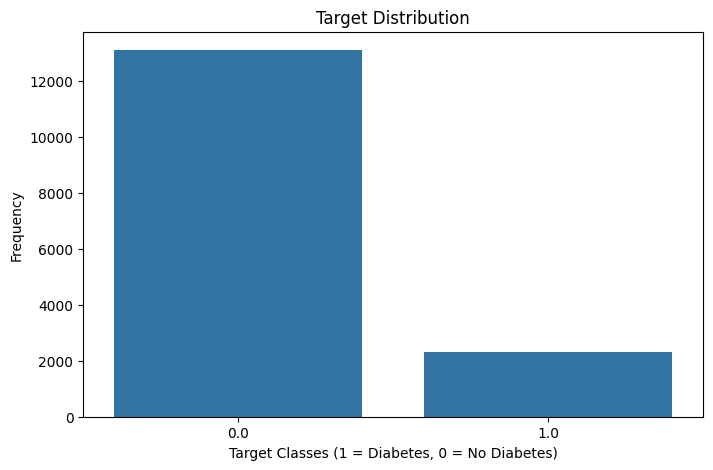

In [75]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Diabetes_diagnosticated"])  # Bar plot to count target classes
plt.xlabel("Target Classes (1 = Diabetes, 0 = No Diabetes)")
plt.ylabel("Frequency")
plt.title("Target Distribution")
plt.savefig("../img/target_distribution.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### 🧾 Summary of Engineered Features

| Feature Name            | Description                                                                 |
|-------------------------|-----------------------------------------------------------------------------|
| `BMI`                   | Body Mass Index calculated from weight and height.                         |
| `CHOL_ratio`            | Total Cholesterol / HDL ratio (indicator of cardiovascular risk).          |
| `Age_group`             | Age grouped into clinical categories: child, young adult, adult, senior.   |
| `BMI_category`          | BMI categorized as underweight, normal, overweight, or obese (WHO).        |
| `High_cholesterol`      | Binary flag for total cholesterol > 6.2 mmol/L.                            |
| `High_HbA1c`            | Binary flag for HbA1c ≥ 6.5% (diabetes diagnosis threshold).               |
| `BMI_HbA1c`             | Interaction term: BMI × HbA1c.                                              |
| `High_insulin`          | Binary flag for insulin > 90 pmol/L (possible insulin resistance).         |
| `Cardio_risk`           | Cumulative score (0–4) based on age > 60, obesity, high cholesterol, and hypertension. |


In [76]:
# BMI calculation (Body Mass Index)
df['BMI'] = df['Weight(kg)'] / (df['Height(m)'] ** 2)

# Total Cholesterol / HDL ratio (cardiovascular risk indicator)
df['CHOL_ratio'] = df['Total_Cholesterol(mmol/L)'] / df['HDL-Cholesterol(mmol/L)']

# Group age into clinical categories
def age_group(age):
    if age < 18:
        return 1.0  # 'child'
    elif age < 40:
        return 2.0  # 'young_adult'
    elif age < 60:
        return 3.0  # 'adult'
    else:
        return 4.0  # 'senior'
df['Age_group'] = df['Age(year)'].apply(age_group)

# BMI categories based on WHO standards
def bmi_category(bmi):
    if bmi < 18.5:
        return 1.0  # 'underweight'
    elif bmi < 25:
        return 2.0  # 'normal'
    elif bmi < 30:
        return 3.0  # 'overweight'
    else:
        return 4.0  # 'obese'
df['BMI_category'] = df['BMI'].apply(bmi_category)

# Binary indicator of high total cholesterol
df['High_cholesterol'] = (df['Total_Cholesterol(mmol/L)'] > 6.2).astype(int)

# Binary indicator of elevated HbA1c (≥ 6.5% → diabetes diagnosis)
df['High_HbA1c'] = (df['Glycohemoglobin(%)'] >= 6.5).astype(int)

# Interaction term: BMI × HbA1c
df['BMI_HbA1c'] = df['BMI'] * df['Glycohemoglobin(%)']

# Binary indicator of high insulin levels (possible insulin resistance)
df['High_insulin'] = (df['Insulin_(pmol/L)'] > 90).astype(int)

# Simple cardiovascular risk score (older age, high BMI, high cholesterol, hypertension)
df['Cardio_risk'] = (
    (df['Age(year)'] > 60).astype(int) +
    (df['BMI'] > 30).astype(int) +
    (df['Total_Cholesterol(mmol/L)'] > 6.2).astype(int) +
    (df['High_blood_pressure?'] == 1).astype(int)
)

df.head()

# Export cleaned dataset
df.to_csv("../data/Train_data/train_data_cleaned.csv", index=False)


### Split in train and test

In [77]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(target, axis=1),
                                                    df[target],
                                                    test_size=0.2,
                                                    random_state=42)

### Describe variables

In [78]:
tds.describe_df(X_train)

COL_N           Gender Age(year)     Race Country_of_birth Income_category  \
DATA_TYPE      float64   float64  float64          float64         float64   
MISSINGS (%)       0.0       0.0      0.0              0.0             0.0   
UNIQUE_VALUES        2        68        5                2               5   
CARDIN (%)         0.0      0.01      0.0              0.0             0.0   

COL_N         Height(m) Weight(kg) HDL-Cholesterol(mmol/L)  \
DATA_TYPE       float64    float64                 float64   
MISSINGS (%)        0.0        0.0                     0.0   
UNIQUE_VALUES        33        282                     135   
CARDIN (%)          0.0       0.02                    0.01   

COL_N         Total_Cholesterol(mmol/L) Glycohemoglobin(%)  ...  \
DATA_TYPE                       float64            float64  ...   
MISSINGS (%)                        0.0                0.0  ...   
UNIQUE_VALUES                       290                109  ...   
CARDIN (%)                         0.02               0.01  ...   

COL_N         100_cigarrettes_life?      BMI CHOL_ratio Age_group  \
DATA_TYPE                   float64  float64    float64   float64   
MISSINGS (%)                    0.0      0.0        0.0       0.0   
UNIQUE_VALUES                     2     2450       6329         3   
CARDIN (%)                      0.0      0.2       0.51       0.0   

COL_N         BMI_category High_cholesterol High_HbA1c BMI_HbA1c High_insulin  \
DATA_TYPE          float64            int32      int32   float64        int32   
MISSINGS (%)           0.0              0.0        0.0       0.0          0.0   
UNIQUE_VALUES            4                2          2      8686            2   
CARDIN (%)             0.0              0.0        0.0       0.7          0.0   

COL_N         Cardio_risk  
DATA_TYPE           int32  
MISSINGS (%)          0.0  
UNIQUE_VALUES           5  
CARDIN (%)            0.0  

[4 rows x 22 columns]

In [79]:
df_cardinalidad = tds.clasifica_variables(X_train,10,10)
df_cardinalidad

nombre_variable      tipo_sugerido
0                      Gender            Binaria
1                   Age(year)  Numérica Discreta
2                        Race         Categórica
3            Country_of_birth            Binaria
4             Income_category         Categórica
5                   Height(m)  Numérica Discreta
6                  Weight(kg)  Numérica Discreta
7     HDL-Cholesterol(mmol/L)  Numérica Discreta
8   Total_Cholesterol(mmol/L)  Numérica Discreta
9          Glycohemoglobin(%)  Numérica Discreta
10           Insulin_(pmol/L)  Numérica Discreta
11       High_blood_pressure?            Binaria
12      100_cigarrettes_life?            Binaria
13                        BMI  Numérica Discreta
14                 CHOL_ratio  Numérica Discreta
15                  Age_group         Categórica
16               BMI_category         Categórica
17           High_cholesterol            Binaria
18                 High_HbA1c            Binaria
19                  BMI_HbA1c  Numérica Discreta
20               High_insulin            Binaria
21                Cardio_risk         Categórica

### Establish features categorical and numerical

In [80]:
cat_features = df_cardinalidad['nombre_variable'][(df_cardinalidad['tipo_sugerido'] == 'Categórica') | (df_cardinalidad['tipo_sugerido'] == 'Binaria')].tolist()
num_features = df_cardinalidad['nombre_variable'][(df_cardinalidad['tipo_sugerido'] == 'Numérica Discreta')].tolist()
print(num_features)
print(cat_features)

['Age(year)', 'Height(m)', 'Weight(kg)', 'HDL-Cholesterol(mmol/L)', 'Total_Cholesterol(mmol/L)', 'Glycohemoglobin(%)', 'Insulin_(pmol/L)', 'BMI', 'CHOL_ratio', 'BMI_HbA1c']
['Gender', 'Race', 'Country_of_birth', 'Income_category', 'High_blood_pressure?', '100_cigarrettes_life?', 'Age_group', 'BMI_category', 'High_cholesterol', 'High_HbA1c', 'High_insulin', 'Cardio_risk']


### Lineal correlation

In [81]:
corr = np.abs(df.corr()[target]).sort_values(ascending=True)
print(corr)

bad_corr_feat = corr[corr < 0.2].index.values
print(bad_corr_feat)

Country_of_birth             0.002217
Height(m)                    0.015959
Race                         0.015997
High_cholesterol             0.030837
Gender                       0.032860
CHOL_ratio                   0.040194
Income_category              0.043992
100_cigarrettes_life?        0.047556
Total_Cholesterol(mmol/L)    0.096073
HDL-Cholesterol(mmol/L)      0.119571
High_insulin                 0.126565
Insulin_(pmol/L)             0.161541
Weight(kg)                   0.171028
BMI_category                 0.190412
BMI                          0.200864
High_blood_pressure?         0.279285
Age(year)                    0.282112
Age_group                    0.283767
Cardio_risk                  0.314405
BMI_HbA1c                    0.480956
Glycohemoglobin(%)           0.584311
High_HbA1c                   0.638080
Diabetes_diagnosticated      1.000000
Name: Diabetes_diagnosticated, dtype: float64
['Country_of_birth' 'Height(m)' 'Race' 'High_cholesterol' 'Gender'
 'CHOL_ratio'

### Feature importance with Random Forest

In [82]:

X = df.drop([target], axis = 1)
Y = df.Diabetes_diagnosticated

rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X, Y)

names = X.columns
scores = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True)
pd.DataFrame(scores, columns=['Score', 'Feature'])

Score                    Feature
0   0.4592         Glycohemoglobin(%)
1   0.0654  Total_Cholesterol(mmol/L)
2   0.0651           Insulin_(pmol/L)
3   0.0559                 CHOL_ratio
4   0.0459                  Age(year)
5   0.0453                  BMI_HbA1c
6   0.0381                 Weight(kg)
7   0.0379    HDL-Cholesterol(mmol/L)
8   0.0370                        BMI
9   0.0339                 High_HbA1c
10  0.0327                  Height(m)
11  0.0189                       Race
12  0.0175            Income_category
13  0.0126       High_blood_pressure?
14  0.0099                Cardio_risk
15  0.0062      100_cigarrettes_life?
16  0.0050           Country_of_birth
17  0.0040                     Gender
18  0.0033                  Age_group
19  0.0028               BMI_category
20  0.0022               High_insulin
21  0.0011           High_cholesterol

### Statistic feature Importance

In [83]:

print(X.shape)
sel = SelectKBest(k=5)
X_new = sel.fit_transform(X, Y)
print(X_new.shape)
print(sel.scores_)

pd.DataFrame({'column': names, 'score': sel.scores_}).sort_values('score', ascending=False)

(15408, 22)
(15408, 5)
[1.66532100e+01 1.33214280e+03 3.94370019e+00 7.57481862e-02
 2.98734098e+01 3.92453601e+00 4.64215194e+02 2.23458495e+02
 1.43523168e+02 7.98674636e+03 4.12799430e+02 1.30332503e+03
 3.49201457e+01 6.47710125e+02 2.49291018e+01 1.34919005e+03
 5.79583179e+02 1.46637775e+01 1.05801415e+04 4.63610927e+03
 2.50800040e+02 1.68993954e+03]


column         score
18                 High_HbA1c  10580.141491
9          Glycohemoglobin(%)   7986.746365
19                  BMI_HbA1c   4636.109271
21                Cardio_risk   1689.939544
15                  Age_group   1349.190052
1                   Age(year)   1332.142802
11       High_blood_pressure?   1303.325027
13                        BMI    647.710125
16               BMI_category    579.583179
6                  Weight(kg)    464.215194
10           Insulin_(pmol/L)    412.799430
20               High_insulin    250.800040
7     HDL-Cholesterol(mmol/L)    223.458495
8   Total_Cholesterol(mmol/L)    143.523168
12      100_cigarrettes_life?     34.920146
4             Income_category     29.873410
14                 CHOL_ratio     24.929102
0                      Gender     16.653210
17           High_cholesterol     14.663777
2                        Race      3.943700
5                   Height(m)      3.924536
3            Country_of_birth      0.075748

### Logaritmic transformation

In [84]:
X_train['Insulin_(pmol/L)'] = np.log1p(X_train['Insulin_(pmol/L)'])
X_train['Glycohemoglobin(%)'] = np.log1p(X_train['Glycohemoglobin(%)'])
X_train['BMI'] = np.log1p(X_train['BMI'])
X_train['CHOL_ratio'] = np.log1p(X_train['CHOL_ratio'])
X_train['BMI_HbA1c'] = np.log1p(X_train['BMI_HbA1c'])
X_train['HDL-Cholesterol(mmol/L)'] = np.log1p(X_train['HDL-Cholesterol(mmol/L)'])
X_train['Total_Cholesterol(mmol/L)'] = np.log1p(X_train['Total_Cholesterol(mmol/L)'])

X_test['Insulin_(pmol/L)'] = np.log1p(X_test['Insulin_(pmol/L)'])
X_test['Glycohemoglobin(%)'] = np.log1p(X_test['Glycohemoglobin(%)'])
X_test['BMI'] = np.log1p(X_test['BMI'])
X_test['CHOL_ratio'] = np.log1p(X_test['CHOL_ratio'])
X_test['BMI_HbA1c'] = np.log1p(X_test['BMI_HbA1c'])
X_test['HDL-Cholesterol(mmol/L)'] = np.log1p(X_test['HDL-Cholesterol(mmol/L)'])
X_test['Total_Cholesterol(mmol/L)'] = np.log1p(X_test['Total_Cholesterol(mmol/L)'])

### Univariant analysis numeric features

c:\Users\rodri\Git_Repositories\ML_Insurance_Company_Health_Diabetes\ML_Insurance_Company_Health_Diabetes\src\result_notebooks\../utils\Toolbox_datascience.py:433: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, bins=bins, kde=kde, ax=ax, hue=df[hue] if hue else None, palette='coolwarm')
c:\Users\rodri\Git_Repositories\ML_Insurance_Company_Health_Diabetes\ML_Insurance_Company_Health_Diabetes\src\result_notebooks\../utils\Toolbox_datascience.py:433: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, bins=bins, kde=kde, ax=ax, hue=df[hue] if hue else None, palette='coolwarm')
c:\Users\rodri\Git_Repositories\ML_Insurance_Company_Health_Diabetes\ML_Insurance_Company_Health_Diabetes\src\result_notebooks\../utils\Toolbox_datascience.py:433: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, bins=bins, kde=kde, ax=ax, hue

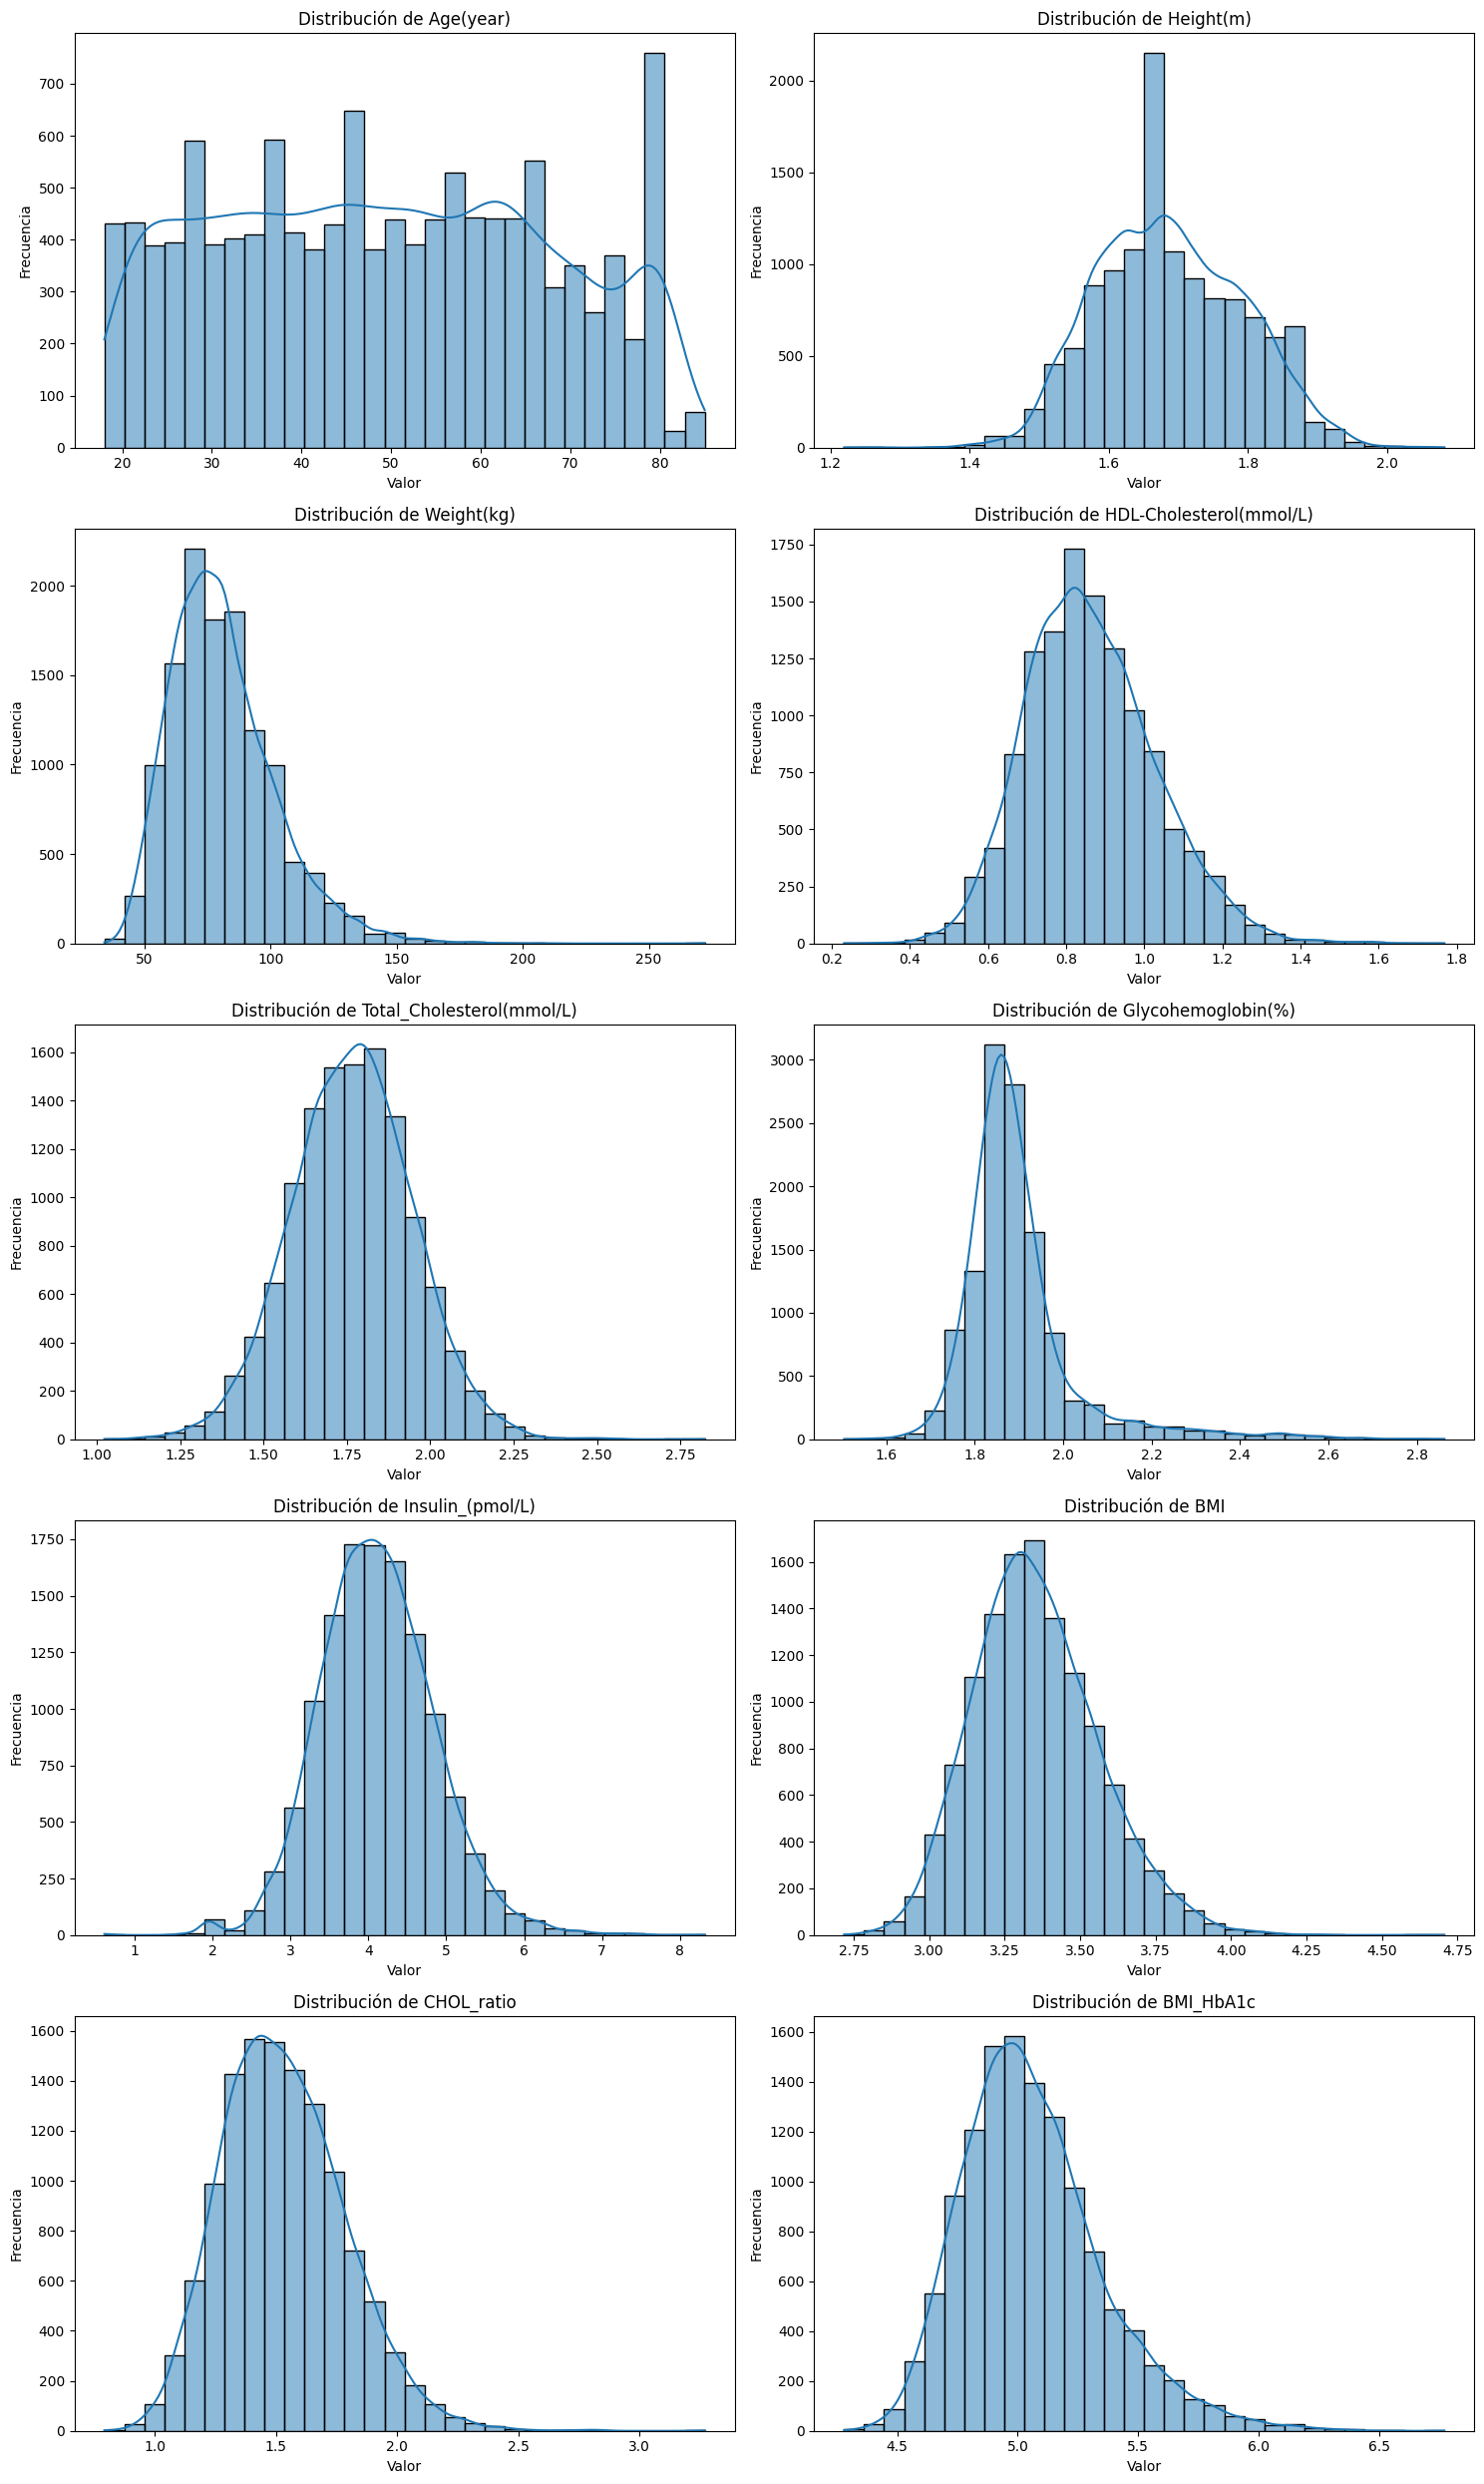

In [85]:
tds.pinta_distribucion_numericas(X_train, num_features)


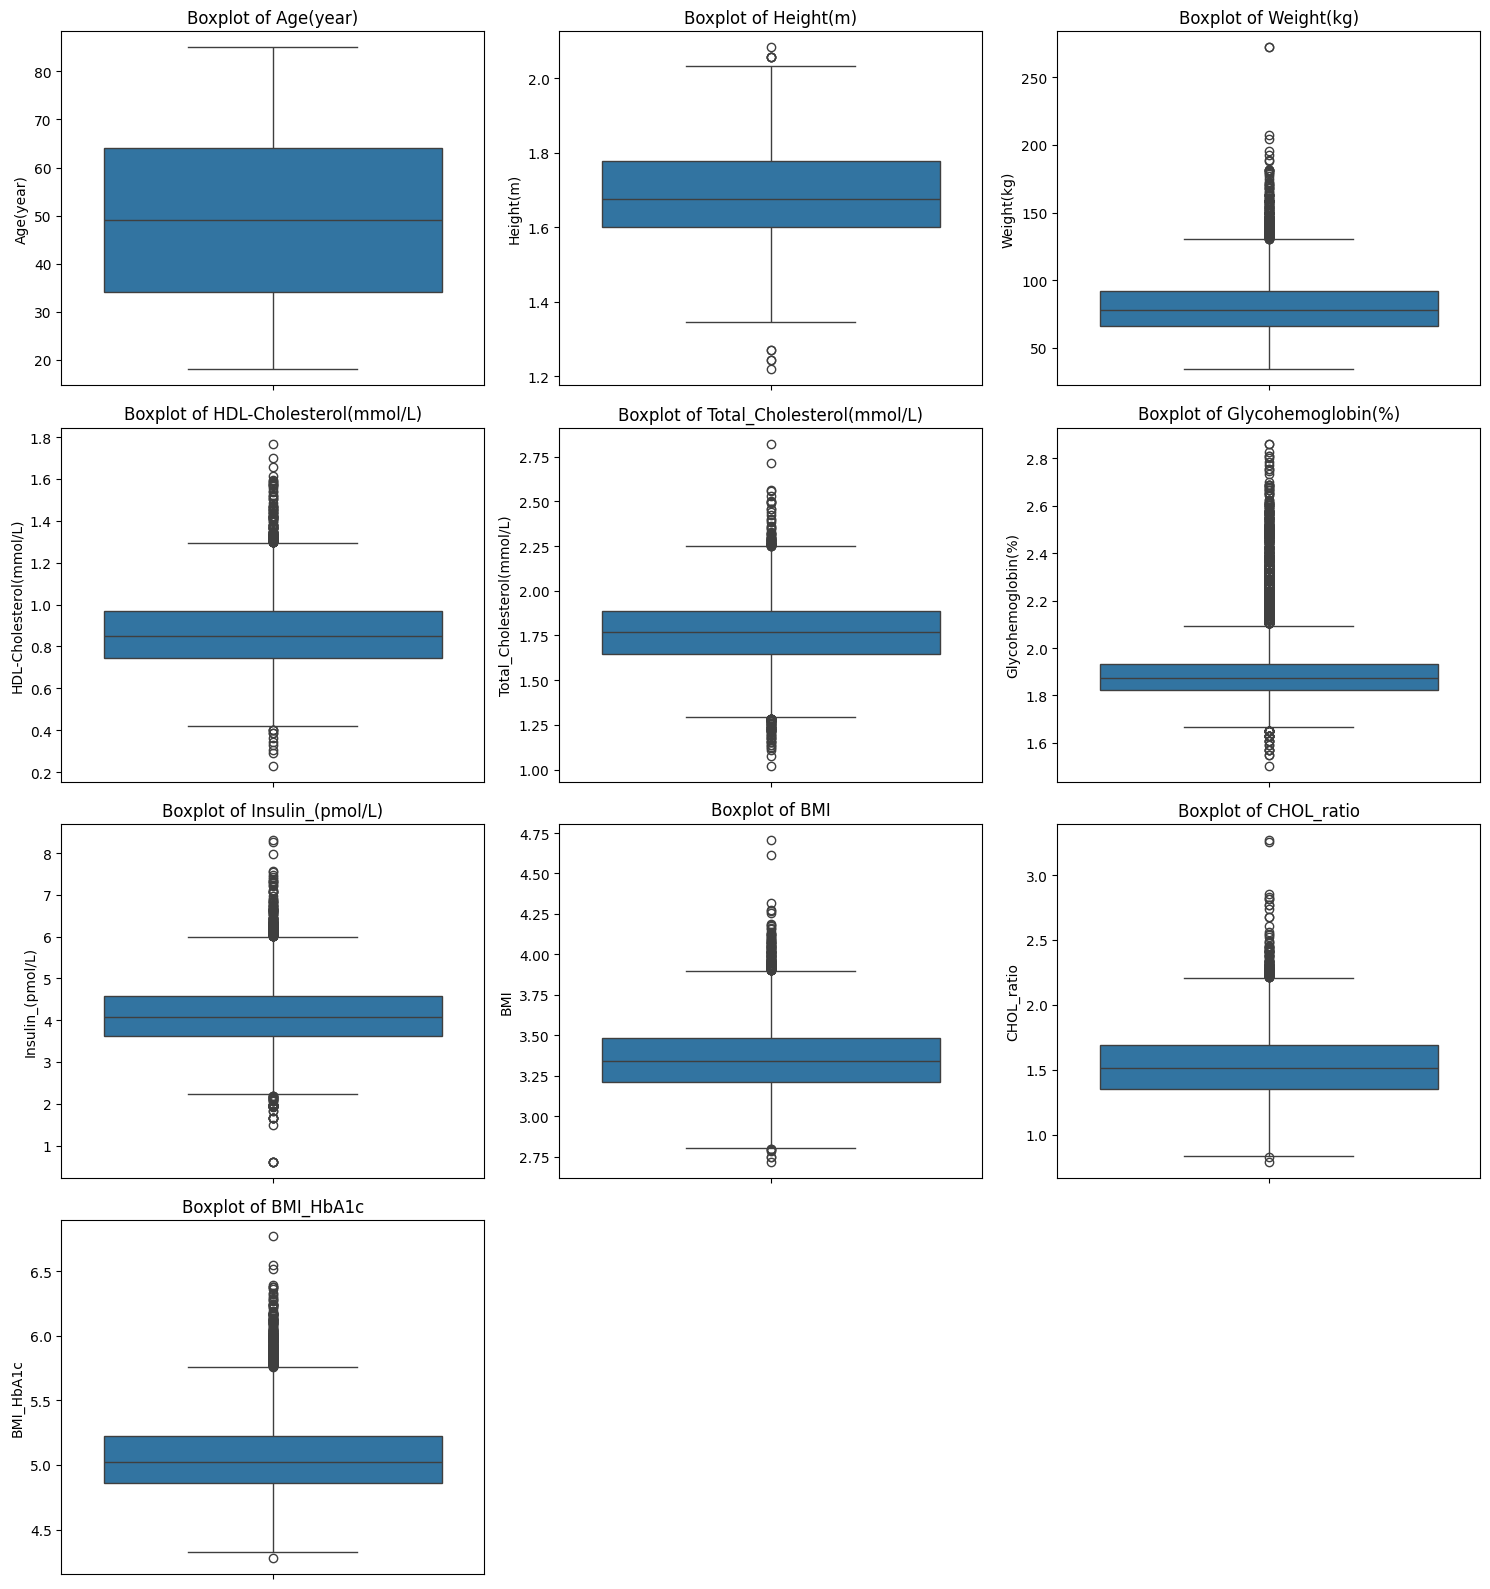

In [86]:
num_cols = X_train[num_features].columns

n_cols = 3  # Number of columns in the grid
n_rows = int(np.ceil(len(num_cols) / n_cols))  # Calculate the number of required rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

# Loop through each variable and create a boxplot in the corresponding position
for i, col in enumerate(num_cols):
    sns.boxplot(y=X_train[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")

# Hide any empty subplots (if more axes than columns)
for i in range(len(num_cols), len(axes)):
    fig.delaxes(axes[i])
      
plt.tight_layout()  
plt.savefig("../img/booxplot.png", dpi=300, bbox_inches='tight')
plt.show()


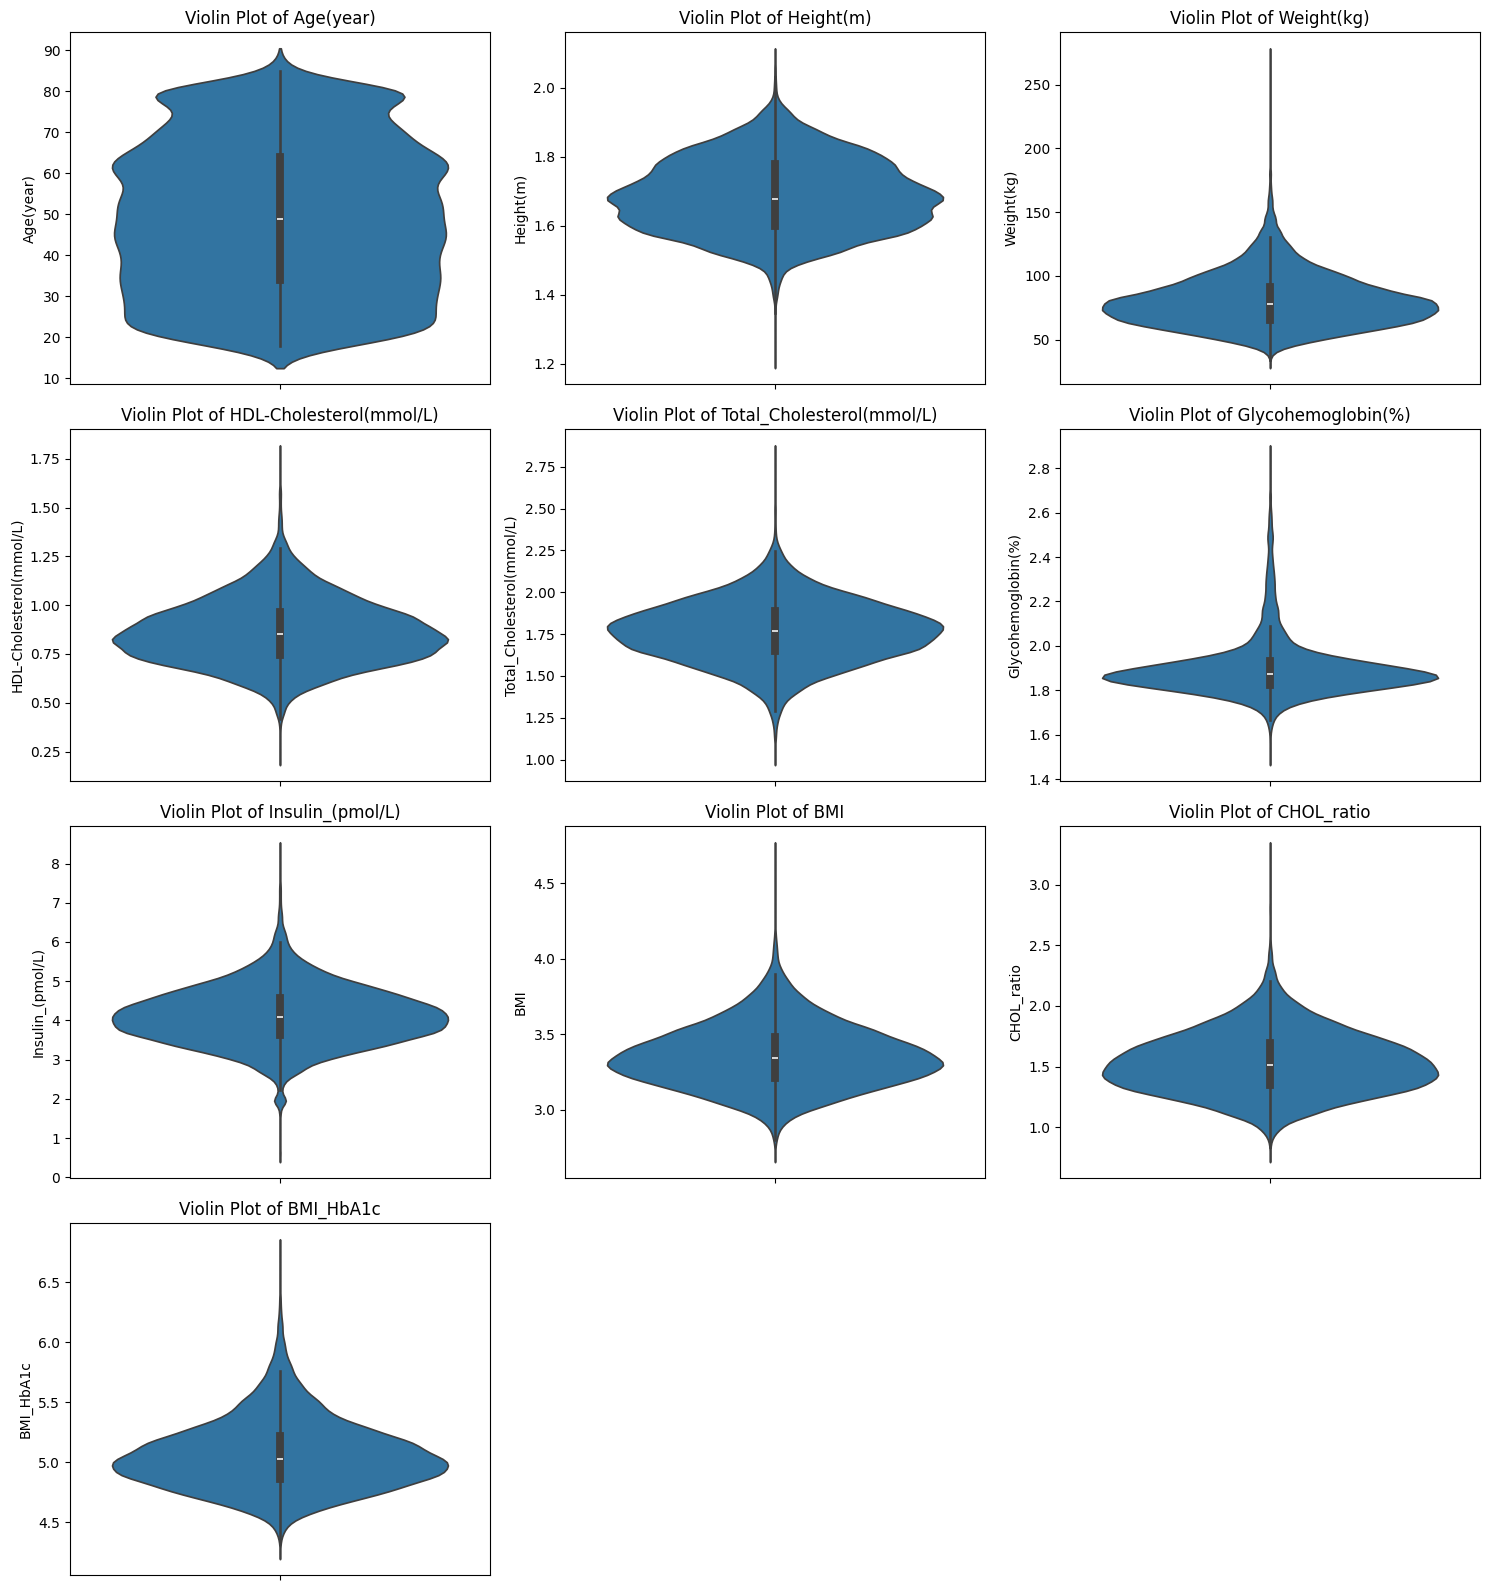

In [87]:
num_cols = X_train[num_features].columns

n_cols = 3  # Number of columns in the grid
n_rows = int(np.ceil(len(num_cols) / n_cols))  # Calculate the number of required rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

# Loop through each variable and create a violin plot in the corresponding position
for i, col in enumerate(num_cols):
    sns.violinplot(y=X_train[col], ax=axes[i])
    axes[i].set_title(f"Violin Plot of {col}")

# Hide empty subplots (if more axes than columns)
for i in range(len(num_cols), len(axes)):
    fig.delaxes(axes[i])  

plt.tight_layout()  #
plt.savefig("../img/violin.png", dpi=300, bbox_inches='tight')
plt.show()



### Univariant analysis for categorical features

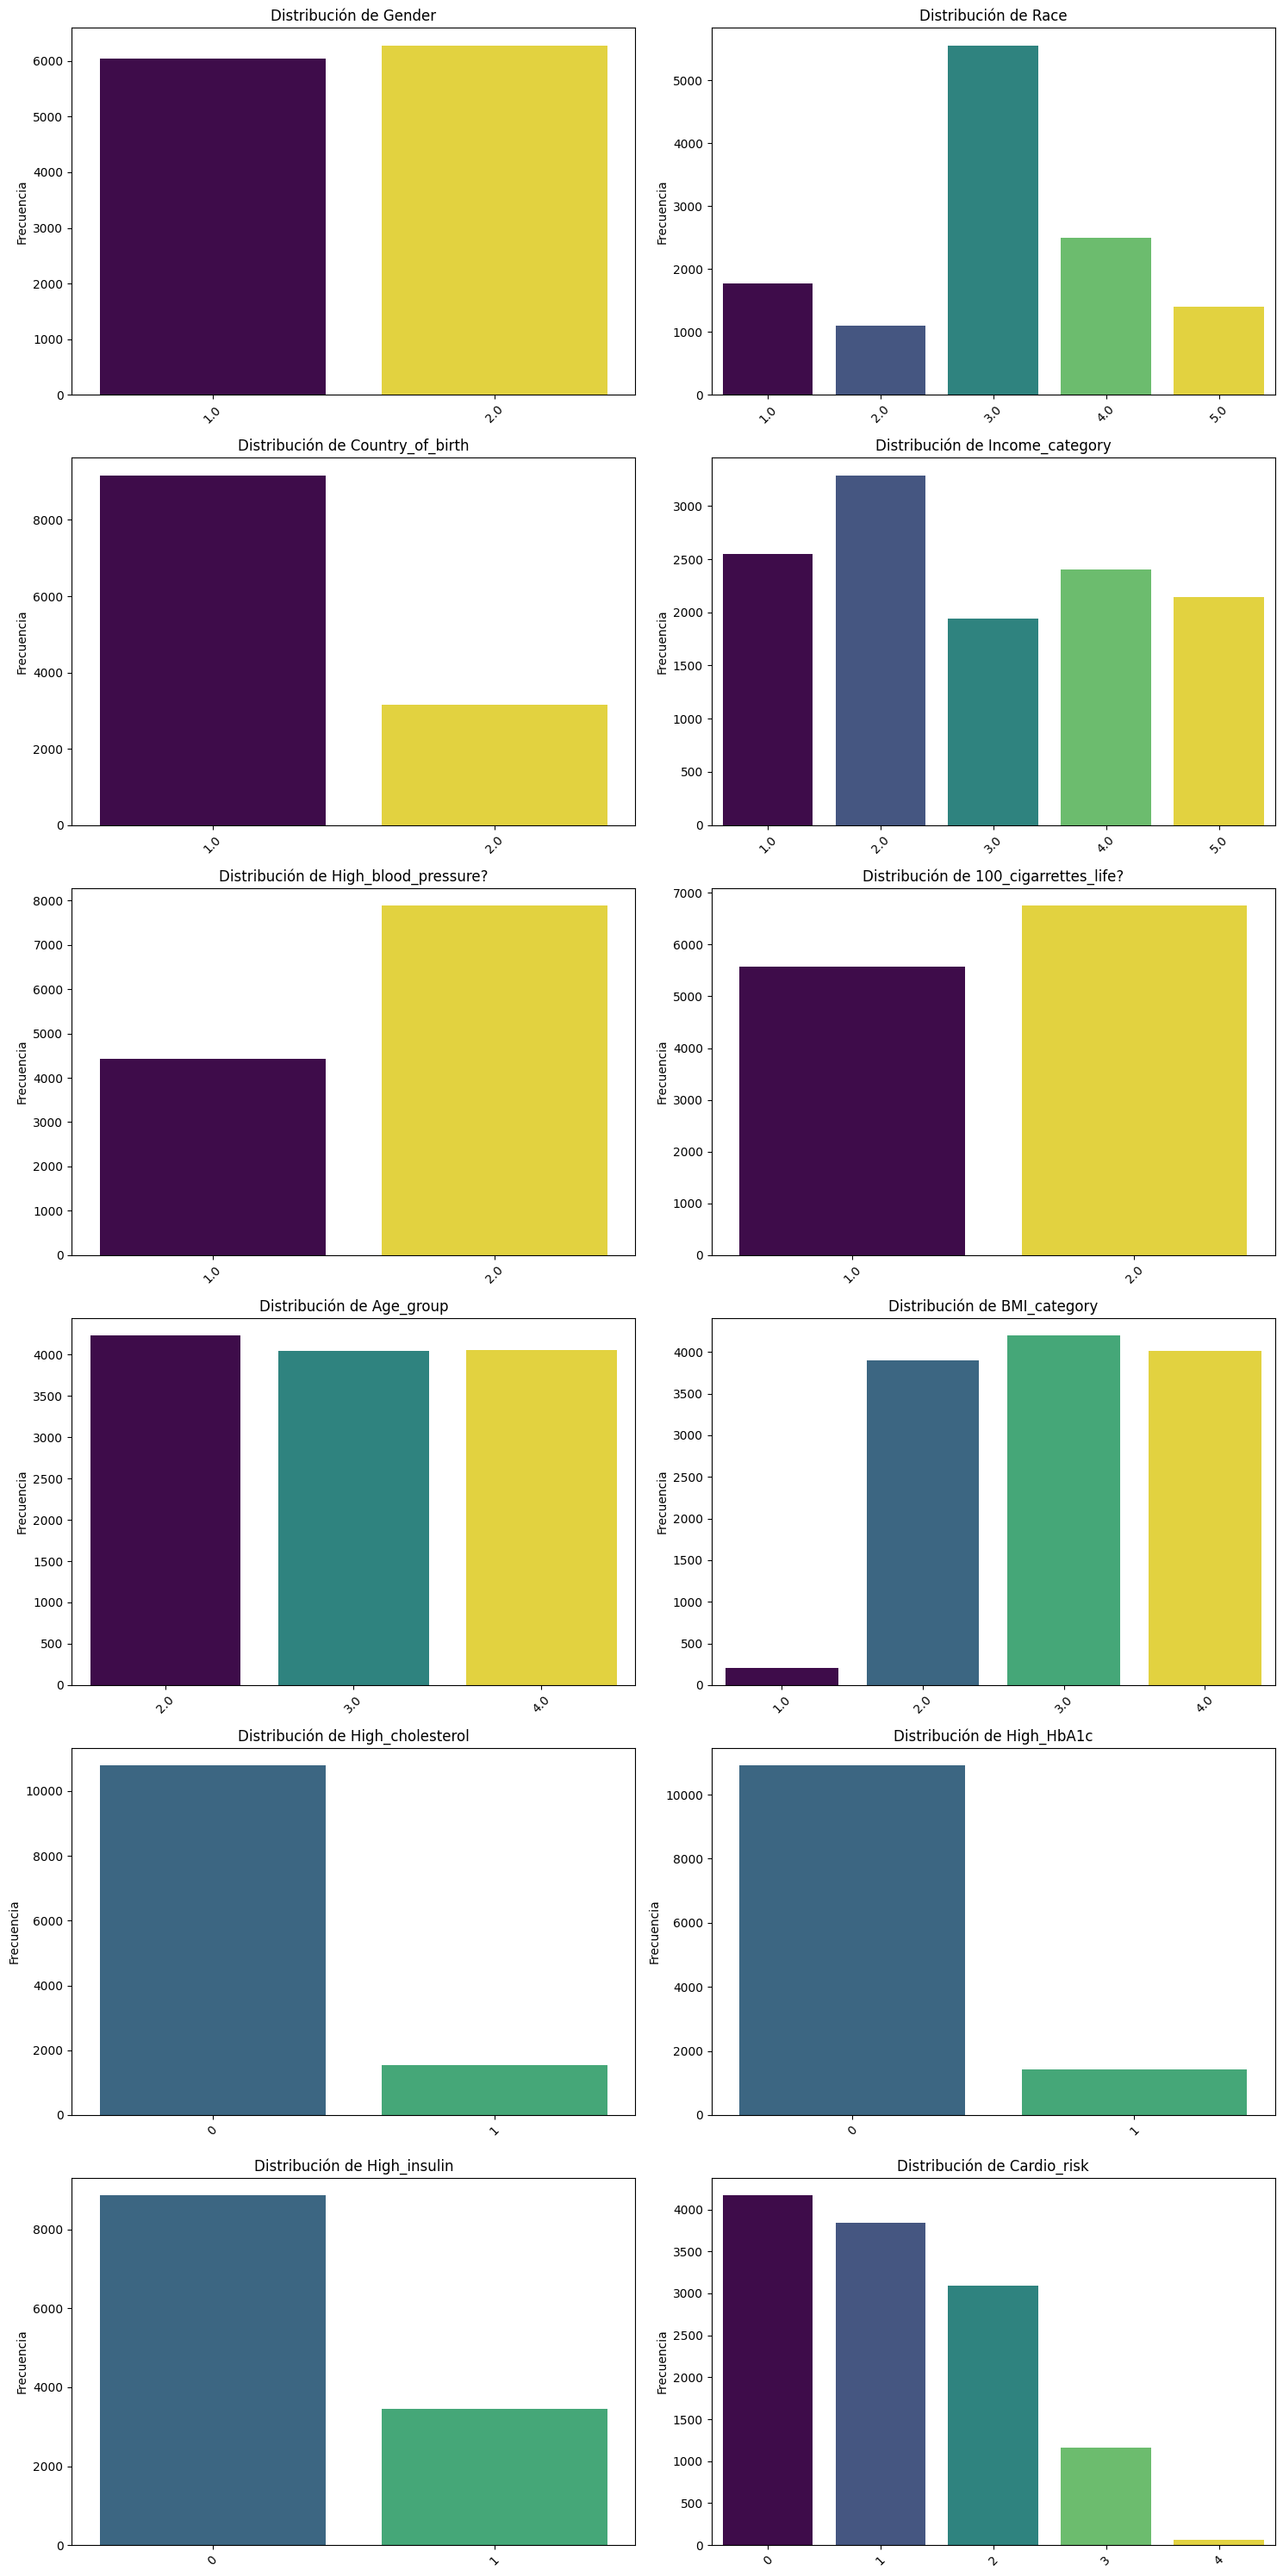

In [88]:
tds.pinta_distribucion_categoricas(X_train, cat_features)


### Bivariant analysis

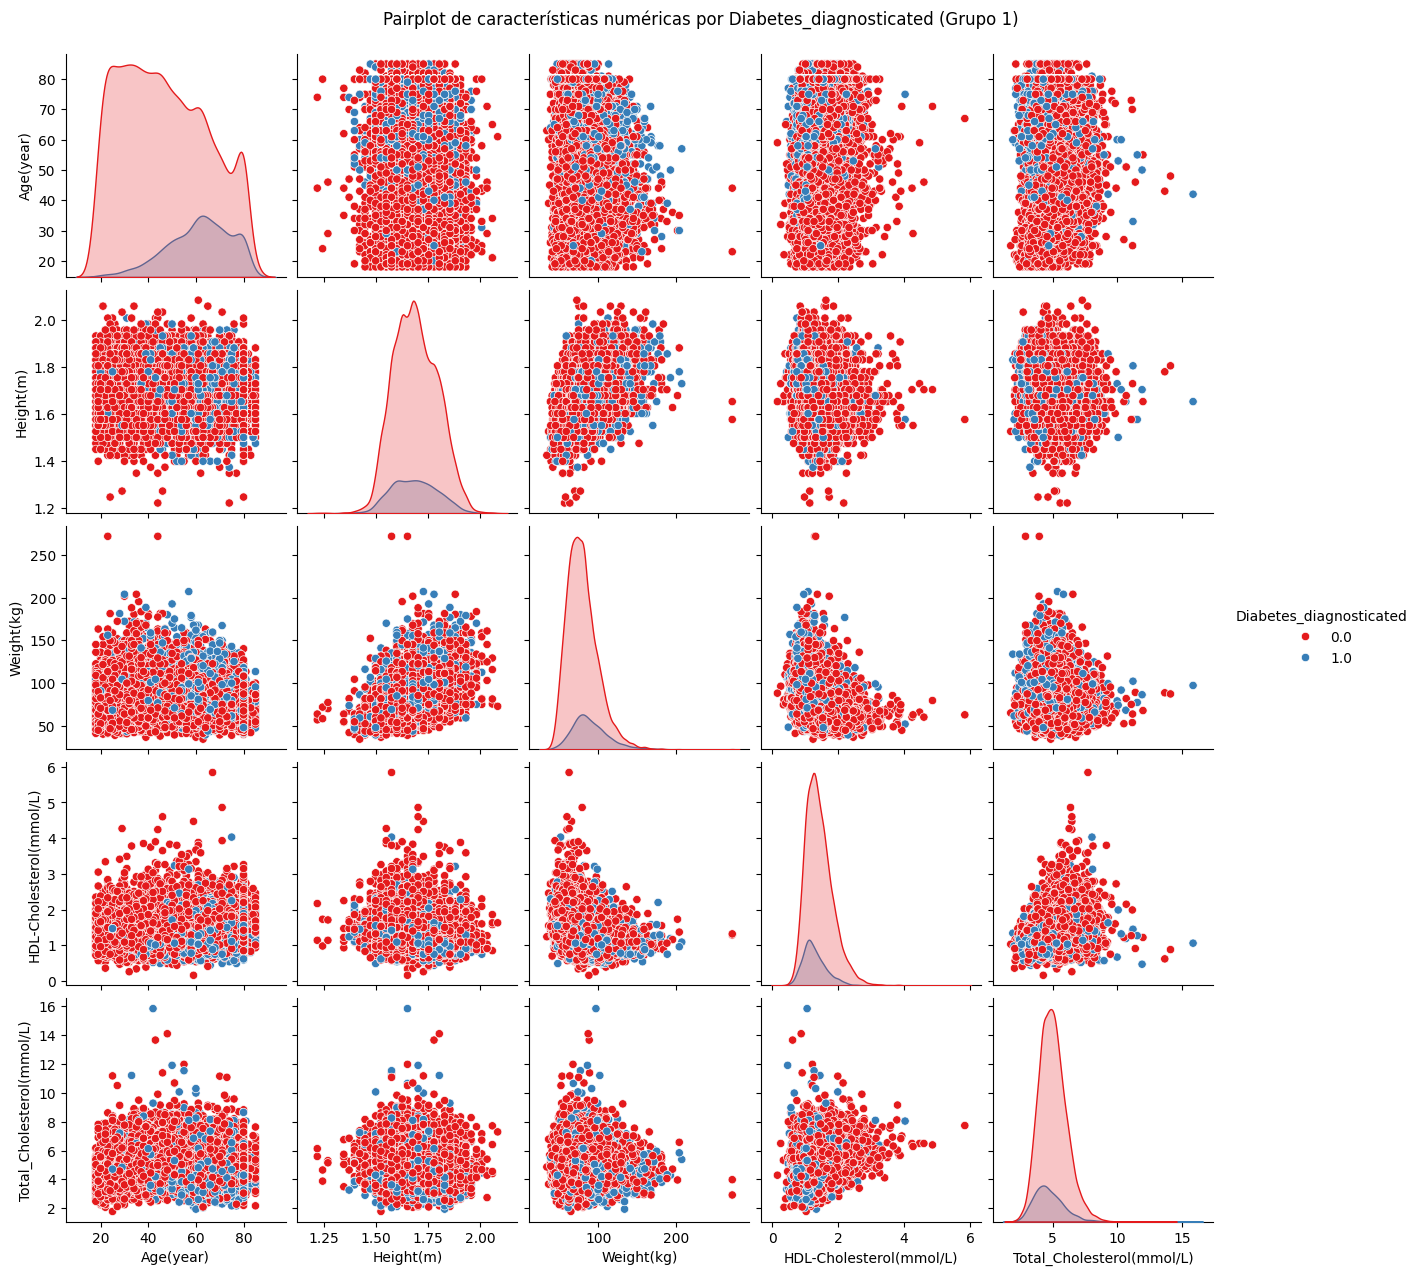

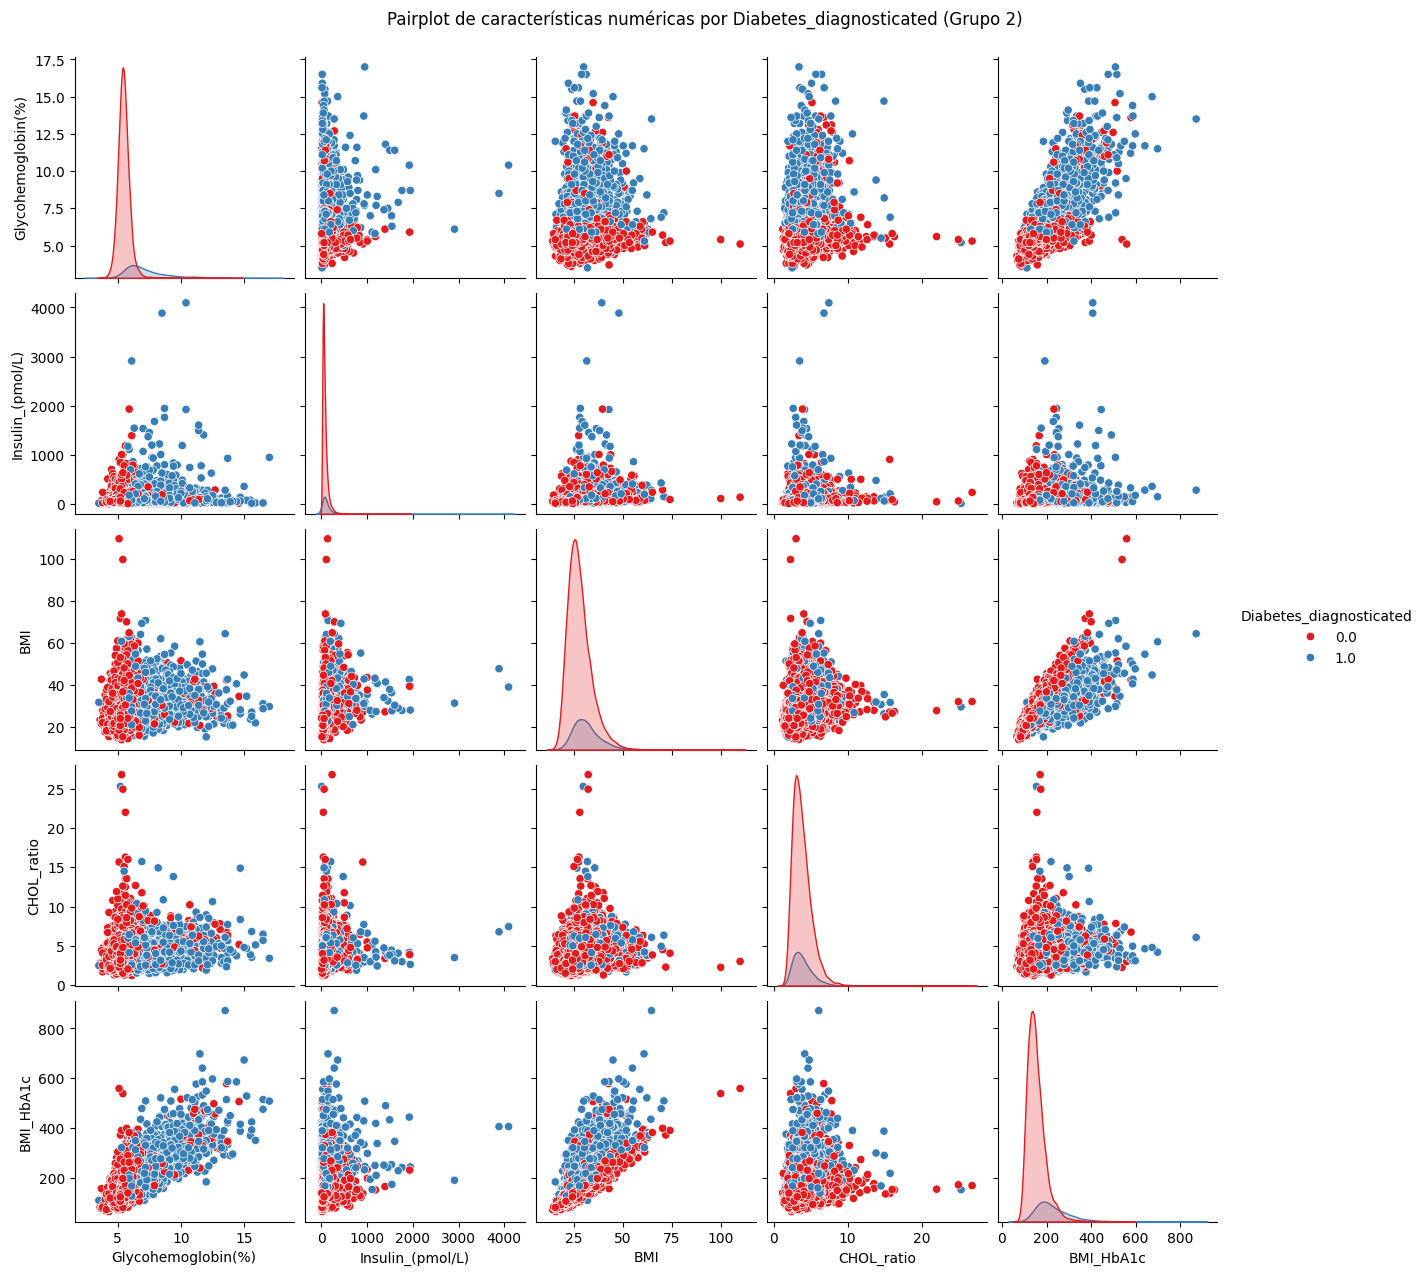

In [89]:
tds.plot_pairplots_by_category(df, num_columns=num_features, cat_column=target)


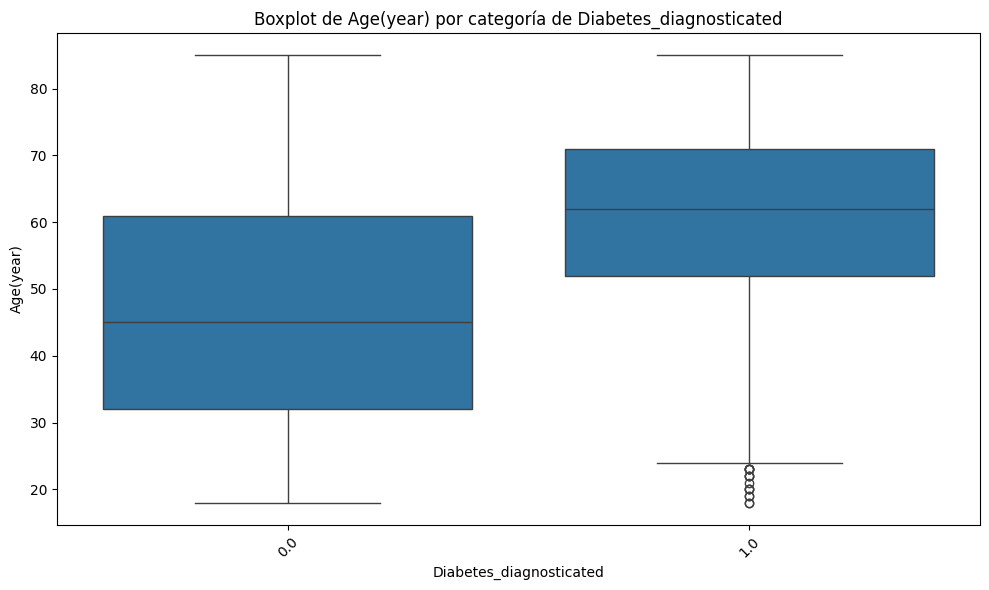

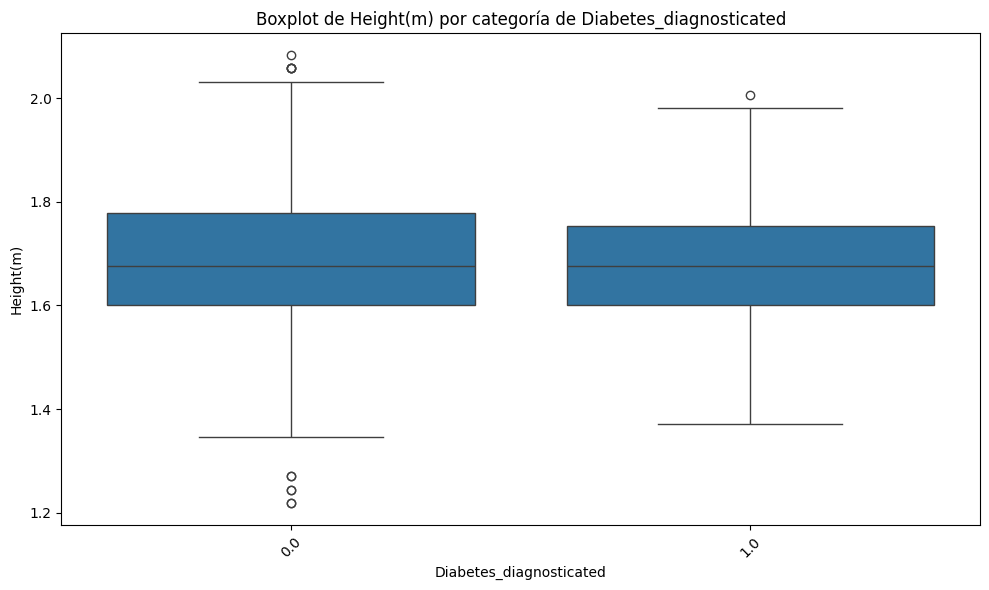

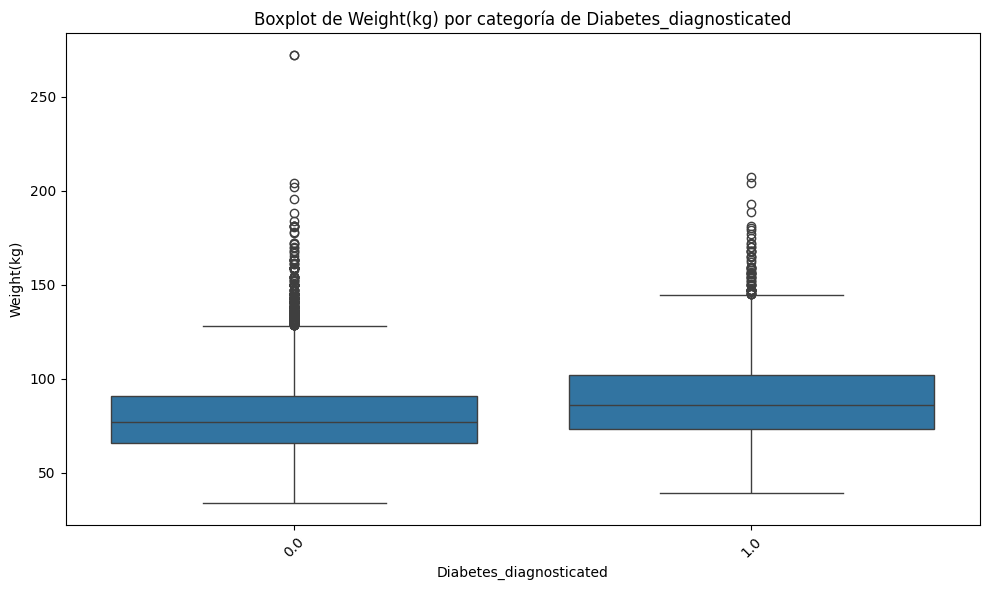

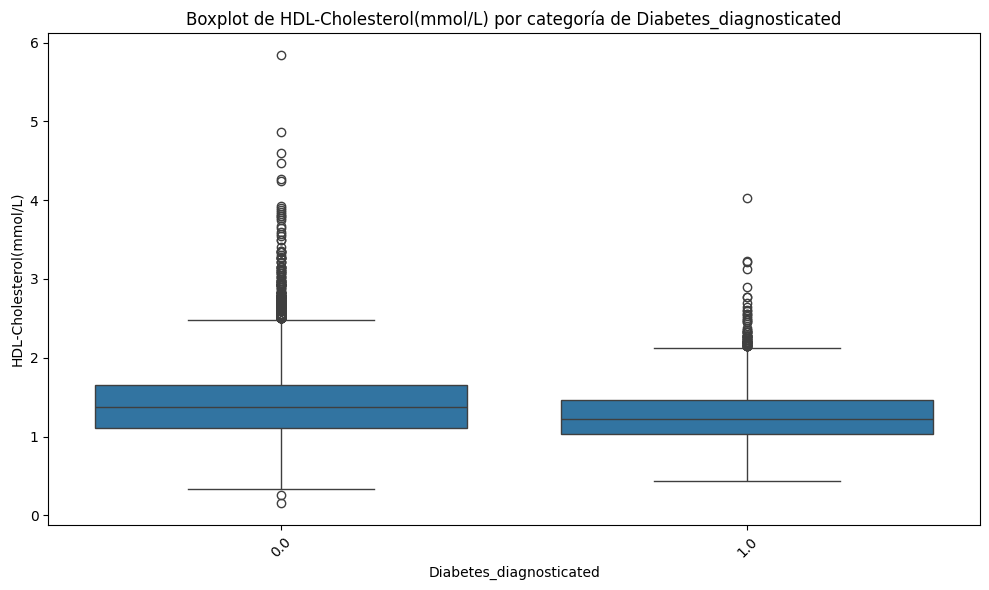

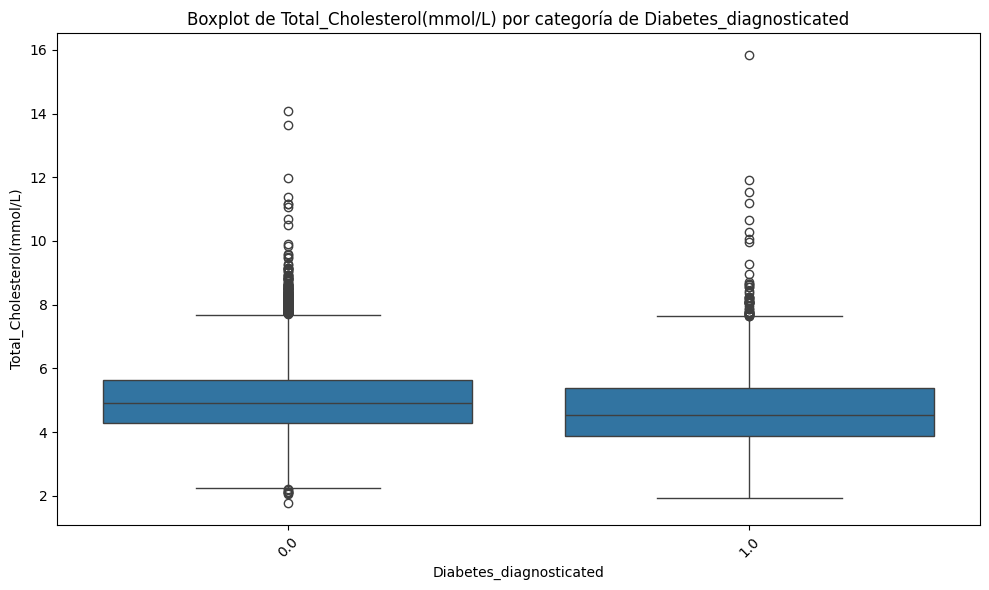

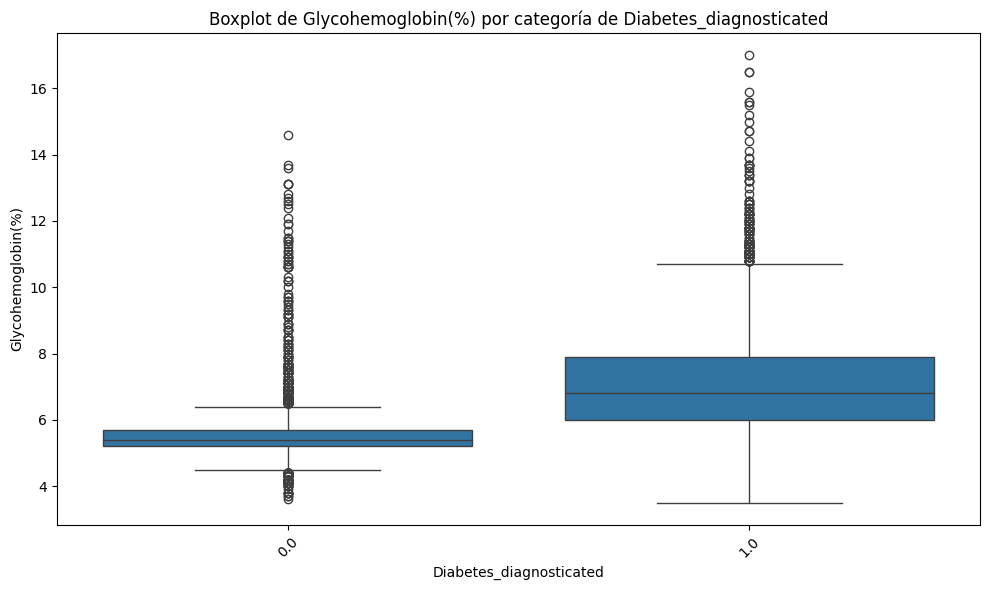

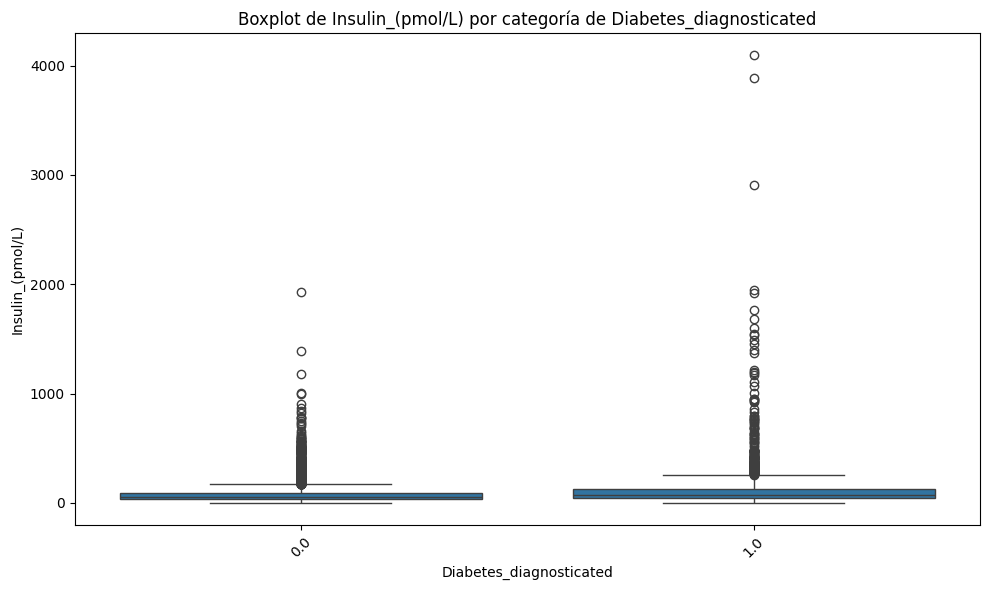

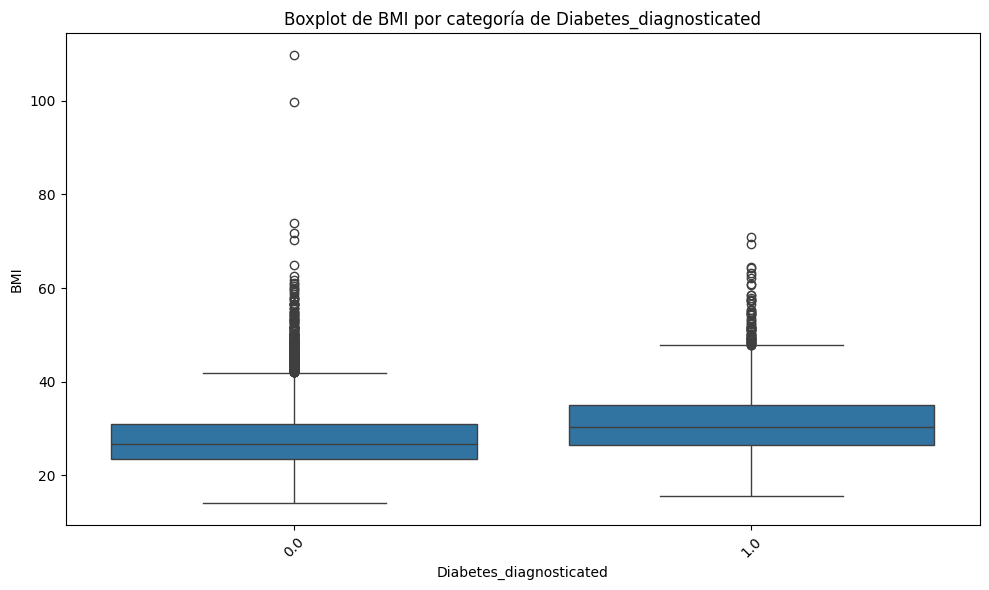

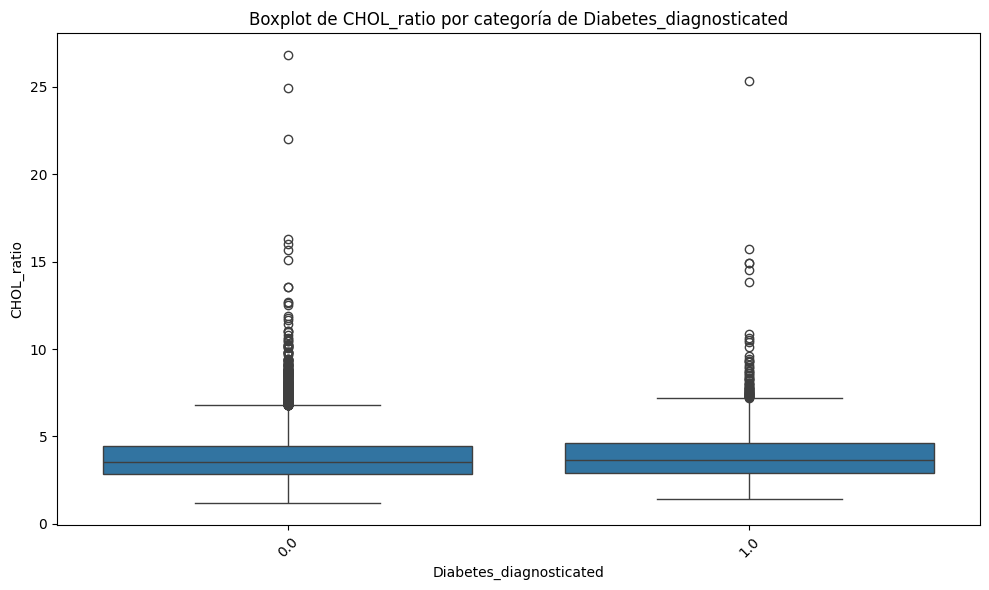

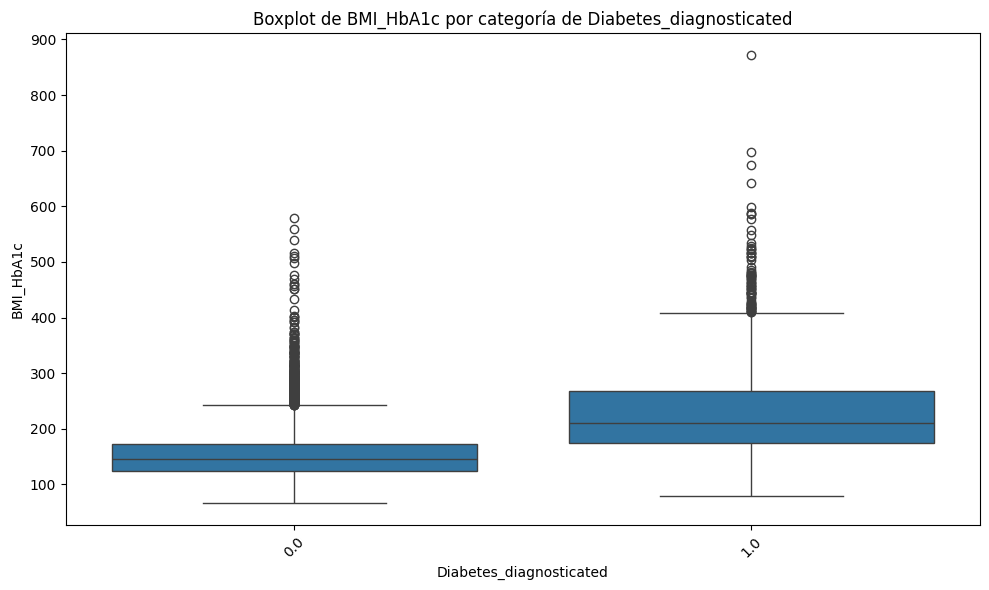

In [90]:
tds.plot_boxplots_by_category(df, num_features, cat_column=target)


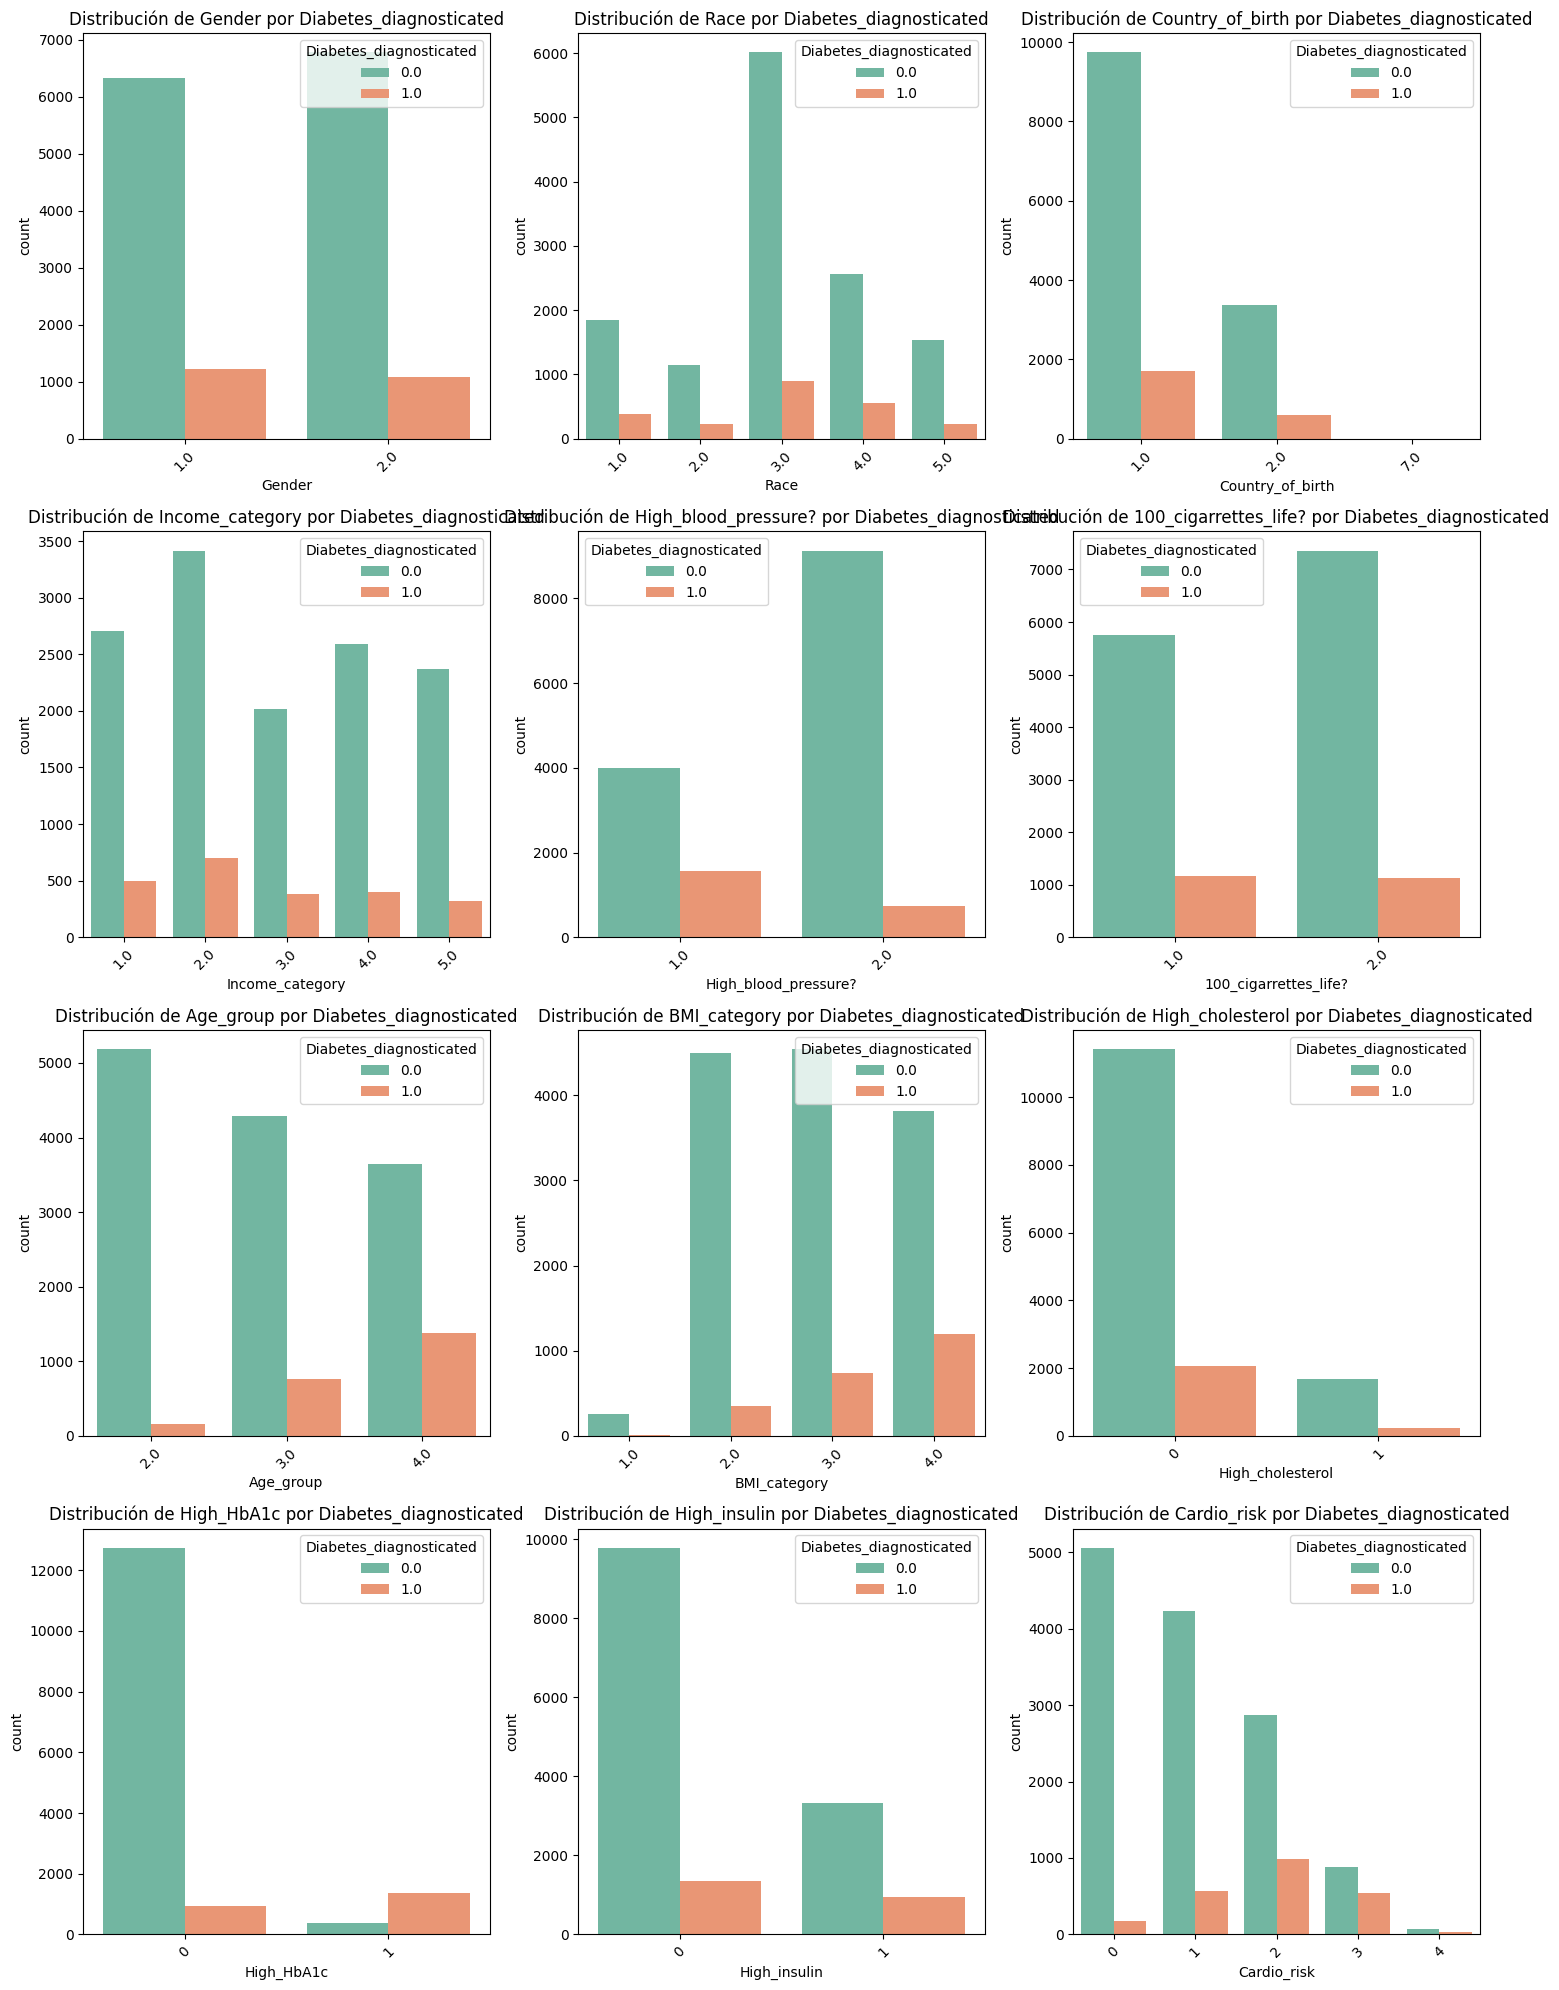

In [91]:
tds.plot_categorical_distribution_by_target(df, cat_features, target)


### Correlation matrix

interval columns not set, guessing: ['Gender', 'Age(year)', 'Race', 'Country_of_birth', 'Income_category', 'Height(m)', 'Weight(kg)', 'HDL-Cholesterol(mmol/L)', 'Total_Cholesterol(mmol/L)', 'Glycohemoglobin(%)', 'Insulin_(pmol/L)', 'High_blood_pressure?', '100_cigarrettes_life?', 'Diabetes_diagnosticated', 'BMI', 'CHOL_ratio', 'Age_group', 'BMI_category', 'High_cholesterol', 'High_HbA1c', 'BMI_HbA1c', 'High_insulin', 'Cardio_risk']


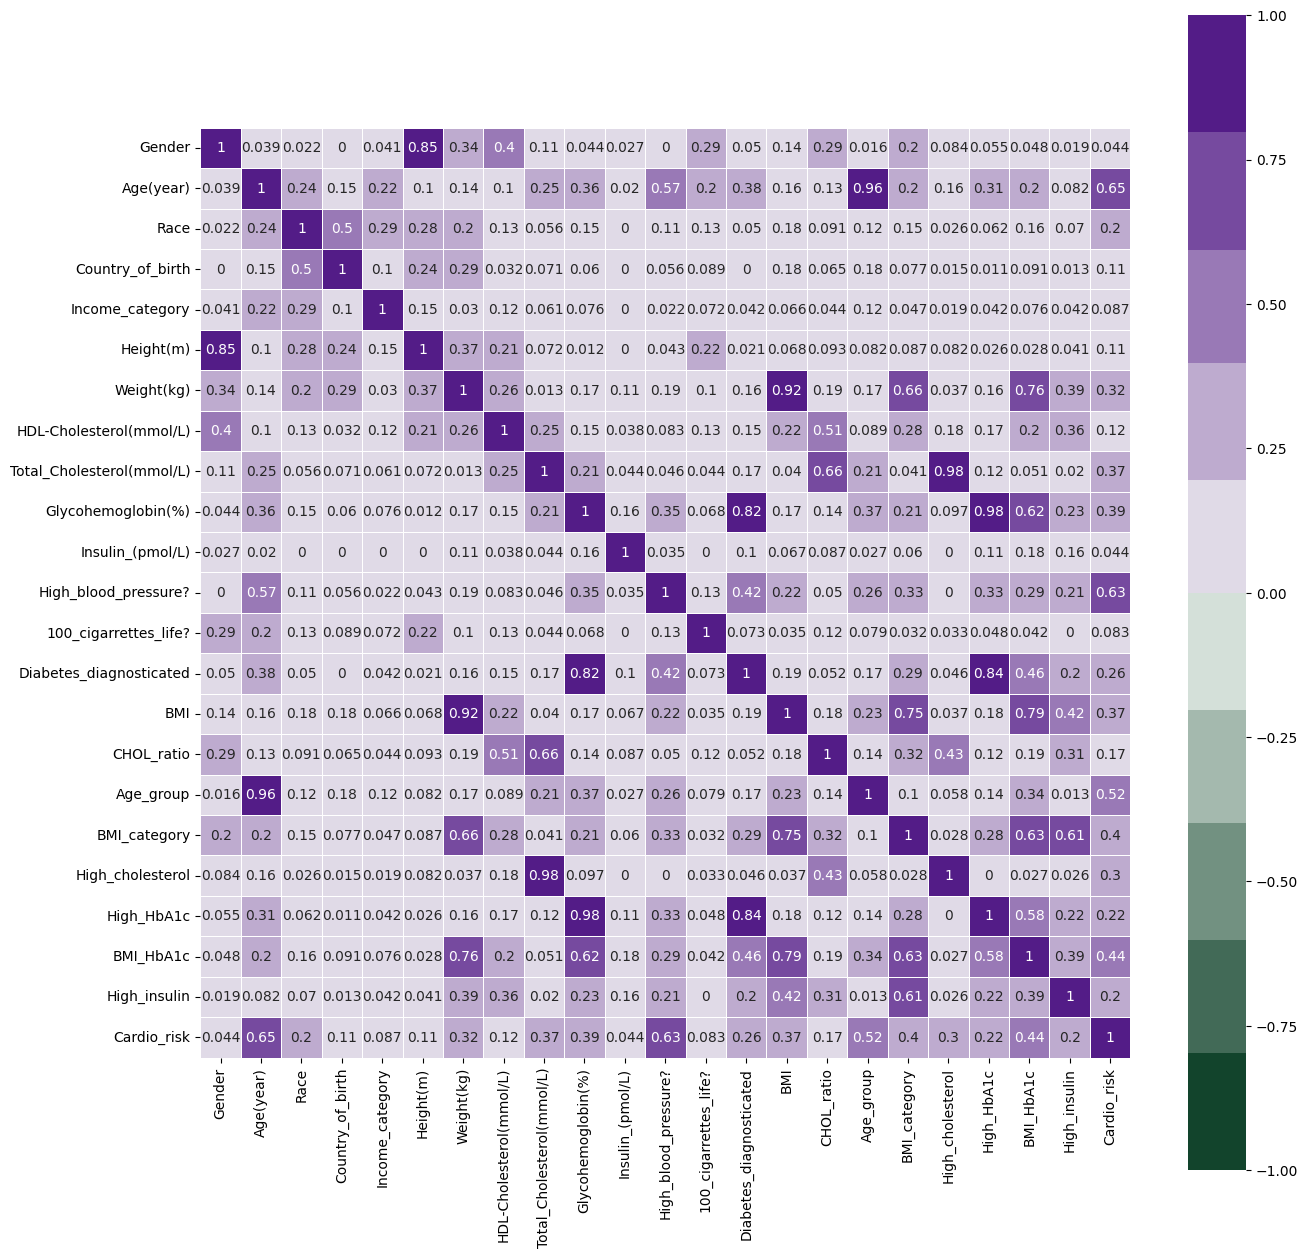

In [92]:

phik_matrix = df.phik_matrix()

plt.figure(figsize=(15,15))
sns.heatmap(phik_matrix,
            vmin=-1,
            vmax=1,
            center=0,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=10),
            square=True,
            annot=True,
            linewidths=.5);

plt.savefig("../img/correlation_matrix.png", dpi=300, bbox_inches='tight')


### Scaling

In [93]:
scaler = StandardScaler()

X_train_scaled_numeric = pd.DataFrame(
    scaler.fit_transform(X_train[num_features]),
    columns=num_features,
    index=X_train.index
)

X_test_scaled_numeric = pd.DataFrame(
    scaler.transform(X_test[num_features]),
    columns=num_features,
    index=X_test.index
)

X_train_final = pd.concat([X_train_scaled_numeric, X_train[cat_features]], axis=1)
X_test_final = pd.concat([X_test_scaled_numeric, X_test[cat_features]], axis=1)


In [94]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12326 entries, 32958.0 to 65298.0
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age(year)                  12326 non-null  float64
 1   Height(m)                  12326 non-null  float64
 2   Weight(kg)                 12326 non-null  float64
 3   HDL-Cholesterol(mmol/L)    12326 non-null  float64
 4   Total_Cholesterol(mmol/L)  12326 non-null  float64
 5   Glycohemoglobin(%)         12326 non-null  float64
 6   Insulin_(pmol/L)           12326 non-null  float64
 7   BMI                        12326 non-null  float64
 8   CHOL_ratio                 12326 non-null  float64
 9   BMI_HbA1c                  12326 non-null  float64
 10  Gender                     12326 non-null  float64
 11  Race                       12326 non-null  float64
 12  Country_of_birth           12326 non-null  float64
 13  Income_category            12326 non-null  

### 🧪 Model Evaluation Strategy

To evaluate the performance of our classification models, we will use **three different metrics** that are particularly suitable for imbalanced datasets:

- **Recall**: Measures the model's ability to correctly identify positive cases (i.e., patients diagnosed with diabetes). This is especially important in medical applications where false negatives can be critical.
- **F1-Score**: The harmonic mean of precision and recall, balancing both false positives and false negatives.
- **Average Precision (AP)**: A threshold-independent metric that summarizes the precision-recall curve, offering a more comprehensive view of model performance across decision thresholds.

> 🧰 These metrics are implemented in a custom evaluation function stored in the project toolbox. You can refer to it for more details or reuse it during training and validation.


Evaluating model: Logistic Regression using metric recall...
Evaluating model: SVC using metric recall...
Evaluating model: Decision Tree using metric recall...
Evaluating model: Random Forest using metric recall...
Evaluating model: KNN using metric recall...
Evaluating model: Gradient Boosting using metric recall...
Evaluating model: AdaBoost using metric recall...
Evaluating model: XGBoost using metric recall...
Evaluating model: LightGBM using metric recall...
Evaluating model: CatBoost using metric recall...

The best model is: Gradient Boosting with a mean recall of 0.6363

                 Model  Mean Recall
5    Gradient Boosting     0.636314
8             LightGBM     0.630894
9             CatBoost     0.628184
3        Random Forest     0.626558
6             AdaBoost     0.624932
7              XGBoost     0.624390
2        Decision Tree     0.613550
1                  SVC     0.606504
0  Logistic Regression     0.588618
4                  KNN     0.509485


c:\Users\rodri\Git_Repositories\ML_Insurance_Company_Health_Diabetes\ML_Insurance_Company_Health_Diabetes\src\result_notebooks\../utils\Toolbox_datascience.py:861: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f"Mean {scoring.capitalize()}", y="Model", data=results_df, palette="viridis")


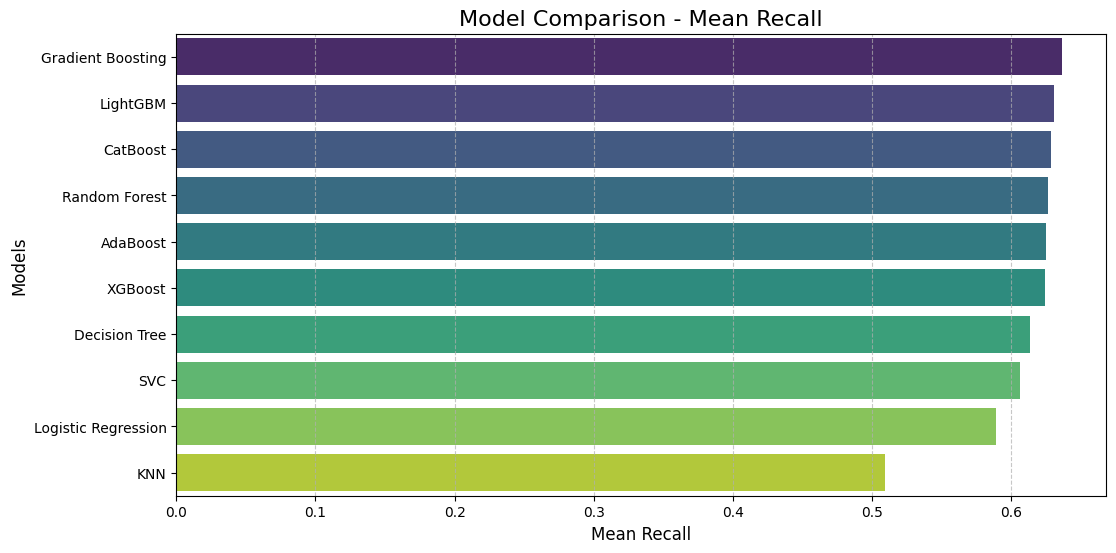

In [95]:
recall_models = tds.evaluate_classification_models(X_train_final, y_train, scoring="recall")


Evaluating model: Logistic Regression using metric f1...
Evaluating model: SVC using metric f1...
Evaluating model: Decision Tree using metric f1...
Evaluating model: Random Forest using metric f1...
Evaluating model: KNN using metric f1...
Evaluating model: Gradient Boosting using metric f1...
Evaluating model: AdaBoost using metric f1...
Evaluating model: XGBoost using metric f1...
Evaluating model: LightGBM using metric f1...
Evaluating model: CatBoost using metric f1...

The best model is: Gradient Boosting with a mean f1 of 0.7037

                 Model   Mean F1
5    Gradient Boosting  0.703741
3        Random Forest  0.701099
8             LightGBM  0.699034
9             CatBoost  0.698335
6             AdaBoost  0.690062
1                  SVC  0.686921
7              XGBoost  0.685437
0  Logistic Regression  0.682991
4                  KNN  0.613171
2        Decision Tree  0.596553


c:\Users\rodri\Git_Repositories\ML_Insurance_Company_Health_Diabetes\ML_Insurance_Company_Health_Diabetes\src\result_notebooks\../utils\Toolbox_datascience.py:861: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f"Mean {scoring.capitalize()}", y="Model", data=results_df, palette="viridis")


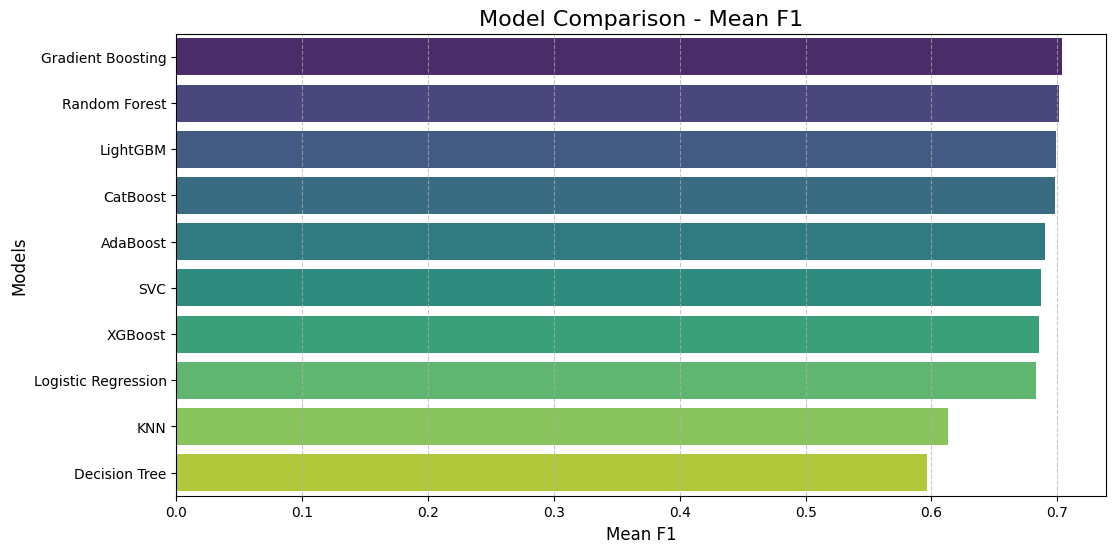

In [96]:
f1_models = tds.evaluate_classification_models(X_train_final, y_train, scoring="f1")
fig.savefig("../img/f1.png", dpi=300, bbox_inches='tight')

Evaluating model: Logistic Regression using metric average_precision...
Evaluating model: SVC using metric average_precision...
Evaluating model: Decision Tree using metric average_precision...
Evaluating model: Random Forest using metric average_precision...
Evaluating model: KNN using metric average_precision...
Evaluating model: Gradient Boosting using metric average_precision...
Evaluating model: AdaBoost using metric average_precision...
Evaluating model: XGBoost using metric average_precision...
Evaluating model: LightGBM using metric average_precision...
Evaluating model: CatBoost using metric average_precision...

The best model is: Gradient Boosting with a mean average_precision of 0.7719

                 Model  Mean Average_precision
5    Gradient Boosting                0.771859
9             CatBoost                0.771633
8             LightGBM                0.762719
3        Random Forest                0.758255
1                  SVC                0.751056
0  Logisti

c:\Users\rodri\Git_Repositories\ML_Insurance_Company_Health_Diabetes\ML_Insurance_Company_Health_Diabetes\src\result_notebooks\../utils\Toolbox_datascience.py:861: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f"Mean {scoring.capitalize()}", y="Model", data=results_df, palette="viridis")


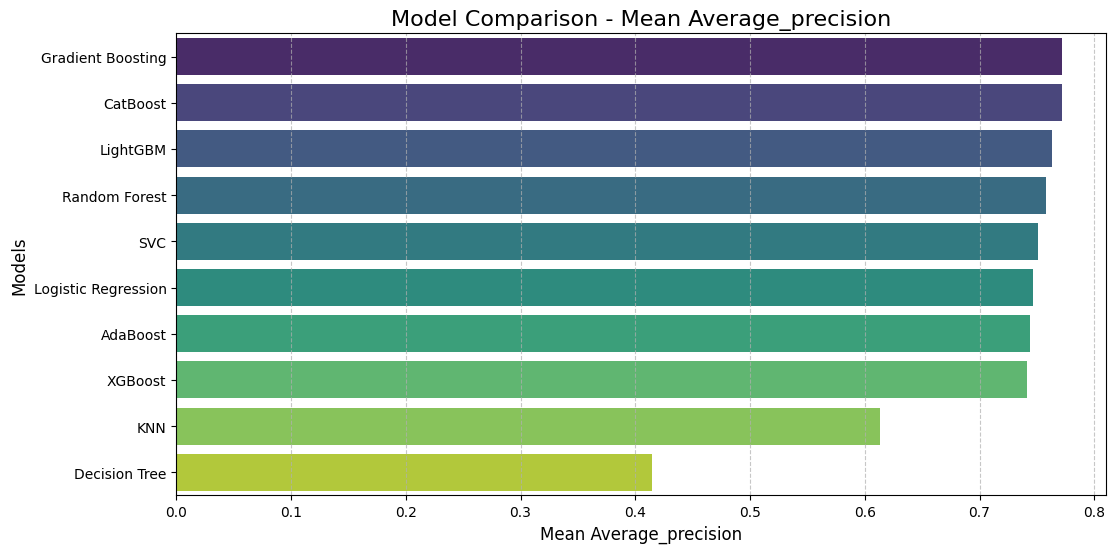

In [97]:
average_precision_models = tds.evaluate_classification_models(X_train_final, y_train, scoring="average_precision")
fig.savefig("../img/average_precision.png", dpi=300, bbox_inches='tight')

### 🔍 Hyperparameter Tuning and Model Optimization

To improve the performance of our classifiers and reduce the risk of underfitting or overfitting, we applied **RandomizedSearchCV** to perform hyperparameter tuning on three different tree-based models:

1. **Gradient Boosting (sklearn)**
2. **LightGBM**
3. **CatBoost**

Each model was tested using a custom parameter grid designed to explore a diverse range of configurations:

- Number of estimators
- Learning rate
- Tree depth and leaf size
- Sampling strategies (row/column)
- Regularization parameters
- Class balancing with `scale_pos_weight` to address class imbalance

We used **5-fold cross-validation** to evaluate performance and selected the best configuration using the **F1-score** as the main scoring metric, due to the **imbalanced nature of our target variable** (diabetes diagnosis).

Once the best models were found, we evaluated them on the test set using `classification_report()` to obtain detailed metrics including **precision**, **recall**, and **F1-score**.


In [98]:
param_grid_gb = {
    'n_estimators': np.arange(50, 300, 25),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]  # <- fixed here
}

# Weight to balance positive and negative classes
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

param_grid_lgb = {
    'n_estimators': np.arange(50, 150, 25),            
    'learning_rate': np.linspace(0.03, 0.1, 4),         
    'num_leaves': [20, 31, 40],                        
    'max_depth': [4, 5, 6],                            
    'subsample': [0.7, 0.8],                           
    'colsample_bytree': [0.6, 0.8],                     
    'reg_alpha': [0.0, 0.1],                            
    'reg_lambda': [0.0, 0.1],                          
    'scale_pos_weight': [scale_pos_weight]            
}

param_grid_cat = {
    'iterations': np.arange(300, 600, 50),
    'learning_rate': np.linspace(0.01, 0.1, 6),
    'depth': [4, 6, 8],
    'l2_leaf_reg': [3, 5, 7],
    'border_count': [32, 64],
    'bagging_temperature': [0.0, 0.3, 0.5]
}

# Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
search_gb = RandomizedSearchCV(
    gb_model,
    param_distributions=param_grid_gb,
    n_iter=30,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)
search_gb.fit(X_train_final, y_train)

print("Best Gradient Boosting Model:")
print(search_gb.best_params_)
print(classification_report(y_test, search_gb.predict(X_test_final)))

# LightGBM
lgb_model = LGBMClassifier(random_state=42)
search_lgb = RandomizedSearchCV(
    lgb_model,
    param_distributions=param_grid_lgb,
    n_iter=40,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
search_lgb.fit(X_train_final, y_train)

print("Best LightGBM Model:")
print(search_lgb.best_params_)
print(classification_report(y_test, search_lgb.predict(X_test_final)))

# CatBoost
cat_model = CatBoostClassifier(
    verbose=0,
    random_state=42,
    scale_pos_weight=scale_pos_weight
)
search_cat = RandomizedSearchCV(
    cat_model,
    param_distributions=param_grid_cat,
    n_iter=40,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
search_cat.fit(X_train, y_train)

print("Best CatBoost Model:")
print(search_cat.best_params_)
print(classification_report(y_test, search_cat.predict(X_test_final)))


Best Gradient Boosting Model:
{'subsample': 0.8, 'n_estimators': 175, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 4, 'learning_rate': 0.042222222222222223}
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      2629
         1.0       0.76      0.59      0.66       453

    accuracy                           0.91      3082
   macro avg       0.85      0.78      0.81      3082
weighted avg       0.91      0.91      0.91      3082

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LightGBM] [Info] Number of positive: 1845, number of negative: 10481
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1871
[LightGBM] [Info] Number of data points in the train set: 12326, number of used featu

### Save best model

In [99]:

# Create a folder for saved models if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save the best LightGBM model
best_lgb_model = search_lgb.best_estimator_
joblib.dump(best_lgb_model, "../models/best_lightgbm_model.pkl")

print("Best LightGBM model saved as '../models/best_lightgbm_model.pkl'")


Best LightGBM model saved as '../models/best_lightgbm_model.pkl'


In [100]:
import joblib

# Load the best saved LightGBM model
best_lgb_model = joblib.load("../models/best_lightgbm_model.pkl")

y_pred = best_lgb_model.predict(X_test_final)
y_prob = best_lgb_model.predict_proba(X_test_final)[:, 1]  # Probabilities for ROC/AUC


### 📈 Final Model Evaluation

In this section, we evaluate the final performance of the best model using multiple classification metrics. Since the target variable is imbalanced, relying on accuracy alone is not sufficient.

We include the following evaluation steps:

- **Accuracy**: General proportion of correct predictions.
- **Precision**: Proportion of predicted positives that are actually positive.
- **Recall (Sensitivity)**: Ability of the model to identify true positive cases (diabetes).
- **F1-Score**: Harmonic mean between precision and recall.
- **AUC-ROC**: Measures the model's ability to distinguish between classes across all thresholds.
- **Confusion Matrix**: Visual summary of classification results.
- **ROC Curve**: Visual representation of the trade-off between sensitivity and specificity.

These metrics provide a well-rounded view of the model’s diagnostic capabilities in a medical prediction setting.


In [101]:

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall (Sensibilidad):", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8935756002595717
Precision: 0.6181474480151229
Recall (Sensibilidad): 0.7218543046357616
F1 Score: 0.6659877800407332
AUC-ROC: 0.9093423917470026

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.92      0.94      2629
         1.0       0.62      0.72      0.67       453

    accuracy                           0.89      3082
   macro avg       0.78      0.82      0.80      3082
weighted avg       0.90      0.89      0.90      3082



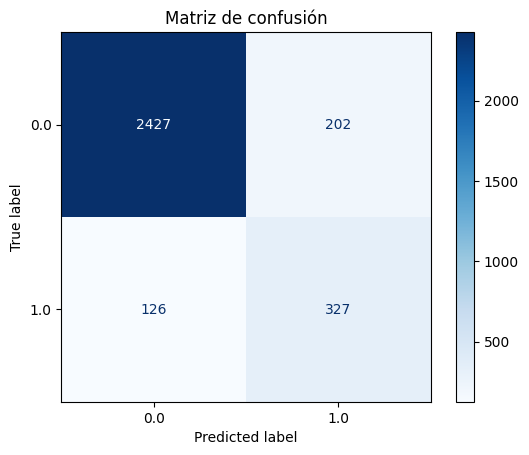

In [102]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_lgb_model.classes_)
disp.plot(cmap='Blues')
plt.title("Matriz de confusión")
plt.savefig("../img/matrix_test_ml.png", dpi=300, bbox_inches='tight')
plt.show()


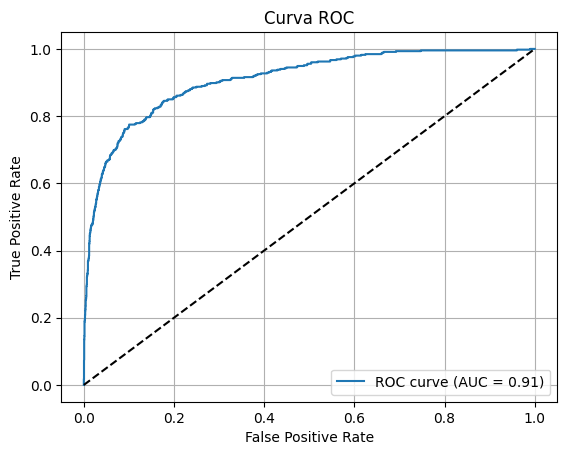

In [103]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc_score(y_test, y_prob))
plt.plot([0, 1], [0, 1], 'k--')  # línea diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid()
plt.savefig("../img/roc_ml_test.png", dpi=300, bbox_inches='tight')
plt.show()


# Data to predict ML model

## 🔍 Prediction on New Data (2017–2023)

In this section, predictions are made on a new dataset corresponding to the period **2017 to 2023**, using the **machine learning model that performed best during training and validation**: **LightGBM**.

The new data is first loaded **without the target variable** to ensure a fair prediction scenario. After applying the same preprocessing steps—such as numerical scaling—the trained `best_lgb_model` is used to generate both class predictions (`y_pred_nuevo`) and class probabilities (`y_prob_nuevo`).

Since the actual target values are available for these records, we can **evaluate the model's performance on this new dataset**. This is done by comparing the predicted values to the real ones, calculating the **accuracy**, and displaying a **confusion matrix** to visually inspect the classification performance.

This process is crucial to assess the model’s **generalization capability** on data that was not seen during training, and to validate its **reliability on recent, real-world data**.


In [104]:

# Load the new data (WITHOUT the target)
new_data = pd.read_csv("../data/Prep_data/prep_data.csv")
new_data.set_index("SEQN", inplace=True)

y_true = new_data[target].copy()  # Save the original target

X_prep = new_data.copy()

X_prep.columns = X_prep.columns.str.replace(' ', '_')

X_prep.head()


Gender  Age(year)  Race  Country_of_birth  Income_category  \
SEQN                                                                   
130378.0     1.0       43.0   5.0               2.0              5.0   
130379.0     1.0       66.0   3.0               1.0              5.0   
130380.0     2.0       44.0   2.0               2.0              2.0   
130386.0     1.0       34.0   1.0               1.0              2.0   
130394.0     1.0       51.0   3.0               1.0              5.0   

          Height(m)  Weight(kg)  HDL-Cholesterol(mmol/L)  \
SEQN                                                       
130378.0     1.8034   86.182480                     1.16   
130379.0     1.7780   99.790240                     1.55   
130380.0     1.5240   68.038800                     1.27   
130386.0     1.7272   90.718400                     1.19   
130394.0     1.7780   78.925008                     1.24   

          Total_Cholesterol(mmol/L)  Glycohemoglobin(%)  Insulin_(pmol/L)  \
SEQN                                                                        
130378.0                       6.83                 5.6             93.18   
130379.0                       5.53                 5.6            119.46   
130380.0                       4.84                 6.2             97.98   
130386.0                       4.73                 5.1             68.28   
130394.0                       4.73                 4.8             43.20   

          High_blood_pressure?  100_cigarrettes_life?  Diabetes_diagnosticated  
SEQN                                                                            
130378.0                   1.0                    1.0                      0.0  
130379.0                   1.0                    1.0                      0.0  
130380.0                   2.0                    2.0                      1.0  
130386.0                   2.0                    1.0                      0.0  
130394.0                   2.0                    2.0                      0.0

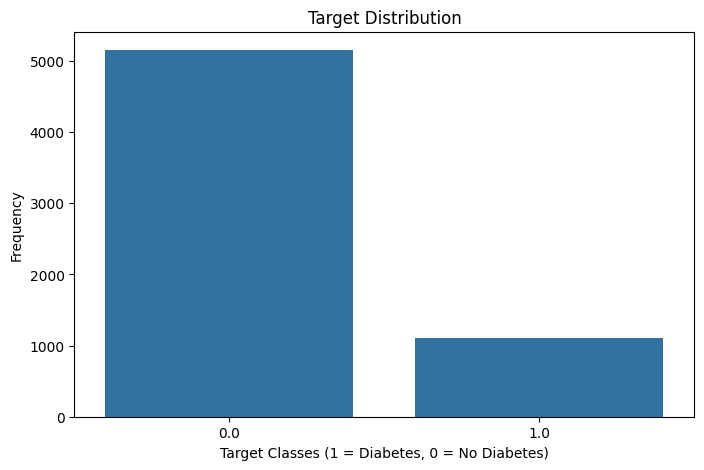

In [105]:
plt.figure(figsize=(8, 5))
sns.countplot(x=new_data["Diabetes_diagnosticated"])  # Bar plot to count categories
plt.xlabel("Target Classes (1 = Diabetes, 0 = No Diabetes)")
plt.ylabel("Frequency")
plt.title("Target Distribution")
plt.show()


In [106]:
new_data[target].value_counts(normalize=True) * 100

Diabetes_diagnosticated
0.0    82.39054
1.0    17.60946
Name: proportion, dtype: float64

### Feature engineering

In [107]:
# BMI Calculation (Body Mass Index)
X_prep['BMI'] = X_prep['Weight(kg)'] / (X_prep['Height(m)'] ** 2)

# Total Cholesterol / HDL Ratio (cardiovascular risk indicator)
X_prep['CHOL_ratio'] = X_prep['Total_Cholesterol(mmol/L)'] / X_prep['HDL-Cholesterol(mmol/L)']

# Group age into clinical categories
def age_group(age):
    if age < 18:
        return 1.0  # 'child'
    elif age < 40:
        return 2.0  # 'young_adult'
    elif age < 60:
        return 3.0  # 'adult'
    else:
        return 4.0  # 'senior'
X_prep['Age_group'] = X_prep['Age(year)'].apply(age_group)

# BMI categories according to WHO
def bmi_category(bmi):
    if bmi < 18.5:
        return 1.0  # 'underweight'
    elif bmi < 25:
        return 2.0  # 'normal'
    elif bmi < 30:
        return 3.0  # 'overweight'
    else:
        return 4.0  # 'obese'
X_prep['BMI_category'] = X_prep['BMI'].apply(bmi_category)

# Binary indicator for high total cholesterol
X_prep['High_cholesterol'] = (X_prep['Total_Cholesterol(mmol/L)'] > 6.2).astype(int)

# Binary indicator for elevated HbA1c (≥ 6.5% → diabetes diagnosis)
X_prep['High_HbA1c'] = (X_prep['Glycohemoglobin(%)'] >= 6.5).astype(int)

# Interaction: BMI x HbA1c
X_prep['BMI_HbA1c'] = X_prep['BMI'] * X_prep['Glycohemoglobin(%)']

# Binary indicator for high insulin (possible insulin resistance)
X_prep['High_insulin'] = (X_prep['Insulin_(pmol/L)'] > 90).astype(int)

# Simple cardiovascular risk indicator (older age, high BMI, high cholesterol, high blood pressure)
X_prep['Cardio_risk'] = (
    (X_prep['Age(year)'] > 60).astype(int) +
    (X_prep['BMI'] > 30).astype(int) +
    (X_prep['Total_Cholesterol(mmol/L)'] > 6.2).astype(int) +
    (X_prep['High_blood_pressure?'] == 1).astype(int)
)

X_prep.head()

X_prep.to_csv("../data/Prep_data/prep_data_cleaned.csv", index = False)


X_prep = X_prep.drop(target, axis=1)  # Drop the target


### logaritmic transformation

In [108]:
X_prep['Insulin_(pmol/L)'] = np.log1p(X_prep['Insulin_(pmol/L)'])
X_prep['Glycohemoglobin(%)'] = np.log1p(X_prep['Glycohemoglobin(%)'])
X_prep['BMI'] = np.log1p(X_prep['BMI'])
X_prep['CHOL_ratio'] = np.log1p(X_prep['CHOL_ratio'])
X_prep['BMI_HbA1c'] = np.log1p(X_prep['BMI_HbA1c'])
X_prep['HDL-Cholesterol(mmol/L)'] = np.log1p(X_prep['HDL-Cholesterol(mmol/L)'])
X_prep['Total_Cholesterol(mmol/L)'] = np.log1p(X_prep['Total_Cholesterol(mmol/L)'])

In [109]:
X_prep

Gender  Age(year)  Race  Country_of_birth  Income_category  \
SEQN                                                                   
130378.0     1.0       43.0   5.0               2.0              5.0   
130379.0     1.0       66.0   3.0               1.0              5.0   
130380.0     2.0       44.0   2.0               2.0              2.0   
130386.0     1.0       34.0   1.0               1.0              2.0   
130394.0     1.0       51.0   3.0               1.0              5.0   
...          ...        ...   ...               ...              ...   
124810.0     2.0       56.0   4.0               1.0              2.0   
124812.0     2.0       62.0   2.0               1.0              5.0   
124814.0     1.0       64.0   4.0               1.0              3.0   
124815.0     1.0       52.0   4.0               1.0              5.0   
124821.0     1.0       63.0   4.0               1.0              4.0   

          Height(m)  Weight(kg)  HDL-Cholesterol(mmol/L)  \
SEQN                                                       
130378.0     1.8034   86.182480                 0.770108   
130379.0     1.7780   99.790240                 0.936093   
130380.0     1.5240   68.038800                 0.819780   
130386.0     1.7272   90.718400                 0.783902   
130394.0     1.7780   78.925008                 0.806476   
...             ...         ...                      ...   
124810.0     1.6764  112.490816                 0.672944   
124812.0     1.6256   70.306760                 0.996949   
124814.0     1.7526  106.594120                 0.828552   
124815.0     1.8288   98.429464                 1.004302   
124821.0     1.8034   81.646560                 0.760806   

          Total_Cholesterol(mmol/L)  Glycohemoglobin(%)  ...  \
SEQN                                                     ...   
130378.0                   2.057963            1.887070  ...   
130379.0                   1.876407            1.887070  ...   
130380.0                   1.764731            1.974081  ...   
130386.0                   1.745716            1.808289  ...   
130394.0                   1.745716            1.757858  ...   
...                             ...                 ...  ...   
124810.0                   1.865629            1.887070  ...   
124812.0                   1.912501            1.824549  ...   
124814.0                   1.919859            1.974081  ...   
124815.0                   1.832581            1.916923  ...   
124821.0                   1.611436            1.931521  ...   

          100_cigarrettes_life?       BMI  CHOL_ratio  Age_group  \
SEQN                                                               
130378.0                    1.0  3.314162    1.929771        3.0   
130379.0                    1.0  3.483280    1.519019        4.0   
130380.0                    2.0  3.410968    1.570910        3.0   
130386.0                    1.0  3.447112    1.604383        2.0   
130394.0                    2.0  3.256793    1.571636        3.0   
...                         ...       ...         ...        ...   
124810.0                    2.0  3.714250    1.900240        3.0   
124812.0                    1.0  3.318011    1.475739        4.0   
124814.0                    1.0  3.575236    1.706860        4.0   
124815.0                    1.0  3.415434    1.394928        3.0   
124821.0                    2.0  3.262113    1.507968        4.0   

          BMI_category  High_cholesterol  High_HbA1c  BMI_HbA1c  High_insulin  \
SEQN                                                                            
130378.0           3.0                 1           0   5.006602             1   
130379.0           4.0                 0           0   5.180500             1   
130380.0           3.0                 0           0   5.207441             1   
130386.0           4.0                 0           0   5.050425             0   
130394.0           2.0                 0           0   4.794446             0   
...    

### Scaling

In [110]:
# Assuming you already trained your scaler like this:
scaler = StandardScaler()
scaler.fit(X_train[num_features])  # trained on original data

# Then for new data:
X_prep_scaled_num = pd.DataFrame(
    scaler.transform(X_prep[num_features]),  
    columns=num_features,
    index=X_prep.index
)

# Recover categorical columns
X_prep_scaled = pd.concat([X_prep_scaled_num, X_prep[cat_features]], axis=1)


In [111]:
X_prep_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6258 entries, 130378.0 to 124821.0
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age(year)                  6258 non-null   float64
 1   Height(m)                  6182 non-null   float64
 2   Weight(kg)                 6185 non-null   float64
 3   HDL-Cholesterol(mmol/L)    6257 non-null   float64
 4   Total_Cholesterol(mmol/L)  6257 non-null   float64
 5   Glycohemoglobin(%)         6258 non-null   float64
 6   Insulin_(pmol/L)           6258 non-null   float64
 7   BMI                        6124 non-null   float64
 8   CHOL_ratio                 6257 non-null   float64
 9   BMI_HbA1c                  6124 non-null   float64
 10  Gender                     6258 non-null   float64
 11  Race                       6258 non-null   float64
 12  Country_of_birth           6258 non-null   float64
 13  Income_category            6258 non-null  

In [112]:
y_pred_nuevo = best_lgb_model.predict(X_prep_scaled)
y_prob_nuevo = best_lgb_model.predict_proba(X_prep)[:, 1]


In [113]:

print("Accuracy:", accuracy_score(y_true, y_pred_nuevo))
print("Precision:", precision_score(y_true, y_pred_nuevo))
print("Recall:", recall_score(y_true, y_pred_nuevo))
print("F1 Score:", f1_score(y_true, y_pred_nuevo))
print("AUC-ROC:", roc_auc_score(y_true, y_prob_nuevo))

Accuracy: 0.8914988814317674
Precision: 0.6628175519630485
Recall: 0.7813067150635209
F1 Score: 0.717201166180758
AUC-ROC: 0.6169873803043764


In [114]:
resultados = pd.DataFrame({
    'Real': y_true,
    'Predicción': y_pred_nuevo,
    'Probabilidad': y_prob_nuevo
}, index=X_prep.index)


In [115]:
resultados['Acierto'] = resultados['Real'] == resultados['Predicción']
print(resultados['Acierto'].value_counts())
print(f"Accuracy en datos nuevos: {resultados['Acierto'].mean():.2f}")


Acierto
True     5579
False     679
Name: count, dtype: int64
Accuracy en datos nuevos: 0.89


In [117]:
print(classification_report(y_true, y_pred_nuevo))
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred_nuevo))


              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93      5156
         1.0       0.66      0.78      0.72      1102

    accuracy                           0.89      6258
   macro avg       0.81      0.85      0.83      6258
weighted avg       0.90      0.89      0.89      6258

Confusion matrix:
[[4718  438]
 [ 241  861]]


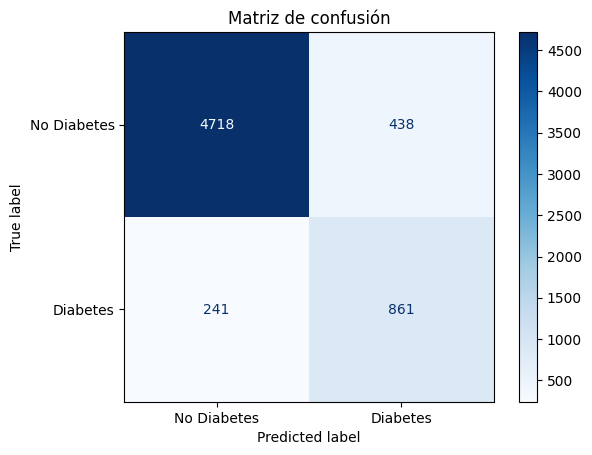

In [ ]:

ConfusionMatrixDisplay.from_predictions(resultados['Real'], resultados['Predicción'], 
                                        cmap='Blues', display_labels=['No Diabetes', 'Diabetes'])
plt.title("Matriz de confusión")
plt.grid(False)
plt.savefig("../img/matrix_ml_pred.png", dpi=300, bbox_inches='tight')
plt.show()


## 🧠 Neural Network 

A deep learning model was built using Keras to predict diabetes diagnosis from clinical data.

### 🔧 Preprocessing
- The dataset is split (80/20) into training and test sets.
- Numerical features are standardized with `StandardScaler`.

### ⚖️ Class Imbalance Handling
- Class weights are computed automatically (`balanced`) and adjusted to give more importance to the positive class (diabetes).

### 🧱 Model Architecture
- Dense layers with ReLU activations.
- Batch normalization and dropout for stability and regularization.
- Final sigmoid layer for binary output.

### 🚀 Training & Saving
- The model uses `Adam`, `binary_crossentropy`, and tracks accuracy, AUC, recall, and precision.
- Early stopping monitors validation AUC.
- The trained model is saved as `diabetes_nn_model.h5`.

### 📊 Evaluation
- Predictions and probabilities are computed on the test set.
- Evaluation includes classification report, AUC-ROC, average precision, confusion matrix, ROC and precision-recall curves.


In [ ]:
# === Load data ===
df = pd.read_csv('../data/Train_data/train_data_cleaned.csv')
target = 'Diabetes_diagnosticated'
X = df.drop(columns=[target])
y = df[target]

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Feature Scaling ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === Automatic class weight calculation ===
pesos = class_weight.compute_class_weight(class_weight='balanced',
                                          classes=np.unique(y_train),
                                          y=y_train)
pesos = dict(enumerate(pesos))

pesos[1] *= 1.2  # increase importance of class 1 (diabetes)
pesos[0] *= 0.9  # optional: slightly reduce class 0

# === Neural Network Architecture ===
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# === Compile the model ===
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Recall(name='recall'), Precision(name='precision')]
)

# === Early stopping configuration ===
early_stop = EarlyStopping(
    monitor='val_auc',
    patience=10,
    mode='max',
    restore_best_weights=True
)

# === Train the model ===
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    class_weight=pesos,
    callbacks=[early_stop],
    verbose=1
)



c:\Users\rodri\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6997 - auc: 0.8325 - loss: 0.5110 - precision: 0.3200 - recall: 0.8019 - val_accuracy: 0.8743 - val_auc: 0.9259 - val_loss: 0.3651 - val_precision: 0.5523 - val_recall: 0.8202
Epoch 2/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8116 - auc: 0.9033 - loss: 0.4114 - precision: 0.4335 - recall: 0.8309 - val_accuracy: 0.8122 - val_auc: 0.9299 - val_loss: 0.3581 - val_precision: 0.4344 - val_recall: 0.8665
Epoch 3/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8079 - auc: 0.9116 - loss: 0.3966 - precision: 0.4350 - recall: 0.8662 - val_accuracy: 0.8455 - val_auc: 0.9310 - val_loss: 0.3465 - val_precision: 0.4892 - val_recall: 0.8638
Epoch 4/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8191 - auc: 0.9153 - loss: 0.3916 - precision: 0.4529 - recall: 0.8448 - val_accuracy: 0.8200 - val_auc: 0.9238 - val_loss: 0.3925 - val_precision: 0.4462 - val_recall: 0.8692
Epoch 5/100
309/309 ━━━━━━━━

In [ ]:

os.makedirs("models", exist_ok=True)

# Save the trained Keras model
model.save("../models/diabetes_nn_model.h5")
print("✅ Model saved as 'models/diabetes_nn_model.h5'")


✅ Model saved as 'models/diabetes_nn_model.h5'


## 🧪 Evaluation on Test Set

The model is evaluated on the **test set** (unseen during training) to assess its generalization.

We compute:
- **Predictions** using a 0.4 threshold.
- A **classification report** with precision, recall, and F1-score.
- **AUC-ROC** and **Average Precision (AP)**.
- Visuals: **confusion matrix**, **ROC curve**, and **precision-recall curve**.

This confirms the model's performance on real, independent data.


97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.97      0.75      0.84      2629
         1.0       0.37      0.87      0.52       453

    accuracy                           0.76      3082
   macro avg       0.67      0.81      0.68      3082
weighted avg       0.88      0.76      0.80      3082

AUC-ROC: 0.90
Average Precision (AP): 0.72


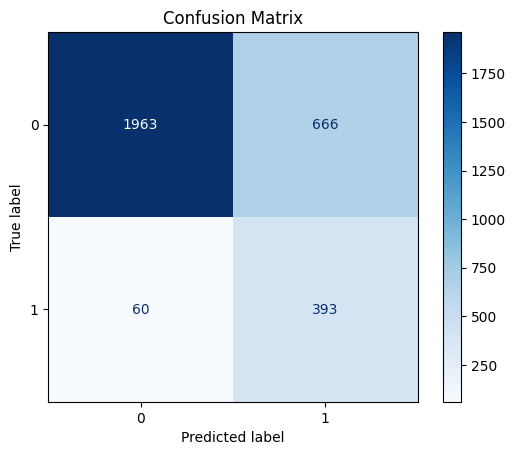

In [ ]:
# === 1. PREDICTIONS ===
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.4).astype("int32")  # Use 0.4 as threshold

# === 2. NUMERIC METRICS ===
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_pred_prob)
avg_precision = average_precision_score(y_test, y_pred_prob)

print(f"AUC-ROC: {auc:.2f}")
print(f"Average Precision (AP): {avg_precision:.2f}")

# === 3. CONFUSION MATRIX ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig("../img/matrix_nn_test.png", dpi=300, bbox_inches='tight')

plt.show()


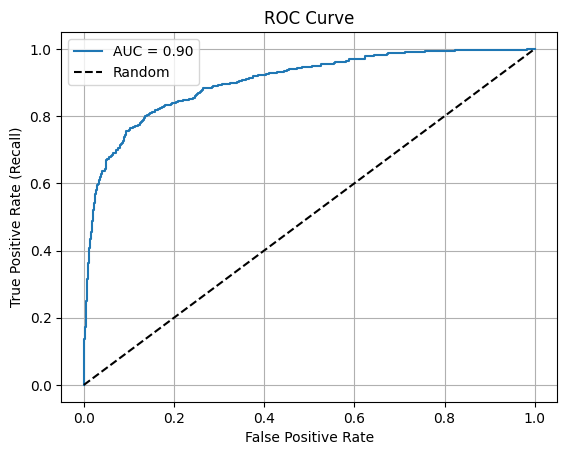

In [ ]:


# === 4. ROC CURVE ===
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.savefig("../img/recall_nn_test.png", dpi=300, bbox_inches='tight')

plt.show()


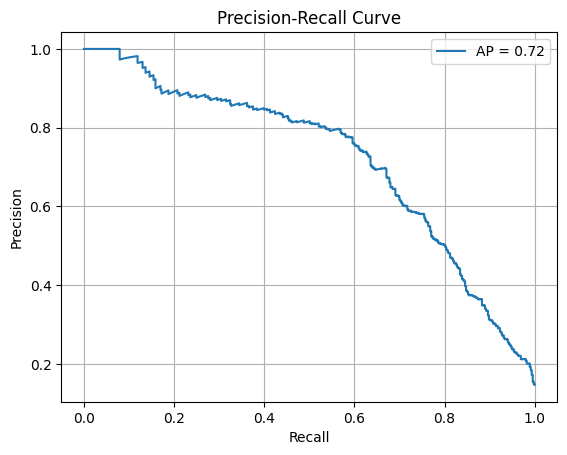

In [ ]:


# === 5. PRECISION-RECALL CURVE ===
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.savefig("../img/preciion_recall_nn_test.png", dpi=300, bbox_inches='tight')

plt.show()


## 🔄 Predictions on 2017–2023 Data with Neural Network

After evaluating the model on the test set, we now apply the **trained neural network** to the dataset from **2017 to 2023**, using the same preprocessing steps.

Since we already have the true labels for these records, we can:
- Generate predictions and predicted probabilities.
- Compare them against the real values.
- Evaluate the model's accuracy and visualize the **confusion matrix**.

This allows us to validate how well the neural network performs on recent real-world data.


In [ ]:
new_data = pd.read_csv("../data/Prep_data/prep_data_cleaned.csv")
y_true = new_data[target].copy()  
X_prep = new_data.drop(target, axis=1)  
X_prep.columns = X_prep.columns.str.replace(' ', '_')

X_prep.head()

Gender  Age(year)  Race  Country_of_birth  Income_category  Height(m)  \
0     1.0       43.0   5.0               2.0              5.0     1.8034   
1     1.0       66.0   3.0               1.0              5.0     1.7780   
2     2.0       44.0   2.0               2.0              2.0     1.5240   
3     1.0       34.0   1.0               1.0              2.0     1.7272   
4     1.0       51.0   3.0               1.0              5.0     1.7780   

   Weight(kg)  HDL-Cholesterol(mmol/L)  Total_Cholesterol(mmol/L)  \
0   86.182480                     1.16                       6.83   
1   99.790240                     1.55                       5.53   
2   68.038800                     1.27                       4.84   
3   90.718400                     1.19                       4.73   
4   78.925008                     1.24                       4.73   

   Glycohemoglobin(%)  ...  100_cigarrettes_life?        BMI  CHOL_ratio  \
0                 5.6  ...                    1.0  26.499328    5.887931   
1                 5.6  ...                    1.0  31.566364    3.567742   
2                 6.2  ...                    2.0  29.294542    3.811024   
3                 5.1  ...                    1.0  30.409559    3.974790   
4                 4.8  ...                    2.0  24.966124    3.814516   

   Age_group  BMI_category  High_cholesterol  High_HbA1c   BMI_HbA1c  \
0        3.0           3.0                 1           0  148.396235   
1        4.0           4.0                 0           0  176.771636   
2        3.0           3.0                 0           0  181.626160   
3        2.0           4.0                 0           0  155.088751   
4        3.0           2.0                 0           0  119.837395   

   High_insulin  Cardio_risk  
0             1            2  
1             1            3  
2             1            0  
3             0            1  
4             0            0  

[5 rows x 22 columns]

In [ ]:
X_prep_scaled = scaler.transform(X_prep)


In [ ]:
y_pred_proba = loaded_model.predict(X_prep_scaled)

# Convert to class labels using 0.4 threshold
y_pred = (y_pred_proba >= 0.4).astype(int).ravel()  # ravel() to flatten the array



196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
print(classification_report(y_true, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

         0.0       0.97      0.72      0.83      5156
         1.0       0.41      0.91      0.56      1102

    accuracy                           0.75      6258
   macro avg       0.69      0.81      0.69      6258
weighted avg       0.87      0.75      0.78      6258

Confusion matrix:
[[3697 1459]
 [  97 1005]]


In [ ]:
resultados = pd.DataFrame({
    'Real': y_true,
    'Predictión': y_pred,
}, index=X_prep.index)


In [ ]:
resultados['Correct'] = resultados['Real'] == resultados['Predictión']
print(resultados['Correct'].value_counts())
print(f"Accuracy on new data: {resultados['Correct'].mean():.2f}")


Correct
True     4702
False    1556
Name: count, dtype: int64
Accuracy on new data: 0.75


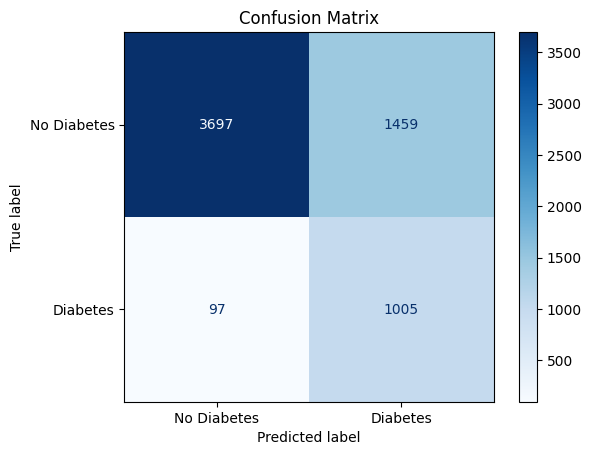

In [ ]:
ConfusionMatrixDisplay.from_predictions(resultados['Real'], resultados['Predictión'], 
                                        cmap='Blues', display_labels=['No Diabetes', 'Diabetes'])
plt.title("Confusion Matrix")
plt.grid(False)
plt.savefig("../img/matrix_nn_pred.png", dpi=300, bbox_inches='tight')

plt.show()


## 📊 Comparison Between Neural Network and Machine Learning Models

Both models were evaluated on the same dataset from 2017–2023. Below is a summary of their performance:

| Metric          | Neural Network       | Machine Learning Model |
|-----------------|----------------------|-------------------------|
| **Accuracy**    | 0.75                 | **0.89**                |
| **Precision**   | 0.40                 | **0.66**                |
| **Recall**      | **0.89**             | 0.78                    |
| **F1-Score**    | 0.55                 | **0.72**                |
| **AUC-ROC**     | 0.61 (from metrics)  | **0.62**                |

### ✅ Key Observations

- The **machine learning model** (e.g. LightGBM) achieved **higher overall performance**, especially in terms of:
  - **Accuracy** (+14%)
  - **Precision** (+26%)
  - **F1-Score**, which balances precision and recall.

- The **neural network** showed **higher sensitivity (Recall = 0.89)** for detecting diabetes, which can be useful in clinical screening contexts where missing a positive case is more costly than a false positive.

- However, the neural network suffered from **lower precision (0.40)**, generating a large number of false positives (as seen in its confusion matrix: 1457 FP vs 438 in the ML model).

### 🧠 Final Thoughts

- If the goal is **clinical sensitivity** and casting a wider net to detect more diabetic patients (even with more false positives), the **neural network may be preferred**.
- If the objective is a **more balanced and reliable prediction** system with fewer false alarms, the **machine learning model is clearly superior**.

Depending on the application (e.g. early screening vs. diagnostic support), one model may be more appropriate than the other.
